# Postprocess locations from DLC and a video

In [1]:
import h5py
import os
import matplotlib.pyplot as plt

from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import *
import cv2
import torch
import tifffile

from ipywidgets import interact, interactive, fixed, interact_manual
from dNMF.Demix.dNMF import dNMF
import time
import scipy.io as scio
from sklearn.decomposition import FastICA

c:\users\charles.fieseler\documents\current_work\dlc_for_wbfm\DLC_for_WBFM\utils\postprocessing\postprocessing_utils.py:674: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(crop_sz)==3, "Crop must be 3d")


## BEFORE ANYTHING: move the gcamp video to the project folder!

## First, read the locations from DLC

In [9]:
which_neuron = 2; # Not sure which neurons are which

In [10]:
# Get the video folder, then the annotation
project_folder = r'C:\Users\charles.fieseler\Documents\Current_work\DLC_for_WBFM\DLC_Projects\wbfm_3d-Charlie-2020-11-02'
bigtiff_folder = r'D:\More-stabilized-wbfm'

annotation_fname = r'videos\test2020-10-22_mcherry_fr1000_sl10_15DLC_resnet50_wbfm_3dNov2shuffle1_200000.h5'
annotation_fname = os.path.join(project_folder, annotation_fname)

# Will get traces from two videos:
btf_fname_mcherry = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_mcherry = os.path.join(bigtiff_folder, btf_fname_mcherry)
btf_fname_gcamp = r'test2020-10-22_16-15-20_test4-channel-1-pco_camera2\test2020-10-22_16-15-20_test4-channel-1-pco_camera2bigtiff.btf'
btf_fname_gcamp = os.path.join(bigtiff_folder, btf_fname_gcamp)

In [11]:
# Get the positions from the annotation: ONE neuron
this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=1000)

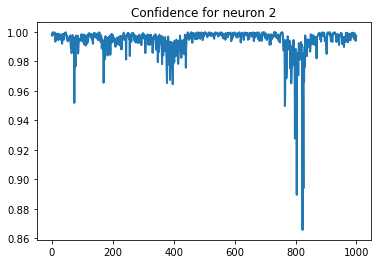

In [12]:
plt.plot(this_prob, lw=2)
# plt.ylim([0,1])
plt.title(f'Confidence for neuron {which_neuron}');

## Second, get a moving 3d crop centering this neuron

In [13]:
# Use video from above

num_frames = 10
sz=None#(21,21, 7)
which_z = 12
alpha = 0.15
start_volume = 100

In [14]:
cropped_dat_mcherry = get_crop_from_ometiff_virtual(btf_fname_mcherry, 
                                                    this_xy, which_z, 
                                                    num_frames, 
                                                    crop_sz=sz,
                                                    num_slices=33,
                                                    actually_create=True,
                                                    alpha=alpha,
                                                    start_volume=start_volume)
cropped_dat_gcamp = get_crop_from_ometiff_virtual(btf_fname_gcamp, 
                                                  this_xy, which_z, 
                                                  num_frames,
                                                  crop_sz=sz,
                                                  num_slices=33,
                                                  actually_create=True,
                                                  flip_x=True,
                                                  alpha=alpha,
                                                  start_volume=start_volume)

Cropping 7 slices, starting at 8
(700, 900)
Page 3308/330; volume 0/10 to cropped array slice 0
Page 3309/330; volume 0/10 to cropped array slice 1
Page 3310/330; volume 0/10 to cropped array slice 2
Page 3311/330; volume 0/10 to cropped array slice 3
Page 3312/330; volume 0/10 to cropped array slice 4
Page 3313/330; volume 0/10 to cropped array slice 5
Page 3314/330; volume 0/10 to cropped array slice 6
Page 3341/330; volume 1/10 to cropped array slice 0
Page 3342/330; volume 1/10 to cropped array slice 1
Page 3343/330; volume 1/10 to cropped array slice 2
Page 3344/330; volume 1/10 to cropped array slice 3
Page 3345/330; volume 1/10 to cropped array slice 4
Page 3346/330; volume 1/10 to cropped array slice 5
Page 3347/330; volume 1/10 to cropped array slice 6
Page 3374/330; volume 2/10 to cropped array slice 0
Page 3375/330; volume 2/10 to cropped array slice 1
Page 3376/330; volume 2/10 to cropped array slice 2
Page 3377/330; volume 2/10 to cropped array slice 3
Page 3378/330; volum

In [15]:
def f(t,z): 
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(cropped_dat_mcherry[t,z,...]);
    plt.title('mcherry')
    plt.colorbar()
    plt.clim(0, 200)
    
    plt.subplot(122)
    plt.imshow(cropped_dat_gcamp[t,z,...]);
    plt.title('gcamp')
    plt.colorbar()
#     plt.clim(0, 50)
interact(f, t=(0,num_frames-1), z=(0,sz[-1]-1));

interactive(children=(IntSlider(value=4, description='t', max=9), IntSlider(value=3, description='z', max=6), …

In [49]:
cropped_dat_mcherry.shape

(900, 7, 21, 21)

## Aside: Simple ways to get traces

Find the direct maximum and the mean of top 10%

In [50]:
max_coords, max_values = local_maxima_2D(cropped_dat_mcherry[:,:,0,:])

interactive(children=(IntSlider(value=449, description='i', max=899), Output()), _dom_classes=('widget-interac…

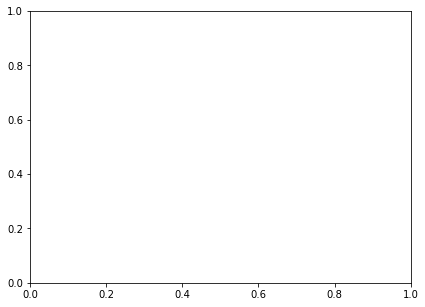

In [51]:
def f(i):
    plt.figure(figsize=[15,5])
    
    plt.subplot(121)
    plt.imshow(cropped_dat_mcherry[:,:,0,i], vmin=50, vmax=np.amax(max_values));
    plt.title(f'mcherry Max = {max_values[i]}')
    
    plt.subplot(122)
    plt.plot(max_values)
    plt.scatter(i, max_values[i], c='r', linewidths=5)
interact(f, i=(0,num_frames-1));

In [52]:
mean_percentile_values_gcamp = mean_of_top_percentile(cropped_dat_gcamp[:,:,0,:], percentile=95)
mean_percentile_values_mcherry = mean_of_top_percentile(cropped_dat_mcherry[:,:,0,:], percentile=95)

interactive(children=(IntSlider(value=449, description='i', max=899), Output()), _dom_classes=('widget-interac…

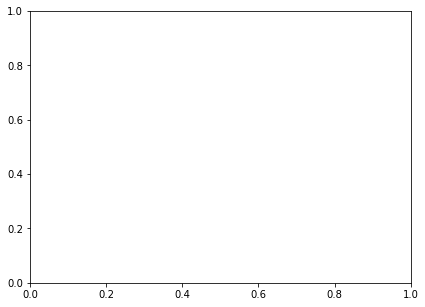

In [53]:
def f(i):
    plt.figure(figsize=[15,5])
    
    plt.subplot(121)
#     plt.imshow(cropped_dat_gcamp[:,:,0,i], vmin=50, vmax=np.amax(max_values));
    plt.imshow(cropped_dat_gcamp[:,:,0,i], vmin=0);
    plt.colorbar()
    plt.title(f'gcamp Mean of top 10% = {mean_percentile_values_gcamp[i]}')
    
    plt.subplot(122)
    plt.plot(mean_percentile_values_gcamp / np.max(mean_percentile_values_gcamp), label='gcamp')
    plt.plot(mean_percentile_values_mcherry / np.max(mean_percentile_values_mcherry), label='mcherry')
    plt.scatter(i, (mean_percentile_values_gcamp / np.max(mean_percentile_values_gcamp))[i], c='r', linewidths=5)
    plt.title('Mean of top 10%')
    plt.legend()
interact(f, i=(0,num_frames-1));

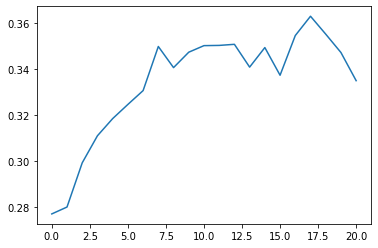

In [54]:
plt.plot(mean_percentile_values_gcamp / mean_percentile_values_mcherry)

## Run dNMF

In [55]:
# %% Choosing the parameters
params = {'n_trials':5, 'noise_level':1e-2, 'sigma_inv':.2, 
          'radius':10, 'step_S':.1, 'gamma':0, 'stride_factor':2, 'density':.1, 'varfact':5,
          'traj_means':[.0,.0,.0], 'traj_variances':[2e-4,2e-4,1e-5], 'sz':[20,20,1], 
          'K':20, 'T':100, 'roi_window':[4,4,0]}

In [56]:
# Build position and convert to pytorch
# sz=(28,28,10)
positions =[list(sz),[0, 0, 0]] # Add a dummy position
positions = np.expand_dims(positions,2)/2.0 # Return the center of the crop
positions =  torch.tensor(positions).float()
print(positions)
print(positions.shape)

# Also convert video to pytorch
dat_mcherry = torch.tensor(np.transpose(cropped_dat_mcherry, axes=(2,3,1,0))).float()
dat_gcamp = torch.tensor(np.transpose(cropped_dat_gcamp, axes=(2,3,1,0))).float()

params2={'positions':positions,\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':False}
# params = {'positions':positions[:,:,0][:,:,np.newaxis],\
#     'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
#     'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
#     'method':'1->t', 'verbose':False}
print(dat_mcherry.shape)

tensor([[[10.5000],
         [10.5000],
         [ 3.5000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000]]])
torch.Size([2, 3, 1])
torch.Size([21, 21, 7, 900])


In [57]:
start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
dnmf_mcherry = dNMF(dat_mcherry,params=params2)
dnmf_gcamp = dNMF(dat_gcamp,params=params2)

dnmf_mcherry.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
print("Finished mcherry, now doing gcamp...")
dnmf_gcamp.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

Finished mcherry, now doing gcamp...
dNMF finished in 328.1343047618866 seconds


## Plot the dNMF traces

Text(0.5, 1.0, 'raw gcamp')

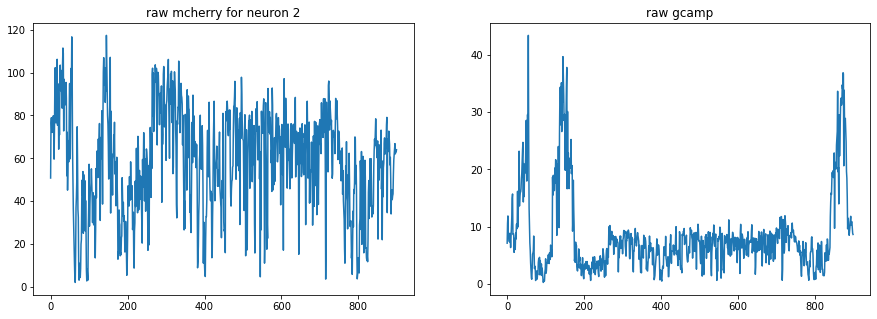

In [58]:

plt.subplot(121)
plt.plot(dnmf_mcherry.C[0,:]) # This index is which neuron within the crop
plt.title(f'raw mcherry for neuron {which_neuron}')

plt.subplot(122)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.figure(figsize=(15,5))

## Workflows to denoise gcamp using mcherry

### First, ICA

In [39]:
# Data shaping
X = np.vstack((dnmf_mcherry.C[0,:], dnmf_gcamp.C[0,:])).transpose()
transformer = FastICA(n_components=2, random_state=0)
X_transformed = transformer.fit_transform(X)

NameError: name 'wb_dat' is not defined

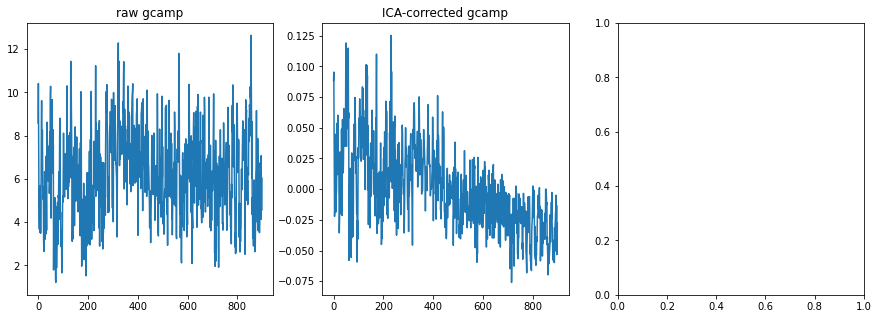

In [40]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.subplot(132)
plt.plot(-X_transformed[:,0]) # This index is which neuron within the crop
plt.title('ICA-corrected gcamp')

# plt.subplot(133)
# plt.plot(wb_dat)
# plt.title('trace from wb')

### Second, ratiometric

Text(0.5, 1.0, 'ratio of gcamp to mcherry')

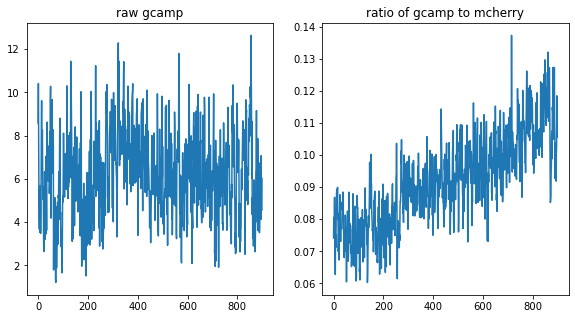

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.subplot(132)
plt.plot(dnmf_gcamp.C[0,:] / dnmf_mcherry.C[0,:]) # This index is which neuron within the crop
plt.title('ratio of gcamp to mcherry')

# plt.subplot(133)
# plt.plot(wb_dat)
# plt.title('trace from wb')

## Not working: visualize neuron footprints

In [ ]:
neuron_names = [str(i) for i in range(positions.shape[0])]
# dnmf.visualize_traces('result', [dnmf.C], save=False)
# dnmf.visualize_traces('result',np.expand_dims(dnmf.C, axis=-1), neuron_names, save=False)
# dnmf_mcherry.visualize_neurons(f'Results2d_neuron{which_neuron}', [['0','1']], neuron_names, dat, window=np.array([10,10]))

In [ ]:
X_transformed.shape

In [ ]:
X_transformed


## Get all traces

In [4]:

num_frames = 500
sz=(21,21, 5)
which_z = 12
alpha = 0.15
start_volume = 100
num_slices = 33


z_params = (which_z, num_slices, alpha, start_volume)

In [5]:
all_traces = extract_all_traces(annotation_fname,
                               btf_fname_mcherry,
                               btf_fname_gcamp,
                               which_neurons=None,
                               num_frames=num_frames,
                               crop_sz=sz,
                               params=None,
                               is_3d=True,
                               z_params=z_params)

Found annotations for 8 neurons and 500 frames
Starting analysis of neuron 0/8...
Cropping 5 slices, starting at 9
(700, 900)
Page 3309/16500; volume 0/500 to cropped array slice 0
Page 3310/16500; volume 0/500 to cropped array slice 1
Page 3311/16500; volume 0/500 to cropped array slice 2
Page 3312/16500; volume 0/500 to cropped array slice 3
Page 3313/16500; volume 0/500 to cropped array slice 4
Page 3342/16500; volume 1/500 to cropped array slice 0
Page 3343/16500; volume 1/500 to cropped array slice 1
Page 3344/16500; volume 1/500 to cropped array slice 2
Page 3345/16500; volume 1/500 to cropped array slice 3
Page 3346/16500; volume 1/500 to cropped array slice 4
Page 3375/16500; volume 2/500 to cropped array slice 0
Page 3376/16500; volume 2/500 to cropped array slice 1
Page 3377/16500; volume 2/500 to cropped array slice 2
Page 3378/16500; volume 2/500 to cropped array slice 3
Page 3379/16500; volume 2/500 to cropped array slice 4
Page 3408/16500; volume 3/500 to cropped array sl

Page 4467/16500; volume 35/500 to cropped array slice 3
Page 4468/16500; volume 35/500 to cropped array slice 4
Page 4497/16500; volume 36/500 to cropped array slice 0
Page 4498/16500; volume 36/500 to cropped array slice 1
Page 4499/16500; volume 36/500 to cropped array slice 2
Page 4500/16500; volume 36/500 to cropped array slice 3
Page 4501/16500; volume 36/500 to cropped array slice 4
Page 4530/16500; volume 37/500 to cropped array slice 0
Page 4531/16500; volume 37/500 to cropped array slice 1
Page 4532/16500; volume 37/500 to cropped array slice 2
Page 4533/16500; volume 37/500 to cropped array slice 3
Page 4534/16500; volume 37/500 to cropped array slice 4
Page 4563/16500; volume 38/500 to cropped array slice 0
Page 4564/16500; volume 38/500 to cropped array slice 1
Page 4565/16500; volume 38/500 to cropped array slice 2
Page 4566/16500; volume 38/500 to cropped array slice 3
Page 4567/16500; volume 38/500 to cropped array slice 4
Page 4596/16500; volume 39/500 to cropped array 

Page 5620/16500; volume 70/500 to cropped array slice 1
Page 5621/16500; volume 70/500 to cropped array slice 2
Page 5622/16500; volume 70/500 to cropped array slice 3
Page 5623/16500; volume 70/500 to cropped array slice 4
Page 5652/16500; volume 71/500 to cropped array slice 0
Page 5653/16500; volume 71/500 to cropped array slice 1
Page 5654/16500; volume 71/500 to cropped array slice 2
Page 5655/16500; volume 71/500 to cropped array slice 3
Page 5656/16500; volume 71/500 to cropped array slice 4
Page 5685/16500; volume 72/500 to cropped array slice 0
Page 5686/16500; volume 72/500 to cropped array slice 1
Page 5687/16500; volume 72/500 to cropped array slice 2
Page 5688/16500; volume 72/500 to cropped array slice 3
Page 5689/16500; volume 72/500 to cropped array slice 4
Page 5718/16500; volume 73/500 to cropped array slice 0
Page 5719/16500; volume 73/500 to cropped array slice 1
Page 5720/16500; volume 73/500 to cropped array slice 2
Page 5721/16500; volume 73/500 to cropped array 

Page 6745/16500; volume 104/500 to cropped array slice 4
Page 6774/16500; volume 105/500 to cropped array slice 0
Page 6775/16500; volume 105/500 to cropped array slice 1
Page 6776/16500; volume 105/500 to cropped array slice 2
Page 6777/16500; volume 105/500 to cropped array slice 3
Page 6778/16500; volume 105/500 to cropped array slice 4
Page 6807/16500; volume 106/500 to cropped array slice 0
Page 6808/16500; volume 106/500 to cropped array slice 1
Page 6809/16500; volume 106/500 to cropped array slice 2
Page 6810/16500; volume 106/500 to cropped array slice 3
Page 6811/16500; volume 106/500 to cropped array slice 4
Page 6840/16500; volume 107/500 to cropped array slice 0
Page 6841/16500; volume 107/500 to cropped array slice 1
Page 6842/16500; volume 107/500 to cropped array slice 2
Page 6843/16500; volume 107/500 to cropped array slice 3
Page 6844/16500; volume 107/500 to cropped array slice 4
Page 6873/16500; volume 108/500 to cropped array slice 0
Page 6874/16500; volume 108/500

Page 7896/16500; volume 139/500 to cropped array slice 0
Page 7897/16500; volume 139/500 to cropped array slice 1
Page 7898/16500; volume 139/500 to cropped array slice 2
Page 7899/16500; volume 139/500 to cropped array slice 3
Page 7900/16500; volume 139/500 to cropped array slice 4
Page 7929/16500; volume 140/500 to cropped array slice 0
Page 7930/16500; volume 140/500 to cropped array slice 1
Page 7931/16500; volume 140/500 to cropped array slice 2
Page 7932/16500; volume 140/500 to cropped array slice 3
Page 7933/16500; volume 140/500 to cropped array slice 4
Page 7962/16500; volume 141/500 to cropped array slice 0
Page 7963/16500; volume 141/500 to cropped array slice 1
Page 7964/16500; volume 141/500 to cropped array slice 2
Page 7965/16500; volume 141/500 to cropped array slice 3
Page 7966/16500; volume 141/500 to cropped array slice 4
Page 7995/16500; volume 142/500 to cropped array slice 0
Page 7996/16500; volume 142/500 to cropped array slice 1
Page 7997/16500; volume 142/500

Page 9022/16500; volume 173/500 to cropped array slice 4
Page 9051/16500; volume 174/500 to cropped array slice 0
Page 9052/16500; volume 174/500 to cropped array slice 1
Page 9053/16500; volume 174/500 to cropped array slice 2
Page 9054/16500; volume 174/500 to cropped array slice 3
Page 9055/16500; volume 174/500 to cropped array slice 4
Page 9084/16500; volume 175/500 to cropped array slice 0
Page 9085/16500; volume 175/500 to cropped array slice 1
Page 9086/16500; volume 175/500 to cropped array slice 2
Page 9087/16500; volume 175/500 to cropped array slice 3
Page 9088/16500; volume 175/500 to cropped array slice 4
Page 9117/16500; volume 176/500 to cropped array slice 0
Page 9118/16500; volume 176/500 to cropped array slice 1
Page 9119/16500; volume 176/500 to cropped array slice 2
Page 9120/16500; volume 176/500 to cropped array slice 3
Page 9121/16500; volume 176/500 to cropped array slice 4
Page 9150/16500; volume 177/500 to cropped array slice 0
Page 9151/16500; volume 177/500

Page 10142/16500; volume 207/500 to cropped array slice 2
Page 10143/16500; volume 207/500 to cropped array slice 3
Page 10144/16500; volume 207/500 to cropped array slice 4
Page 10173/16500; volume 208/500 to cropped array slice 0
Page 10174/16500; volume 208/500 to cropped array slice 1
Page 10175/16500; volume 208/500 to cropped array slice 2
Page 10176/16500; volume 208/500 to cropped array slice 3
Page 10177/16500; volume 208/500 to cropped array slice 4
Page 10206/16500; volume 209/500 to cropped array slice 0
Page 10207/16500; volume 209/500 to cropped array slice 1
Page 10208/16500; volume 209/500 to cropped array slice 2
Page 10209/16500; volume 209/500 to cropped array slice 3
Page 10210/16500; volume 209/500 to cropped array slice 4
Page 10239/16500; volume 210/500 to cropped array slice 0
Page 10240/16500; volume 210/500 to cropped array slice 1
Page 10241/16500; volume 210/500 to cropped array slice 2
Page 10242/16500; volume 210/500 to cropped array slice 3
Page 10243/165

Page 11068/16500; volume 235/500 to cropped array slice 4
Page 11097/16500; volume 236/500 to cropped array slice 0
Page 11098/16500; volume 236/500 to cropped array slice 1
Page 11099/16500; volume 236/500 to cropped array slice 2
Page 11100/16500; volume 236/500 to cropped array slice 3
Page 11101/16500; volume 236/500 to cropped array slice 4
Page 11130/16500; volume 237/500 to cropped array slice 0
Page 11131/16500; volume 237/500 to cropped array slice 1
Page 11132/16500; volume 237/500 to cropped array slice 2
Page 11133/16500; volume 237/500 to cropped array slice 3
Page 11134/16500; volume 237/500 to cropped array slice 4
Page 11163/16500; volume 238/500 to cropped array slice 0
Page 11164/16500; volume 238/500 to cropped array slice 1
Page 11165/16500; volume 238/500 to cropped array slice 2
Page 11166/16500; volume 238/500 to cropped array slice 3
Page 11167/16500; volume 238/500 to cropped array slice 4
Page 11196/16500; volume 239/500 to cropped array slice 0
Page 11197/165

Page 12222/16500; volume 270/500 to cropped array slice 3
Page 12223/16500; volume 270/500 to cropped array slice 4
Page 12252/16500; volume 271/500 to cropped array slice 0
Page 12253/16500; volume 271/500 to cropped array slice 1
Page 12254/16500; volume 271/500 to cropped array slice 2
Page 12255/16500; volume 271/500 to cropped array slice 3
Page 12256/16500; volume 271/500 to cropped array slice 4
Page 12285/16500; volume 272/500 to cropped array slice 0
Page 12286/16500; volume 272/500 to cropped array slice 1
Page 12287/16500; volume 272/500 to cropped array slice 2
Page 12288/16500; volume 272/500 to cropped array slice 3
Page 12289/16500; volume 272/500 to cropped array slice 4
Page 12318/16500; volume 273/500 to cropped array slice 0
Page 12319/16500; volume 273/500 to cropped array slice 1
Page 12320/16500; volume 273/500 to cropped array slice 2
Page 12321/16500; volume 273/500 to cropped array slice 3
Page 12322/16500; volume 273/500 to cropped array slice 4
Page 12351/165

Page 13376/16500; volume 305/500 to cropped array slice 2
Page 13377/16500; volume 305/500 to cropped array slice 3
Page 13378/16500; volume 305/500 to cropped array slice 4
Page 13407/16500; volume 306/500 to cropped array slice 0
Page 13408/16500; volume 306/500 to cropped array slice 1
Page 13409/16500; volume 306/500 to cropped array slice 2
Page 13410/16500; volume 306/500 to cropped array slice 3
Page 13411/16500; volume 306/500 to cropped array slice 4
Page 13440/16500; volume 307/500 to cropped array slice 0
Page 13441/16500; volume 307/500 to cropped array slice 1
Page 13442/16500; volume 307/500 to cropped array slice 2
Page 13443/16500; volume 307/500 to cropped array slice 3
Page 13444/16500; volume 307/500 to cropped array slice 4
Page 13473/16500; volume 308/500 to cropped array slice 0
Page 13474/16500; volume 308/500 to cropped array slice 1
Page 13475/16500; volume 308/500 to cropped array slice 2
Page 13476/16500; volume 308/500 to cropped array slice 3
Page 13477/165

Page 14533/16500; volume 340/500 to cropped array slice 4
Page 14562/16500; volume 341/500 to cropped array slice 0
Page 14563/16500; volume 341/500 to cropped array slice 1
Page 14564/16500; volume 341/500 to cropped array slice 2
Page 14565/16500; volume 341/500 to cropped array slice 3
Page 14566/16500; volume 341/500 to cropped array slice 4
Page 14595/16500; volume 342/500 to cropped array slice 0
Page 14596/16500; volume 342/500 to cropped array slice 1
Page 14597/16500; volume 342/500 to cropped array slice 2
Page 14598/16500; volume 342/500 to cropped array slice 3
Page 14599/16500; volume 342/500 to cropped array slice 4
Page 14628/16500; volume 343/500 to cropped array slice 0
Page 14629/16500; volume 343/500 to cropped array slice 1
Page 14630/16500; volume 343/500 to cropped array slice 2
Page 14631/16500; volume 343/500 to cropped array slice 3
Page 14632/16500; volume 343/500 to cropped array slice 4
Page 14661/16500; volume 344/500 to cropped array slice 0
Page 14662/165

Page 15685/16500; volume 375/500 to cropped array slice 1
Page 15686/16500; volume 375/500 to cropped array slice 2
Page 15687/16500; volume 375/500 to cropped array slice 3
Page 15688/16500; volume 375/500 to cropped array slice 4
Page 15717/16500; volume 376/500 to cropped array slice 0
Page 15718/16500; volume 376/500 to cropped array slice 1
Page 15719/16500; volume 376/500 to cropped array slice 2
Page 15720/16500; volume 376/500 to cropped array slice 3
Page 15721/16500; volume 376/500 to cropped array slice 4
Page 15750/16500; volume 377/500 to cropped array slice 0
Page 15751/16500; volume 377/500 to cropped array slice 1
Page 15752/16500; volume 377/500 to cropped array slice 2
Page 15753/16500; volume 377/500 to cropped array slice 3
Page 15754/16500; volume 377/500 to cropped array slice 4
Page 15783/16500; volume 378/500 to cropped array slice 0
Page 15784/16500; volume 378/500 to cropped array slice 1
Page 15785/16500; volume 378/500 to cropped array slice 2
Page 15786/165

Page 16840/16500; volume 410/500 to cropped array slice 1
Page 16841/16500; volume 410/500 to cropped array slice 2
Page 16842/16500; volume 410/500 to cropped array slice 3
Page 16843/16500; volume 410/500 to cropped array slice 4
Page 16872/16500; volume 411/500 to cropped array slice 0
Page 16873/16500; volume 411/500 to cropped array slice 1
Page 16874/16500; volume 411/500 to cropped array slice 2
Page 16875/16500; volume 411/500 to cropped array slice 3
Page 16876/16500; volume 411/500 to cropped array slice 4
Page 16905/16500; volume 412/500 to cropped array slice 0
Page 16906/16500; volume 412/500 to cropped array slice 1
Page 16907/16500; volume 412/500 to cropped array slice 2
Page 16908/16500; volume 412/500 to cropped array slice 3
Page 16909/16500; volume 412/500 to cropped array slice 4
Page 16938/16500; volume 413/500 to cropped array slice 0
Page 16939/16500; volume 413/500 to cropped array slice 1
Page 16940/16500; volume 413/500 to cropped array slice 2
Page 16941/165

Page 17995/16500; volume 445/500 to cropped array slice 1
Page 17996/16500; volume 445/500 to cropped array slice 2
Page 17997/16500; volume 445/500 to cropped array slice 3
Page 17998/16500; volume 445/500 to cropped array slice 4
Page 18027/16500; volume 446/500 to cropped array slice 0
Page 18028/16500; volume 446/500 to cropped array slice 1
Page 18029/16500; volume 446/500 to cropped array slice 2
Page 18030/16500; volume 446/500 to cropped array slice 3
Page 18031/16500; volume 446/500 to cropped array slice 4
Page 18060/16500; volume 447/500 to cropped array slice 0
Page 18061/16500; volume 447/500 to cropped array slice 1
Page 18062/16500; volume 447/500 to cropped array slice 2
Page 18063/16500; volume 447/500 to cropped array slice 3
Page 18064/16500; volume 447/500 to cropped array slice 4
Page 18093/16500; volume 448/500 to cropped array slice 0
Page 18094/16500; volume 448/500 to cropped array slice 1
Page 18095/16500; volume 448/500 to cropped array slice 2
Page 18096/165

Page 19152/16500; volume 480/500 to cropped array slice 3
Page 19153/16500; volume 480/500 to cropped array slice 4
Page 19182/16500; volume 481/500 to cropped array slice 0
Page 19183/16500; volume 481/500 to cropped array slice 1
Page 19184/16500; volume 481/500 to cropped array slice 2
Page 19185/16500; volume 481/500 to cropped array slice 3
Page 19186/16500; volume 481/500 to cropped array slice 4
Page 19215/16500; volume 482/500 to cropped array slice 0
Page 19216/16500; volume 482/500 to cropped array slice 1
Page 19217/16500; volume 482/500 to cropped array slice 2
Page 19218/16500; volume 482/500 to cropped array slice 3
Page 19219/16500; volume 482/500 to cropped array slice 4
Page 19248/16500; volume 483/500 to cropped array slice 0
Page 19249/16500; volume 483/500 to cropped array slice 1
Page 19250/16500; volume 483/500 to cropped array slice 2
Page 19251/16500; volume 483/500 to cropped array slice 3
Page 19252/16500; volume 483/500 to cropped array slice 4
Page 19281/165

tensor(-1.3774)
Iter: 10 - Cost: tensor(249.3435, grad_fn=<AddBackward0>)
tensor(0.1997, grad_fn=<MeanBackward0>)
Update C:
tensor(31.6798)
Update A:
tensor(0.1003, grad_fn=<MeanBackward0>)
tensor(244.2321, grad_fn=<AddBackward0>)
Backward:
tensor(-1.3688)
Iter: 11 - Cost: tensor(244.2321, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Update C:
tensor(32.2423)
Update A:
tensor(0.1003, grad_fn=<MeanBackward0>)
tensor(239.1643, grad_fn=<AddBackward0>)
Backward:
tensor(-1.3598)
Iter: 12 - Cost: tensor(239.1643, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Update C:
tensor(32.8048)
Update A:
tensor(0.1004, grad_fn=<MeanBackward0>)
tensor(234.1422, grad_fn=<AddBackward0>)
Backward:
tensor(-1.3506)
Iter: 13 - Cost: tensor(234.1422, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Update C:
tensor(33.3698)
Update A:
tensor(0.1004, grad_fn=<MeanBackward0>)
tensor(229.1688, grad_fn=<AddBackward0>)
Backward:
tensor(-1.3410)
Iter: 14 - Cost: ten

Page 4201/16500; volume 27/500 to cropped array slice 1
Page 4202/16500; volume 27/500 to cropped array slice 2
Page 4203/16500; volume 27/500 to cropped array slice 3
Page 4204/16500; volume 27/500 to cropped array slice 4
Page 4233/16500; volume 28/500 to cropped array slice 0
Page 4234/16500; volume 28/500 to cropped array slice 1
Page 4235/16500; volume 28/500 to cropped array slice 2
Page 4236/16500; volume 28/500 to cropped array slice 3
Page 4237/16500; volume 28/500 to cropped array slice 4
Page 4266/16500; volume 29/500 to cropped array slice 0
Page 4267/16500; volume 29/500 to cropped array slice 1
Page 4268/16500; volume 29/500 to cropped array slice 2
Page 4269/16500; volume 29/500 to cropped array slice 3
Page 4270/16500; volume 29/500 to cropped array slice 4
Page 4299/16500; volume 30/500 to cropped array slice 0
Page 4300/16500; volume 30/500 to cropped array slice 1
Page 4301/16500; volume 30/500 to cropped array slice 2
Page 4302/16500; volume 30/500 to cropped array 

Page 5323/16500; volume 61/500 to cropped array slice 1
Page 5324/16500; volume 61/500 to cropped array slice 2
Page 5325/16500; volume 61/500 to cropped array slice 3
Page 5326/16500; volume 61/500 to cropped array slice 4
Page 5355/16500; volume 62/500 to cropped array slice 0
Page 5356/16500; volume 62/500 to cropped array slice 1
Page 5357/16500; volume 62/500 to cropped array slice 2
Page 5358/16500; volume 62/500 to cropped array slice 3
Page 5359/16500; volume 62/500 to cropped array slice 4
Page 5388/16500; volume 63/500 to cropped array slice 0
Page 5389/16500; volume 63/500 to cropped array slice 1
Page 5390/16500; volume 63/500 to cropped array slice 2
Page 5391/16500; volume 63/500 to cropped array slice 3
Page 5392/16500; volume 63/500 to cropped array slice 4
Page 5421/16500; volume 64/500 to cropped array slice 0
Page 5422/16500; volume 64/500 to cropped array slice 1
Page 5423/16500; volume 64/500 to cropped array slice 2
Page 5424/16500; volume 64/500 to cropped array 

Page 6478/16500; volume 96/500 to cropped array slice 1
Page 6479/16500; volume 96/500 to cropped array slice 2
Page 6480/16500; volume 96/500 to cropped array slice 3
Page 6481/16500; volume 96/500 to cropped array slice 4
Page 6510/16500; volume 97/500 to cropped array slice 0
Page 6511/16500; volume 97/500 to cropped array slice 1
Page 6512/16500; volume 97/500 to cropped array slice 2
Page 6513/16500; volume 97/500 to cropped array slice 3
Page 6514/16500; volume 97/500 to cropped array slice 4
Page 6543/16500; volume 98/500 to cropped array slice 0
Page 6544/16500; volume 98/500 to cropped array slice 1
Page 6545/16500; volume 98/500 to cropped array slice 2
Page 6546/16500; volume 98/500 to cropped array slice 3
Page 6547/16500; volume 98/500 to cropped array slice 4
Page 6576/16500; volume 99/500 to cropped array slice 0
Page 6577/16500; volume 99/500 to cropped array slice 1
Page 6578/16500; volume 99/500 to cropped array slice 2
Page 6579/16500; volume 99/500 to cropped array 

Page 7632/16500; volume 131/500 to cropped array slice 0
Page 7633/16500; volume 131/500 to cropped array slice 1
Page 7634/16500; volume 131/500 to cropped array slice 2
Page 7635/16500; volume 131/500 to cropped array slice 3
Page 7636/16500; volume 131/500 to cropped array slice 4
Page 7665/16500; volume 132/500 to cropped array slice 0
Page 7666/16500; volume 132/500 to cropped array slice 1
Page 7667/16500; volume 132/500 to cropped array slice 2
Page 7668/16500; volume 132/500 to cropped array slice 3
Page 7669/16500; volume 132/500 to cropped array slice 4
Page 7698/16500; volume 133/500 to cropped array slice 0
Page 7699/16500; volume 133/500 to cropped array slice 1
Page 7700/16500; volume 133/500 to cropped array slice 2
Page 7701/16500; volume 133/500 to cropped array slice 3
Page 7702/16500; volume 133/500 to cropped array slice 4
Page 7731/16500; volume 134/500 to cropped array slice 0
Page 7732/16500; volume 134/500 to cropped array slice 1
Page 7733/16500; volume 134/500

Page 8756/16500; volume 165/500 to cropped array slice 2
Page 8757/16500; volume 165/500 to cropped array slice 3
Page 8758/16500; volume 165/500 to cropped array slice 4
Page 8787/16500; volume 166/500 to cropped array slice 0
Page 8788/16500; volume 166/500 to cropped array slice 1
Page 8789/16500; volume 166/500 to cropped array slice 2
Page 8790/16500; volume 166/500 to cropped array slice 3
Page 8791/16500; volume 166/500 to cropped array slice 4
Page 8820/16500; volume 167/500 to cropped array slice 0
Page 8821/16500; volume 167/500 to cropped array slice 1
Page 8822/16500; volume 167/500 to cropped array slice 2
Page 8823/16500; volume 167/500 to cropped array slice 3
Page 8824/16500; volume 167/500 to cropped array slice 4
Page 8853/16500; volume 168/500 to cropped array slice 0
Page 8854/16500; volume 168/500 to cropped array slice 1
Page 8855/16500; volume 168/500 to cropped array slice 2
Page 8856/16500; volume 168/500 to cropped array slice 3
Page 8857/16500; volume 168/500

Page 9876/16500; volume 199/500 to cropped array slice 0
Page 9877/16500; volume 199/500 to cropped array slice 1
Page 9878/16500; volume 199/500 to cropped array slice 2
Page 9879/16500; volume 199/500 to cropped array slice 3
Page 9880/16500; volume 199/500 to cropped array slice 4
Page 9909/16500; volume 200/500 to cropped array slice 0
Page 9910/16500; volume 200/500 to cropped array slice 1
Page 9911/16500; volume 200/500 to cropped array slice 2
Page 9912/16500; volume 200/500 to cropped array slice 3
Page 9913/16500; volume 200/500 to cropped array slice 4
Page 9942/16500; volume 201/500 to cropped array slice 0
Page 9943/16500; volume 201/500 to cropped array slice 1
Page 9944/16500; volume 201/500 to cropped array slice 2
Page 9945/16500; volume 201/500 to cropped array slice 3
Page 9946/16500; volume 201/500 to cropped array slice 4
Page 9975/16500; volume 202/500 to cropped array slice 0
Page 9976/16500; volume 202/500 to cropped array slice 1
Page 9977/16500; volume 202/500

Page 11033/16500; volume 234/500 to cropped array slice 2
Page 11034/16500; volume 234/500 to cropped array slice 3
Page 11035/16500; volume 234/500 to cropped array slice 4
Page 11064/16500; volume 235/500 to cropped array slice 0
Page 11065/16500; volume 235/500 to cropped array slice 1
Page 11066/16500; volume 235/500 to cropped array slice 2
Page 11067/16500; volume 235/500 to cropped array slice 3
Page 11068/16500; volume 235/500 to cropped array slice 4
Page 11097/16500; volume 236/500 to cropped array slice 0
Page 11098/16500; volume 236/500 to cropped array slice 1
Page 11099/16500; volume 236/500 to cropped array slice 2
Page 11100/16500; volume 236/500 to cropped array slice 3
Page 11101/16500; volume 236/500 to cropped array slice 4
Page 11130/16500; volume 237/500 to cropped array slice 0
Page 11131/16500; volume 237/500 to cropped array slice 1
Page 11132/16500; volume 237/500 to cropped array slice 2
Page 11133/16500; volume 237/500 to cropped array slice 3
Page 11134/165

Page 12187/16500; volume 269/500 to cropped array slice 1
Page 12188/16500; volume 269/500 to cropped array slice 2
Page 12189/16500; volume 269/500 to cropped array slice 3
Page 12190/16500; volume 269/500 to cropped array slice 4
Page 12219/16500; volume 270/500 to cropped array slice 0
Page 12220/16500; volume 270/500 to cropped array slice 1
Page 12221/16500; volume 270/500 to cropped array slice 2
Page 12222/16500; volume 270/500 to cropped array slice 3
Page 12223/16500; volume 270/500 to cropped array slice 4
Page 12252/16500; volume 271/500 to cropped array slice 0
Page 12253/16500; volume 271/500 to cropped array slice 1
Page 12254/16500; volume 271/500 to cropped array slice 2
Page 12255/16500; volume 271/500 to cropped array slice 3
Page 12256/16500; volume 271/500 to cropped array slice 4
Page 12285/16500; volume 272/500 to cropped array slice 0
Page 12286/16500; volume 272/500 to cropped array slice 1
Page 12287/16500; volume 272/500 to cropped array slice 2
Page 12288/165

Page 13279/16500; volume 302/500 to cropped array slice 4
Page 13308/16500; volume 303/500 to cropped array slice 0
Page 13309/16500; volume 303/500 to cropped array slice 1
Page 13310/16500; volume 303/500 to cropped array slice 2
Page 13311/16500; volume 303/500 to cropped array slice 3
Page 13312/16500; volume 303/500 to cropped array slice 4
Page 13341/16500; volume 304/500 to cropped array slice 0
Page 13342/16500; volume 304/500 to cropped array slice 1
Page 13343/16500; volume 304/500 to cropped array slice 2
Page 13344/16500; volume 304/500 to cropped array slice 3
Page 13345/16500; volume 304/500 to cropped array slice 4
Page 13374/16500; volume 305/500 to cropped array slice 0
Page 13375/16500; volume 305/500 to cropped array slice 1
Page 13376/16500; volume 305/500 to cropped array slice 2
Page 13377/16500; volume 305/500 to cropped array slice 3
Page 13378/16500; volume 305/500 to cropped array slice 4
Page 13407/16500; volume 306/500 to cropped array slice 0
Page 13408/165

Page 14432/16500; volume 337/500 to cropped array slice 2
Page 14433/16500; volume 337/500 to cropped array slice 3
Page 14434/16500; volume 337/500 to cropped array slice 4
Page 14463/16500; volume 338/500 to cropped array slice 0
Page 14464/16500; volume 338/500 to cropped array slice 1
Page 14465/16500; volume 338/500 to cropped array slice 2
Page 14466/16500; volume 338/500 to cropped array slice 3
Page 14467/16500; volume 338/500 to cropped array slice 4
Page 14496/16500; volume 339/500 to cropped array slice 0
Page 14497/16500; volume 339/500 to cropped array slice 1
Page 14498/16500; volume 339/500 to cropped array slice 2
Page 14499/16500; volume 339/500 to cropped array slice 3
Page 14500/16500; volume 339/500 to cropped array slice 4
Page 14529/16500; volume 340/500 to cropped array slice 0
Page 14530/16500; volume 340/500 to cropped array slice 1
Page 14531/16500; volume 340/500 to cropped array slice 2
Page 14532/16500; volume 340/500 to cropped array slice 3
Page 14533/165

Page 15556/16500; volume 371/500 to cropped array slice 4
Page 15585/16500; volume 372/500 to cropped array slice 0
Page 15586/16500; volume 372/500 to cropped array slice 1
Page 15587/16500; volume 372/500 to cropped array slice 2
Page 15588/16500; volume 372/500 to cropped array slice 3
Page 15589/16500; volume 372/500 to cropped array slice 4
Page 15618/16500; volume 373/500 to cropped array slice 0
Page 15619/16500; volume 373/500 to cropped array slice 1
Page 15620/16500; volume 373/500 to cropped array slice 2
Page 15621/16500; volume 373/500 to cropped array slice 3
Page 15622/16500; volume 373/500 to cropped array slice 4
Page 15651/16500; volume 374/500 to cropped array slice 0
Page 15652/16500; volume 374/500 to cropped array slice 1
Page 15653/16500; volume 374/500 to cropped array slice 2
Page 15654/16500; volume 374/500 to cropped array slice 3
Page 15655/16500; volume 374/500 to cropped array slice 4
Page 15684/16500; volume 375/500 to cropped array slice 0
Page 15685/165

Page 16710/16500; volume 406/500 to cropped array slice 3
Page 16711/16500; volume 406/500 to cropped array slice 4
Page 16740/16500; volume 407/500 to cropped array slice 0
Page 16741/16500; volume 407/500 to cropped array slice 1
Page 16742/16500; volume 407/500 to cropped array slice 2
Page 16743/16500; volume 407/500 to cropped array slice 3
Page 16744/16500; volume 407/500 to cropped array slice 4
Page 16773/16500; volume 408/500 to cropped array slice 0
Page 16774/16500; volume 408/500 to cropped array slice 1
Page 16775/16500; volume 408/500 to cropped array slice 2
Page 16776/16500; volume 408/500 to cropped array slice 3
Page 16777/16500; volume 408/500 to cropped array slice 4
Page 16806/16500; volume 409/500 to cropped array slice 0
Page 16807/16500; volume 409/500 to cropped array slice 1
Page 16808/16500; volume 409/500 to cropped array slice 2
Page 16809/16500; volume 409/500 to cropped array slice 3
Page 16810/16500; volume 409/500 to cropped array slice 4
Page 16839/165

Page 17863/16500; volume 441/500 to cropped array slice 1
Page 17864/16500; volume 441/500 to cropped array slice 2
Page 17865/16500; volume 441/500 to cropped array slice 3
Page 17866/16500; volume 441/500 to cropped array slice 4
Page 17895/16500; volume 442/500 to cropped array slice 0
Page 17896/16500; volume 442/500 to cropped array slice 1
Page 17897/16500; volume 442/500 to cropped array slice 2
Page 17898/16500; volume 442/500 to cropped array slice 3
Page 17899/16500; volume 442/500 to cropped array slice 4
Page 17928/16500; volume 443/500 to cropped array slice 0
Page 17929/16500; volume 443/500 to cropped array slice 1
Page 17930/16500; volume 443/500 to cropped array slice 2
Page 17931/16500; volume 443/500 to cropped array slice 3
Page 17932/16500; volume 443/500 to cropped array slice 4
Page 17961/16500; volume 444/500 to cropped array slice 0
Page 17962/16500; volume 444/500 to cropped array slice 1
Page 17963/16500; volume 444/500 to cropped array slice 2
Page 17964/165

Page 19017/16500; volume 476/500 to cropped array slice 0
Page 19018/16500; volume 476/500 to cropped array slice 1
Page 19019/16500; volume 476/500 to cropped array slice 2
Page 19020/16500; volume 476/500 to cropped array slice 3
Page 19021/16500; volume 476/500 to cropped array slice 4
Page 19050/16500; volume 477/500 to cropped array slice 0
Page 19051/16500; volume 477/500 to cropped array slice 1
Page 19052/16500; volume 477/500 to cropped array slice 2
Page 19053/16500; volume 477/500 to cropped array slice 3
Page 19054/16500; volume 477/500 to cropped array slice 4
Page 19083/16500; volume 478/500 to cropped array slice 0
Page 19084/16500; volume 478/500 to cropped array slice 1
Page 19085/16500; volume 478/500 to cropped array slice 2
Page 19086/16500; volume 478/500 to cropped array slice 3
Page 19087/16500; volume 478/500 to cropped array slice 4
Page 19116/16500; volume 479/500 to cropped array slice 0
Page 19117/16500; volume 479/500 to cropped array slice 1
Page 19118/165

tensor(0.9235)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(484.6738, grad_fn=<AddBackward0>)
Backward:
tensor(0.0658)
Iter: 5 - Cost: tensor(484.6738, grad_fn=<AddBackward0>)
tensor(0.1995, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9288)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(483.8385, grad_fn=<AddBackward0>)
Backward:
tensor(0.0667)
Iter: 6 - Cost: tensor(483.8385, grad_fn=<AddBackward0>)
tensor(0.1994, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9349)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(483.0023, grad_fn=<AddBackward0>)
Backward:
tensor(0.0677)
Iter: 7 - Cost: tensor(483.0023, grad_fn=<AddBackward0>)
tensor(0.1993, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9404)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(482.1648, grad_fn=<AddBackward0>)
Backward:
tensor(0.0685)
Iter: 8 - Cost: tensor(482.1648, grad_fn=<AddBackward0>)
tensor(0.1993, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9461)
Update A:
tensor(0.1000, grad_fn=

Page 3973/16500; volume 20/500 to cropped array slice 4
Page 4002/16500; volume 21/500 to cropped array slice 0
Page 4003/16500; volume 21/500 to cropped array slice 1
Page 4004/16500; volume 21/500 to cropped array slice 2
Page 4005/16500; volume 21/500 to cropped array slice 3
Page 4006/16500; volume 21/500 to cropped array slice 4
Page 4035/16500; volume 22/500 to cropped array slice 0
Page 4036/16500; volume 22/500 to cropped array slice 1
Page 4037/16500; volume 22/500 to cropped array slice 2
Page 4038/16500; volume 22/500 to cropped array slice 3
Page 4039/16500; volume 22/500 to cropped array slice 4
Page 4068/16500; volume 23/500 to cropped array slice 0
Page 4069/16500; volume 23/500 to cropped array slice 1
Page 4070/16500; volume 23/500 to cropped array slice 2
Page 4071/16500; volume 23/500 to cropped array slice 3
Page 4072/16500; volume 23/500 to cropped array slice 4
Page 4101/16500; volume 24/500 to cropped array slice 0
Page 4102/16500; volume 24/500 to cropped array 

Page 5158/16500; volume 56/500 to cropped array slice 1
Page 5159/16500; volume 56/500 to cropped array slice 2
Page 5160/16500; volume 56/500 to cropped array slice 3
Page 5161/16500; volume 56/500 to cropped array slice 4
Page 5190/16500; volume 57/500 to cropped array slice 0
Page 5191/16500; volume 57/500 to cropped array slice 1
Page 5192/16500; volume 57/500 to cropped array slice 2
Page 5193/16500; volume 57/500 to cropped array slice 3
Page 5194/16500; volume 57/500 to cropped array slice 4
Page 5223/16500; volume 58/500 to cropped array slice 0
Page 5224/16500; volume 58/500 to cropped array slice 1
Page 5225/16500; volume 58/500 to cropped array slice 2
Page 5226/16500; volume 58/500 to cropped array slice 3
Page 5227/16500; volume 58/500 to cropped array slice 4
Page 5256/16500; volume 59/500 to cropped array slice 0
Page 5257/16500; volume 59/500 to cropped array slice 1
Page 5258/16500; volume 59/500 to cropped array slice 2
Page 5259/16500; volume 59/500 to cropped array 

Page 6313/16500; volume 91/500 to cropped array slice 1
Page 6314/16500; volume 91/500 to cropped array slice 2
Page 6315/16500; volume 91/500 to cropped array slice 3
Page 6316/16500; volume 91/500 to cropped array slice 4
Page 6345/16500; volume 92/500 to cropped array slice 0
Page 6346/16500; volume 92/500 to cropped array slice 1
Page 6347/16500; volume 92/500 to cropped array slice 2
Page 6348/16500; volume 92/500 to cropped array slice 3
Page 6349/16500; volume 92/500 to cropped array slice 4
Page 6378/16500; volume 93/500 to cropped array slice 0
Page 6379/16500; volume 93/500 to cropped array slice 1
Page 6380/16500; volume 93/500 to cropped array slice 2
Page 6381/16500; volume 93/500 to cropped array slice 3
Page 6382/16500; volume 93/500 to cropped array slice 4
Page 6411/16500; volume 94/500 to cropped array slice 0
Page 6412/16500; volume 94/500 to cropped array slice 1
Page 6413/16500; volume 94/500 to cropped array slice 2
Page 6414/16500; volume 94/500 to cropped array 

Page 7467/16500; volume 126/500 to cropped array slice 0
Page 7468/16500; volume 126/500 to cropped array slice 1
Page 7469/16500; volume 126/500 to cropped array slice 2
Page 7470/16500; volume 126/500 to cropped array slice 3
Page 7471/16500; volume 126/500 to cropped array slice 4
Page 7500/16500; volume 127/500 to cropped array slice 0
Page 7501/16500; volume 127/500 to cropped array slice 1
Page 7502/16500; volume 127/500 to cropped array slice 2
Page 7503/16500; volume 127/500 to cropped array slice 3
Page 7504/16500; volume 127/500 to cropped array slice 4
Page 7533/16500; volume 128/500 to cropped array slice 0
Page 7534/16500; volume 128/500 to cropped array slice 1
Page 7535/16500; volume 128/500 to cropped array slice 2
Page 7536/16500; volume 128/500 to cropped array slice 3
Page 7537/16500; volume 128/500 to cropped array slice 4
Page 7566/16500; volume 129/500 to cropped array slice 0
Page 7567/16500; volume 129/500 to cropped array slice 1
Page 7568/16500; volume 129/500

Page 8592/16500; volume 160/500 to cropped array slice 3
Page 8593/16500; volume 160/500 to cropped array slice 4
Page 8622/16500; volume 161/500 to cropped array slice 0
Page 8623/16500; volume 161/500 to cropped array slice 1
Page 8624/16500; volume 161/500 to cropped array slice 2
Page 8625/16500; volume 161/500 to cropped array slice 3
Page 8626/16500; volume 161/500 to cropped array slice 4
Page 8655/16500; volume 162/500 to cropped array slice 0
Page 8656/16500; volume 162/500 to cropped array slice 1
Page 8657/16500; volume 162/500 to cropped array slice 2
Page 8658/16500; volume 162/500 to cropped array slice 3
Page 8659/16500; volume 162/500 to cropped array slice 4
Page 8688/16500; volume 163/500 to cropped array slice 0
Page 8689/16500; volume 163/500 to cropped array slice 1
Page 8690/16500; volume 163/500 to cropped array slice 2
Page 8691/16500; volume 163/500 to cropped array slice 3
Page 8692/16500; volume 163/500 to cropped array slice 4
Page 8721/16500; volume 164/500

Page 9745/16500; volume 195/500 to cropped array slice 1
Page 9746/16500; volume 195/500 to cropped array slice 2
Page 9747/16500; volume 195/500 to cropped array slice 3
Page 9748/16500; volume 195/500 to cropped array slice 4
Page 9777/16500; volume 196/500 to cropped array slice 0
Page 9778/16500; volume 196/500 to cropped array slice 1
Page 9779/16500; volume 196/500 to cropped array slice 2
Page 9780/16500; volume 196/500 to cropped array slice 3
Page 9781/16500; volume 196/500 to cropped array slice 4
Page 9810/16500; volume 197/500 to cropped array slice 0
Page 9811/16500; volume 197/500 to cropped array slice 1
Page 9812/16500; volume 197/500 to cropped array slice 2
Page 9813/16500; volume 197/500 to cropped array slice 3
Page 9814/16500; volume 197/500 to cropped array slice 4
Page 9843/16500; volume 198/500 to cropped array slice 0
Page 9844/16500; volume 198/500 to cropped array slice 1
Page 9845/16500; volume 198/500 to cropped array slice 2
Page 9846/16500; volume 198/500

Page 10899/16500; volume 230/500 to cropped array slice 0
Page 10900/16500; volume 230/500 to cropped array slice 1
Page 10901/16500; volume 230/500 to cropped array slice 2
Page 10902/16500; volume 230/500 to cropped array slice 3
Page 10903/16500; volume 230/500 to cropped array slice 4
Page 10932/16500; volume 231/500 to cropped array slice 0
Page 10933/16500; volume 231/500 to cropped array slice 1
Page 10934/16500; volume 231/500 to cropped array slice 2
Page 10935/16500; volume 231/500 to cropped array slice 3
Page 10936/16500; volume 231/500 to cropped array slice 4
Page 10965/16500; volume 232/500 to cropped array slice 0
Page 10966/16500; volume 232/500 to cropped array slice 1
Page 10967/16500; volume 232/500 to cropped array slice 2
Page 10968/16500; volume 232/500 to cropped array slice 3
Page 10969/16500; volume 232/500 to cropped array slice 4
Page 10998/16500; volume 233/500 to cropped array slice 0
Page 10999/16500; volume 233/500 to cropped array slice 1
Page 11000/165

Page 12054/16500; volume 265/500 to cropped array slice 0
Page 12055/16500; volume 265/500 to cropped array slice 1
Page 12056/16500; volume 265/500 to cropped array slice 2
Page 12057/16500; volume 265/500 to cropped array slice 3
Page 12058/16500; volume 265/500 to cropped array slice 4
Page 12087/16500; volume 266/500 to cropped array slice 0
Page 12088/16500; volume 266/500 to cropped array slice 1
Page 12089/16500; volume 266/500 to cropped array slice 2
Page 12090/16500; volume 266/500 to cropped array slice 3
Page 12091/16500; volume 266/500 to cropped array slice 4
Page 12120/16500; volume 267/500 to cropped array slice 0
Page 12121/16500; volume 267/500 to cropped array slice 1
Page 12122/16500; volume 267/500 to cropped array slice 2
Page 12123/16500; volume 267/500 to cropped array slice 3
Page 12124/16500; volume 267/500 to cropped array slice 4
Page 12153/16500; volume 268/500 to cropped array slice 0
Page 12154/16500; volume 268/500 to cropped array slice 1
Page 12155/165

Page 13179/16500; volume 299/500 to cropped array slice 3
Page 13180/16500; volume 299/500 to cropped array slice 4
Page 13209/16500; volume 300/500 to cropped array slice 0
Page 13210/16500; volume 300/500 to cropped array slice 1
Page 13211/16500; volume 300/500 to cropped array slice 2
Page 13212/16500; volume 300/500 to cropped array slice 3
Page 13213/16500; volume 300/500 to cropped array slice 4
Page 13242/16500; volume 301/500 to cropped array slice 0
Page 13243/16500; volume 301/500 to cropped array slice 1
Page 13244/16500; volume 301/500 to cropped array slice 2
Page 13245/16500; volume 301/500 to cropped array slice 3
Page 13246/16500; volume 301/500 to cropped array slice 4
Page 13275/16500; volume 302/500 to cropped array slice 0
Page 13276/16500; volume 302/500 to cropped array slice 1
Page 13277/16500; volume 302/500 to cropped array slice 2
Page 13278/16500; volume 302/500 to cropped array slice 3
Page 13279/16500; volume 302/500 to cropped array slice 4
Page 13308/165

Page 14333/16500; volume 334/500 to cropped array slice 2
Page 14334/16500; volume 334/500 to cropped array slice 3
Page 14335/16500; volume 334/500 to cropped array slice 4
Page 14364/16500; volume 335/500 to cropped array slice 0
Page 14365/16500; volume 335/500 to cropped array slice 1
Page 14366/16500; volume 335/500 to cropped array slice 2
Page 14367/16500; volume 335/500 to cropped array slice 3
Page 14368/16500; volume 335/500 to cropped array slice 4
Page 14397/16500; volume 336/500 to cropped array slice 0
Page 14398/16500; volume 336/500 to cropped array slice 1
Page 14399/16500; volume 336/500 to cropped array slice 2
Page 14400/16500; volume 336/500 to cropped array slice 3
Page 14401/16500; volume 336/500 to cropped array slice 4
Page 14430/16500; volume 337/500 to cropped array slice 0
Page 14431/16500; volume 337/500 to cropped array slice 1
Page 14432/16500; volume 337/500 to cropped array slice 2
Page 14433/16500; volume 337/500 to cropped array slice 3
Page 14434/165

Page 15454/16500; volume 368/500 to cropped array slice 1
Page 15455/16500; volume 368/500 to cropped array slice 2
Page 15456/16500; volume 368/500 to cropped array slice 3
Page 15457/16500; volume 368/500 to cropped array slice 4
Page 15486/16500; volume 369/500 to cropped array slice 0
Page 15487/16500; volume 369/500 to cropped array slice 1
Page 15488/16500; volume 369/500 to cropped array slice 2
Page 15489/16500; volume 369/500 to cropped array slice 3
Page 15490/16500; volume 369/500 to cropped array slice 4
Page 15519/16500; volume 370/500 to cropped array slice 0
Page 15520/16500; volume 370/500 to cropped array slice 1
Page 15521/16500; volume 370/500 to cropped array slice 2
Page 15522/16500; volume 370/500 to cropped array slice 3
Page 15523/16500; volume 370/500 to cropped array slice 4
Page 15552/16500; volume 371/500 to cropped array slice 0
Page 15553/16500; volume 371/500 to cropped array slice 1
Page 15554/16500; volume 371/500 to cropped array slice 2
Page 15555/165

Page 16578/16500; volume 402/500 to cropped array slice 3
Page 16579/16500; volume 402/500 to cropped array slice 4
Page 16608/16500; volume 403/500 to cropped array slice 0
Page 16609/16500; volume 403/500 to cropped array slice 1
Page 16610/16500; volume 403/500 to cropped array slice 2
Page 16611/16500; volume 403/500 to cropped array slice 3
Page 16612/16500; volume 403/500 to cropped array slice 4
Page 16641/16500; volume 404/500 to cropped array slice 0
Page 16642/16500; volume 404/500 to cropped array slice 1
Page 16643/16500; volume 404/500 to cropped array slice 2
Page 16644/16500; volume 404/500 to cropped array slice 3
Page 16645/16500; volume 404/500 to cropped array slice 4
Page 16674/16500; volume 405/500 to cropped array slice 0
Page 16675/16500; volume 405/500 to cropped array slice 1
Page 16676/16500; volume 405/500 to cropped array slice 2
Page 16677/16500; volume 405/500 to cropped array slice 3
Page 16678/16500; volume 405/500 to cropped array slice 4
Page 16707/165

Page 17699/16500; volume 436/500 to cropped array slice 2
Page 17700/16500; volume 436/500 to cropped array slice 3
Page 17701/16500; volume 436/500 to cropped array slice 4
Page 17730/16500; volume 437/500 to cropped array slice 0
Page 17731/16500; volume 437/500 to cropped array slice 1
Page 17732/16500; volume 437/500 to cropped array slice 2
Page 17733/16500; volume 437/500 to cropped array slice 3
Page 17734/16500; volume 437/500 to cropped array slice 4
Page 17763/16500; volume 438/500 to cropped array slice 0
Page 17764/16500; volume 438/500 to cropped array slice 1
Page 17765/16500; volume 438/500 to cropped array slice 2
Page 17766/16500; volume 438/500 to cropped array slice 3
Page 17767/16500; volume 438/500 to cropped array slice 4
Page 17796/16500; volume 439/500 to cropped array slice 0
Page 17797/16500; volume 439/500 to cropped array slice 1
Page 17798/16500; volume 439/500 to cropped array slice 2
Page 17799/16500; volume 439/500 to cropped array slice 3
Page 17800/165

Page 18820/16500; volume 470/500 to cropped array slice 1
Page 18821/16500; volume 470/500 to cropped array slice 2
Page 18822/16500; volume 470/500 to cropped array slice 3
Page 18823/16500; volume 470/500 to cropped array slice 4
Page 18852/16500; volume 471/500 to cropped array slice 0
Page 18853/16500; volume 471/500 to cropped array slice 1
Page 18854/16500; volume 471/500 to cropped array slice 2
Page 18855/16500; volume 471/500 to cropped array slice 3
Page 18856/16500; volume 471/500 to cropped array slice 4
Page 18885/16500; volume 472/500 to cropped array slice 0
Page 18886/16500; volume 472/500 to cropped array slice 1
Page 18887/16500; volume 472/500 to cropped array slice 2
Page 18888/16500; volume 472/500 to cropped array slice 3
Page 18889/16500; volume 472/500 to cropped array slice 4
Page 18918/16500; volume 473/500 to cropped array slice 0
Page 18919/16500; volume 473/500 to cropped array slice 1
Page 18920/16500; volume 473/500 to cropped array slice 2
Page 18921/165

tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(22.8061)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(422.0092, grad_fn=<AddBackward0>)
Backward:
tensor(0.2548)
Iter: 0 - Cost: tensor(422.0092, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(18.7845)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(418.5020, grad_fn=<AddBackward0>)
Backward:
tensor(0.2609)
Iter: 1 - Cost: tensor(418.5020, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(21.1555)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(416.1932, grad_fn=<AddBackward0>)
Backward:
tensor(0.2729)
Iter: 2 - Cost: tensor(416.1932, grad_fn=<AddBackward0>)
tensor(0.1997, grad_fn=<MeanBackward0>)
Update C:
tensor(20.9999)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(413.4053, grad_fn=<AddBackward0>)
Backward:
tensor(0.2819)
Iter: 3 - Cost: tensor(413.4053, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Upda

Page 3742/16500; volume 13/500 to cropped array slice 4
Page 3771/16500; volume 14/500 to cropped array slice 0
Page 3772/16500; volume 14/500 to cropped array slice 1
Page 3773/16500; volume 14/500 to cropped array slice 2
Page 3774/16500; volume 14/500 to cropped array slice 3
Page 3775/16500; volume 14/500 to cropped array slice 4
Page 3804/16500; volume 15/500 to cropped array slice 0
Page 3805/16500; volume 15/500 to cropped array slice 1
Page 3806/16500; volume 15/500 to cropped array slice 2
Page 3807/16500; volume 15/500 to cropped array slice 3
Page 3808/16500; volume 15/500 to cropped array slice 4
Page 3837/16500; volume 16/500 to cropped array slice 0
Page 3838/16500; volume 16/500 to cropped array slice 1
Page 3839/16500; volume 16/500 to cropped array slice 2
Page 3840/16500; volume 16/500 to cropped array slice 3
Page 3841/16500; volume 16/500 to cropped array slice 4
Page 3870/16500; volume 17/500 to cropped array slice 0
Page 3871/16500; volume 17/500 to cropped array 

Page 4894/16500; volume 48/500 to cropped array slice 1
Page 4895/16500; volume 48/500 to cropped array slice 2
Page 4896/16500; volume 48/500 to cropped array slice 3
Page 4897/16500; volume 48/500 to cropped array slice 4
Page 4926/16500; volume 49/500 to cropped array slice 0
Page 4927/16500; volume 49/500 to cropped array slice 1
Page 4928/16500; volume 49/500 to cropped array slice 2
Page 4929/16500; volume 49/500 to cropped array slice 3
Page 4930/16500; volume 49/500 to cropped array slice 4
Page 4959/16500; volume 50/500 to cropped array slice 0
Page 4960/16500; volume 50/500 to cropped array slice 1
Page 4961/16500; volume 50/500 to cropped array slice 2
Page 4962/16500; volume 50/500 to cropped array slice 3
Page 4963/16500; volume 50/500 to cropped array slice 4
Page 4992/16500; volume 51/500 to cropped array slice 0
Page 4993/16500; volume 51/500 to cropped array slice 1
Page 4994/16500; volume 51/500 to cropped array slice 2
Page 4995/16500; volume 51/500 to cropped array 

Page 6049/16500; volume 83/500 to cropped array slice 1
Page 6050/16500; volume 83/500 to cropped array slice 2
Page 6051/16500; volume 83/500 to cropped array slice 3
Page 6052/16500; volume 83/500 to cropped array slice 4
Page 6081/16500; volume 84/500 to cropped array slice 0
Page 6082/16500; volume 84/500 to cropped array slice 1
Page 6083/16500; volume 84/500 to cropped array slice 2
Page 6084/16500; volume 84/500 to cropped array slice 3
Page 6085/16500; volume 84/500 to cropped array slice 4
Page 6114/16500; volume 85/500 to cropped array slice 0
Page 6115/16500; volume 85/500 to cropped array slice 1
Page 6116/16500; volume 85/500 to cropped array slice 2
Page 6117/16500; volume 85/500 to cropped array slice 3
Page 6118/16500; volume 85/500 to cropped array slice 4
Page 6147/16500; volume 86/500 to cropped array slice 0
Page 6148/16500; volume 86/500 to cropped array slice 1
Page 6149/16500; volume 86/500 to cropped array slice 2
Page 6150/16500; volume 86/500 to cropped array 

Page 7170/16500; volume 117/500 to cropped array slice 0
Page 7171/16500; volume 117/500 to cropped array slice 1
Page 7172/16500; volume 117/500 to cropped array slice 2
Page 7173/16500; volume 117/500 to cropped array slice 3
Page 7174/16500; volume 117/500 to cropped array slice 4
Page 7203/16500; volume 118/500 to cropped array slice 0
Page 7204/16500; volume 118/500 to cropped array slice 1
Page 7205/16500; volume 118/500 to cropped array slice 2
Page 7206/16500; volume 118/500 to cropped array slice 3
Page 7207/16500; volume 118/500 to cropped array slice 4
Page 7236/16500; volume 119/500 to cropped array slice 0
Page 7237/16500; volume 119/500 to cropped array slice 1
Page 7238/16500; volume 119/500 to cropped array slice 2
Page 7239/16500; volume 119/500 to cropped array slice 3
Page 7240/16500; volume 119/500 to cropped array slice 4
Page 7269/16500; volume 120/500 to cropped array slice 0
Page 7270/16500; volume 120/500 to cropped array slice 1
Page 7271/16500; volume 120/500

Page 8294/16500; volume 151/500 to cropped array slice 2
Page 8295/16500; volume 151/500 to cropped array slice 3
Page 8296/16500; volume 151/500 to cropped array slice 4
Page 8325/16500; volume 152/500 to cropped array slice 0
Page 8326/16500; volume 152/500 to cropped array slice 1
Page 8327/16500; volume 152/500 to cropped array slice 2
Page 8328/16500; volume 152/500 to cropped array slice 3
Page 8329/16500; volume 152/500 to cropped array slice 4
Page 8358/16500; volume 153/500 to cropped array slice 0
Page 8359/16500; volume 153/500 to cropped array slice 1
Page 8360/16500; volume 153/500 to cropped array slice 2
Page 8361/16500; volume 153/500 to cropped array slice 3
Page 8362/16500; volume 153/500 to cropped array slice 4
Page 8391/16500; volume 154/500 to cropped array slice 0
Page 8392/16500; volume 154/500 to cropped array slice 1
Page 8393/16500; volume 154/500 to cropped array slice 2
Page 8394/16500; volume 154/500 to cropped array slice 3
Page 8395/16500; volume 154/500

Page 9447/16500; volume 186/500 to cropped array slice 0
Page 9448/16500; volume 186/500 to cropped array slice 1
Page 9449/16500; volume 186/500 to cropped array slice 2
Page 9450/16500; volume 186/500 to cropped array slice 3
Page 9451/16500; volume 186/500 to cropped array slice 4
Page 9480/16500; volume 187/500 to cropped array slice 0
Page 9481/16500; volume 187/500 to cropped array slice 1
Page 9482/16500; volume 187/500 to cropped array slice 2
Page 9483/16500; volume 187/500 to cropped array slice 3
Page 9484/16500; volume 187/500 to cropped array slice 4
Page 9513/16500; volume 188/500 to cropped array slice 0
Page 9514/16500; volume 188/500 to cropped array slice 1
Page 9515/16500; volume 188/500 to cropped array slice 2
Page 9516/16500; volume 188/500 to cropped array slice 3
Page 9517/16500; volume 188/500 to cropped array slice 4
Page 9546/16500; volume 189/500 to cropped array slice 0
Page 9547/16500; volume 189/500 to cropped array slice 1
Page 9548/16500; volume 189/500

Page 10602/16500; volume 221/500 to cropped array slice 0
Page 10603/16500; volume 221/500 to cropped array slice 1
Page 10604/16500; volume 221/500 to cropped array slice 2
Page 10605/16500; volume 221/500 to cropped array slice 3
Page 10606/16500; volume 221/500 to cropped array slice 4
Page 10635/16500; volume 222/500 to cropped array slice 0
Page 10636/16500; volume 222/500 to cropped array slice 1
Page 10637/16500; volume 222/500 to cropped array slice 2
Page 10638/16500; volume 222/500 to cropped array slice 3
Page 10639/16500; volume 222/500 to cropped array slice 4
Page 10668/16500; volume 223/500 to cropped array slice 0
Page 10669/16500; volume 223/500 to cropped array slice 1
Page 10670/16500; volume 223/500 to cropped array slice 2
Page 10671/16500; volume 223/500 to cropped array slice 3
Page 10672/16500; volume 223/500 to cropped array slice 4
Page 10701/16500; volume 224/500 to cropped array slice 0
Page 10702/16500; volume 224/500 to cropped array slice 1
Page 10703/165

Page 11695/16500; volume 254/500 to cropped array slice 4
Page 11724/16500; volume 255/500 to cropped array slice 0
Page 11725/16500; volume 255/500 to cropped array slice 1
Page 11726/16500; volume 255/500 to cropped array slice 2
Page 11727/16500; volume 255/500 to cropped array slice 3
Page 11728/16500; volume 255/500 to cropped array slice 4
Page 11757/16500; volume 256/500 to cropped array slice 0
Page 11758/16500; volume 256/500 to cropped array slice 1
Page 11759/16500; volume 256/500 to cropped array slice 2
Page 11760/16500; volume 256/500 to cropped array slice 3
Page 11761/16500; volume 256/500 to cropped array slice 4
Page 11790/16500; volume 257/500 to cropped array slice 0
Page 11791/16500; volume 257/500 to cropped array slice 1
Page 11792/16500; volume 257/500 to cropped array slice 2
Page 11793/16500; volume 257/500 to cropped array slice 3
Page 11794/16500; volume 257/500 to cropped array slice 4
Page 11823/16500; volume 258/500 to cropped array slice 0
Page 11824/165

Page 12816/16500; volume 288/500 to cropped array slice 3
Page 12817/16500; volume 288/500 to cropped array slice 4
Page 12846/16500; volume 289/500 to cropped array slice 0
Page 12847/16500; volume 289/500 to cropped array slice 1
Page 12848/16500; volume 289/500 to cropped array slice 2
Page 12849/16500; volume 289/500 to cropped array slice 3
Page 12850/16500; volume 289/500 to cropped array slice 4
Page 12879/16500; volume 290/500 to cropped array slice 0
Page 12880/16500; volume 290/500 to cropped array slice 1
Page 12881/16500; volume 290/500 to cropped array slice 2
Page 12882/16500; volume 290/500 to cropped array slice 3
Page 12883/16500; volume 290/500 to cropped array slice 4
Page 12912/16500; volume 291/500 to cropped array slice 0
Page 12913/16500; volume 291/500 to cropped array slice 1
Page 12914/16500; volume 291/500 to cropped array slice 2
Page 12915/16500; volume 291/500 to cropped array slice 3
Page 12916/16500; volume 291/500 to cropped array slice 4
Page 12945/165

Page 13969/16500; volume 323/500 to cropped array slice 1
Page 13970/16500; volume 323/500 to cropped array slice 2
Page 13971/16500; volume 323/500 to cropped array slice 3
Page 13972/16500; volume 323/500 to cropped array slice 4
Page 14001/16500; volume 324/500 to cropped array slice 0
Page 14002/16500; volume 324/500 to cropped array slice 1
Page 14003/16500; volume 324/500 to cropped array slice 2
Page 14004/16500; volume 324/500 to cropped array slice 3
Page 14005/16500; volume 324/500 to cropped array slice 4
Page 14034/16500; volume 325/500 to cropped array slice 0
Page 14035/16500; volume 325/500 to cropped array slice 1
Page 14036/16500; volume 325/500 to cropped array slice 2
Page 14037/16500; volume 325/500 to cropped array slice 3
Page 14038/16500; volume 325/500 to cropped array slice 4
Page 14067/16500; volume 326/500 to cropped array slice 0
Page 14068/16500; volume 326/500 to cropped array slice 1
Page 14069/16500; volume 326/500 to cropped array slice 2
Page 14070/165

Page 15061/16500; volume 356/500 to cropped array slice 4
Page 15090/16500; volume 357/500 to cropped array slice 0
Page 15091/16500; volume 357/500 to cropped array slice 1
Page 15092/16500; volume 357/500 to cropped array slice 2
Page 15093/16500; volume 357/500 to cropped array slice 3
Page 15094/16500; volume 357/500 to cropped array slice 4
Page 15123/16500; volume 358/500 to cropped array slice 0
Page 15124/16500; volume 358/500 to cropped array slice 1
Page 15125/16500; volume 358/500 to cropped array slice 2
Page 15126/16500; volume 358/500 to cropped array slice 3
Page 15127/16500; volume 358/500 to cropped array slice 4
Page 15156/16500; volume 359/500 to cropped array slice 0
Page 15157/16500; volume 359/500 to cropped array slice 1
Page 15158/16500; volume 359/500 to cropped array slice 2
Page 15159/16500; volume 359/500 to cropped array slice 3
Page 15160/16500; volume 359/500 to cropped array slice 4
Page 15189/16500; volume 360/500 to cropped array slice 0
Page 15190/165

Page 16180/16500; volume 390/500 to cropped array slice 1
Page 16181/16500; volume 390/500 to cropped array slice 2
Page 16182/16500; volume 390/500 to cropped array slice 3
Page 16183/16500; volume 390/500 to cropped array slice 4
Page 16212/16500; volume 391/500 to cropped array slice 0
Page 16213/16500; volume 391/500 to cropped array slice 1
Page 16214/16500; volume 391/500 to cropped array slice 2
Page 16215/16500; volume 391/500 to cropped array slice 3
Page 16216/16500; volume 391/500 to cropped array slice 4
Page 16245/16500; volume 392/500 to cropped array slice 0
Page 16246/16500; volume 392/500 to cropped array slice 1
Page 16247/16500; volume 392/500 to cropped array slice 2
Page 16248/16500; volume 392/500 to cropped array slice 3
Page 16249/16500; volume 392/500 to cropped array slice 4
Page 16278/16500; volume 393/500 to cropped array slice 0
Page 16279/16500; volume 393/500 to cropped array slice 1
Page 16280/16500; volume 393/500 to cropped array slice 2
Page 16281/165

Page 17305/16500; volume 424/500 to cropped array slice 4
Page 17334/16500; volume 425/500 to cropped array slice 0
Page 17335/16500; volume 425/500 to cropped array slice 1
Page 17336/16500; volume 425/500 to cropped array slice 2
Page 17337/16500; volume 425/500 to cropped array slice 3
Page 17338/16500; volume 425/500 to cropped array slice 4
Page 17367/16500; volume 426/500 to cropped array slice 0
Page 17368/16500; volume 426/500 to cropped array slice 1
Page 17369/16500; volume 426/500 to cropped array slice 2
Page 17370/16500; volume 426/500 to cropped array slice 3
Page 17371/16500; volume 426/500 to cropped array slice 4
Page 17400/16500; volume 427/500 to cropped array slice 0
Page 17401/16500; volume 427/500 to cropped array slice 1
Page 17402/16500; volume 427/500 to cropped array slice 2
Page 17403/16500; volume 427/500 to cropped array slice 3
Page 17404/16500; volume 427/500 to cropped array slice 4
Page 17433/16500; volume 428/500 to cropped array slice 0
Page 17434/165

Page 18456/16500; volume 459/500 to cropped array slice 0
Page 18457/16500; volume 459/500 to cropped array slice 1
Page 18458/16500; volume 459/500 to cropped array slice 2
Page 18459/16500; volume 459/500 to cropped array slice 3
Page 18460/16500; volume 459/500 to cropped array slice 4
Page 18489/16500; volume 460/500 to cropped array slice 0
Page 18490/16500; volume 460/500 to cropped array slice 1
Page 18491/16500; volume 460/500 to cropped array slice 2
Page 18492/16500; volume 460/500 to cropped array slice 3
Page 18493/16500; volume 460/500 to cropped array slice 4
Page 18522/16500; volume 461/500 to cropped array slice 0
Page 18523/16500; volume 461/500 to cropped array slice 1
Page 18524/16500; volume 461/500 to cropped array slice 2
Page 18525/16500; volume 461/500 to cropped array slice 3
Page 18526/16500; volume 461/500 to cropped array slice 4
Page 18555/16500; volume 462/500 to cropped array slice 0
Page 18556/16500; volume 462/500 to cropped array slice 1
Page 18557/165

Page 19547/16500; volume 492/500 to cropped array slice 2
Page 19548/16500; volume 492/500 to cropped array slice 3
Page 19549/16500; volume 492/500 to cropped array slice 4
Page 19578/16500; volume 493/500 to cropped array slice 0
Page 19579/16500; volume 493/500 to cropped array slice 1
Page 19580/16500; volume 493/500 to cropped array slice 2
Page 19581/16500; volume 493/500 to cropped array slice 3
Page 19582/16500; volume 493/500 to cropped array slice 4
Page 19611/16500; volume 494/500 to cropped array slice 0
Page 19612/16500; volume 494/500 to cropped array slice 1
Page 19613/16500; volume 494/500 to cropped array slice 2
Page 19614/16500; volume 494/500 to cropped array slice 3
Page 19615/16500; volume 494/500 to cropped array slice 4
Page 19644/16500; volume 495/500 to cropped array slice 0
Page 19645/16500; volume 495/500 to cropped array slice 1
Page 19646/16500; volume 495/500 to cropped array slice 2
Page 19647/16500; volume 495/500 to cropped array slice 3
Page 19648/165

Page 3540/16500; volume 7/500 to cropped array slice 0
Page 3541/16500; volume 7/500 to cropped array slice 1
Page 3542/16500; volume 7/500 to cropped array slice 2
Page 3543/16500; volume 7/500 to cropped array slice 3
Page 3544/16500; volume 7/500 to cropped array slice 4
Page 3573/16500; volume 8/500 to cropped array slice 0
Page 3574/16500; volume 8/500 to cropped array slice 1
Page 3575/16500; volume 8/500 to cropped array slice 2
Page 3576/16500; volume 8/500 to cropped array slice 3
Page 3577/16500; volume 8/500 to cropped array slice 4
Page 3606/16500; volume 9/500 to cropped array slice 0
Page 3607/16500; volume 9/500 to cropped array slice 1
Page 3608/16500; volume 9/500 to cropped array slice 2
Page 3609/16500; volume 9/500 to cropped array slice 3
Page 3610/16500; volume 9/500 to cropped array slice 4
Page 3639/16500; volume 10/500 to cropped array slice 0
Page 3640/16500; volume 10/500 to cropped array slice 1
Page 3641/16500; volume 10/500 to cropped array slice 2
Page 36

Page 4598/16500; volume 39/500 to cropped array slice 2
Page 4599/16500; volume 39/500 to cropped array slice 3
Page 4600/16500; volume 39/500 to cropped array slice 4
Page 4629/16500; volume 40/500 to cropped array slice 0
Page 4630/16500; volume 40/500 to cropped array slice 1
Page 4631/16500; volume 40/500 to cropped array slice 2
Page 4632/16500; volume 40/500 to cropped array slice 3
Page 4633/16500; volume 40/500 to cropped array slice 4
Page 4662/16500; volume 41/500 to cropped array slice 0
Page 4663/16500; volume 41/500 to cropped array slice 1
Page 4664/16500; volume 41/500 to cropped array slice 2
Page 4665/16500; volume 41/500 to cropped array slice 3
Page 4666/16500; volume 41/500 to cropped array slice 4
Page 4695/16500; volume 42/500 to cropped array slice 0
Page 4696/16500; volume 42/500 to cropped array slice 1
Page 4697/16500; volume 42/500 to cropped array slice 2
Page 4698/16500; volume 42/500 to cropped array slice 3
Page 4699/16500; volume 42/500 to cropped array 

Page 5686/16500; volume 72/500 to cropped array slice 1
Page 5687/16500; volume 72/500 to cropped array slice 2
Page 5688/16500; volume 72/500 to cropped array slice 3
Page 5689/16500; volume 72/500 to cropped array slice 4
Page 5718/16500; volume 73/500 to cropped array slice 0
Page 5719/16500; volume 73/500 to cropped array slice 1
Page 5720/16500; volume 73/500 to cropped array slice 2
Page 5721/16500; volume 73/500 to cropped array slice 3
Page 5722/16500; volume 73/500 to cropped array slice 4
Page 5751/16500; volume 74/500 to cropped array slice 0
Page 5752/16500; volume 74/500 to cropped array slice 1
Page 5753/16500; volume 74/500 to cropped array slice 2
Page 5754/16500; volume 74/500 to cropped array slice 3
Page 5755/16500; volume 74/500 to cropped array slice 4
Page 5784/16500; volume 75/500 to cropped array slice 0
Page 5785/16500; volume 75/500 to cropped array slice 1
Page 5786/16500; volume 75/500 to cropped array slice 2
Page 5787/16500; volume 75/500 to cropped array 

Page 6811/16500; volume 106/500 to cropped array slice 4
Page 6840/16500; volume 107/500 to cropped array slice 0
Page 6841/16500; volume 107/500 to cropped array slice 1
Page 6842/16500; volume 107/500 to cropped array slice 2
Page 6843/16500; volume 107/500 to cropped array slice 3
Page 6844/16500; volume 107/500 to cropped array slice 4
Page 6873/16500; volume 108/500 to cropped array slice 0
Page 6874/16500; volume 108/500 to cropped array slice 1
Page 6875/16500; volume 108/500 to cropped array slice 2
Page 6876/16500; volume 108/500 to cropped array slice 3
Page 6877/16500; volume 108/500 to cropped array slice 4
Page 6906/16500; volume 109/500 to cropped array slice 0
Page 6907/16500; volume 109/500 to cropped array slice 1
Page 6908/16500; volume 109/500 to cropped array slice 2
Page 6909/16500; volume 109/500 to cropped array slice 3
Page 6910/16500; volume 109/500 to cropped array slice 4
Page 6939/16500; volume 110/500 to cropped array slice 0
Page 6940/16500; volume 110/500

Page 7932/16500; volume 140/500 to cropped array slice 3
Page 7933/16500; volume 140/500 to cropped array slice 4
Page 7962/16500; volume 141/500 to cropped array slice 0
Page 7963/16500; volume 141/500 to cropped array slice 1
Page 7964/16500; volume 141/500 to cropped array slice 2
Page 7965/16500; volume 141/500 to cropped array slice 3
Page 7966/16500; volume 141/500 to cropped array slice 4
Page 7995/16500; volume 142/500 to cropped array slice 0
Page 7996/16500; volume 142/500 to cropped array slice 1
Page 7997/16500; volume 142/500 to cropped array slice 2
Page 7998/16500; volume 142/500 to cropped array slice 3
Page 7999/16500; volume 142/500 to cropped array slice 4
Page 8028/16500; volume 143/500 to cropped array slice 0
Page 8029/16500; volume 143/500 to cropped array slice 1
Page 8030/16500; volume 143/500 to cropped array slice 2
Page 8031/16500; volume 143/500 to cropped array slice 3
Page 8032/16500; volume 143/500 to cropped array slice 4
Page 8061/16500; volume 144/500

Page 8989/16500; volume 172/500 to cropped array slice 4
Page 9018/16500; volume 173/500 to cropped array slice 0
Page 9019/16500; volume 173/500 to cropped array slice 1
Page 9020/16500; volume 173/500 to cropped array slice 2
Page 9021/16500; volume 173/500 to cropped array slice 3
Page 9022/16500; volume 173/500 to cropped array slice 4
Page 9051/16500; volume 174/500 to cropped array slice 0
Page 9052/16500; volume 174/500 to cropped array slice 1
Page 9053/16500; volume 174/500 to cropped array slice 2
Page 9054/16500; volume 174/500 to cropped array slice 3
Page 9055/16500; volume 174/500 to cropped array slice 4
Page 9084/16500; volume 175/500 to cropped array slice 0
Page 9085/16500; volume 175/500 to cropped array slice 1
Page 9086/16500; volume 175/500 to cropped array slice 2
Page 9087/16500; volume 175/500 to cropped array slice 3
Page 9088/16500; volume 175/500 to cropped array slice 4
Page 9117/16500; volume 176/500 to cropped array slice 0
Page 9118/16500; volume 176/500

Page 10108/16500; volume 206/500 to cropped array slice 1
Page 10109/16500; volume 206/500 to cropped array slice 2
Page 10110/16500; volume 206/500 to cropped array slice 3
Page 10111/16500; volume 206/500 to cropped array slice 4
Page 10140/16500; volume 207/500 to cropped array slice 0
Page 10141/16500; volume 207/500 to cropped array slice 1
Page 10142/16500; volume 207/500 to cropped array slice 2
Page 10143/16500; volume 207/500 to cropped array slice 3
Page 10144/16500; volume 207/500 to cropped array slice 4
Page 10173/16500; volume 208/500 to cropped array slice 0
Page 10174/16500; volume 208/500 to cropped array slice 1
Page 10175/16500; volume 208/500 to cropped array slice 2
Page 10176/16500; volume 208/500 to cropped array slice 3
Page 10177/16500; volume 208/500 to cropped array slice 4
Page 10206/16500; volume 209/500 to cropped array slice 0
Page 10207/16500; volume 209/500 to cropped array slice 1
Page 10208/16500; volume 209/500 to cropped array slice 2
Page 10209/165

Page 11196/16500; volume 239/500 to cropped array slice 0
Page 11197/16500; volume 239/500 to cropped array slice 1
Page 11198/16500; volume 239/500 to cropped array slice 2
Page 11199/16500; volume 239/500 to cropped array slice 3
Page 11200/16500; volume 239/500 to cropped array slice 4
Page 11229/16500; volume 240/500 to cropped array slice 0
Page 11230/16500; volume 240/500 to cropped array slice 1
Page 11231/16500; volume 240/500 to cropped array slice 2
Page 11232/16500; volume 240/500 to cropped array slice 3
Page 11233/16500; volume 240/500 to cropped array slice 4
Page 11262/16500; volume 241/500 to cropped array slice 0
Page 11263/16500; volume 241/500 to cropped array slice 1
Page 11264/16500; volume 241/500 to cropped array slice 2
Page 11265/16500; volume 241/500 to cropped array slice 3
Page 11266/16500; volume 241/500 to cropped array slice 4
Page 11295/16500; volume 242/500 to cropped array slice 0
Page 11296/16500; volume 242/500 to cropped array slice 1
Page 11297/165

Page 12253/16500; volume 271/500 to cropped array slice 1
Page 12254/16500; volume 271/500 to cropped array slice 2
Page 12255/16500; volume 271/500 to cropped array slice 3
Page 12256/16500; volume 271/500 to cropped array slice 4
Page 12285/16500; volume 272/500 to cropped array slice 0
Page 12286/16500; volume 272/500 to cropped array slice 1
Page 12287/16500; volume 272/500 to cropped array slice 2
Page 12288/16500; volume 272/500 to cropped array slice 3
Page 12289/16500; volume 272/500 to cropped array slice 4
Page 12318/16500; volume 273/500 to cropped array slice 0
Page 12319/16500; volume 273/500 to cropped array slice 1
Page 12320/16500; volume 273/500 to cropped array slice 2
Page 12321/16500; volume 273/500 to cropped array slice 3
Page 12322/16500; volume 273/500 to cropped array slice 4
Page 12351/16500; volume 274/500 to cropped array slice 0
Page 12352/16500; volume 274/500 to cropped array slice 1
Page 12353/16500; volume 274/500 to cropped array slice 2
Page 12354/165

Page 13345/16500; volume 304/500 to cropped array slice 4
Page 13374/16500; volume 305/500 to cropped array slice 0
Page 13375/16500; volume 305/500 to cropped array slice 1
Page 13376/16500; volume 305/500 to cropped array slice 2
Page 13377/16500; volume 305/500 to cropped array slice 3
Page 13378/16500; volume 305/500 to cropped array slice 4
Page 13407/16500; volume 306/500 to cropped array slice 0
Page 13408/16500; volume 306/500 to cropped array slice 1
Page 13409/16500; volume 306/500 to cropped array slice 2
Page 13410/16500; volume 306/500 to cropped array slice 3
Page 13411/16500; volume 306/500 to cropped array slice 4
Page 13440/16500; volume 307/500 to cropped array slice 0
Page 13441/16500; volume 307/500 to cropped array slice 1
Page 13442/16500; volume 307/500 to cropped array slice 2
Page 13443/16500; volume 307/500 to cropped array slice 3
Page 13444/16500; volume 307/500 to cropped array slice 4
Page 13473/16500; volume 308/500 to cropped array slice 0
Page 13474/165

Page 14432/16500; volume 337/500 to cropped array slice 2
Page 14433/16500; volume 337/500 to cropped array slice 3
Page 14434/16500; volume 337/500 to cropped array slice 4
Page 14463/16500; volume 338/500 to cropped array slice 0
Page 14464/16500; volume 338/500 to cropped array slice 1
Page 14465/16500; volume 338/500 to cropped array slice 2
Page 14466/16500; volume 338/500 to cropped array slice 3
Page 14467/16500; volume 338/500 to cropped array slice 4
Page 14496/16500; volume 339/500 to cropped array slice 0
Page 14497/16500; volume 339/500 to cropped array slice 1
Page 14498/16500; volume 339/500 to cropped array slice 2
Page 14499/16500; volume 339/500 to cropped array slice 3
Page 14500/16500; volume 339/500 to cropped array slice 4
Page 14529/16500; volume 340/500 to cropped array slice 0
Page 14530/16500; volume 340/500 to cropped array slice 1
Page 14531/16500; volume 340/500 to cropped array slice 2
Page 14532/16500; volume 340/500 to cropped array slice 3
Page 14533/165

Page 15522/16500; volume 370/500 to cropped array slice 3
Page 15523/16500; volume 370/500 to cropped array slice 4
Page 15552/16500; volume 371/500 to cropped array slice 0
Page 15553/16500; volume 371/500 to cropped array slice 1
Page 15554/16500; volume 371/500 to cropped array slice 2
Page 15555/16500; volume 371/500 to cropped array slice 3
Page 15556/16500; volume 371/500 to cropped array slice 4
Page 15585/16500; volume 372/500 to cropped array slice 0
Page 15586/16500; volume 372/500 to cropped array slice 1
Page 15587/16500; volume 372/500 to cropped array slice 2
Page 15588/16500; volume 372/500 to cropped array slice 3
Page 15589/16500; volume 372/500 to cropped array slice 4
Page 15618/16500; volume 373/500 to cropped array slice 0
Page 15619/16500; volume 373/500 to cropped array slice 1
Page 15620/16500; volume 373/500 to cropped array slice 2
Page 15621/16500; volume 373/500 to cropped array slice 3
Page 15622/16500; volume 373/500 to cropped array slice 4
Page 15651/165

Page 16612/16500; volume 403/500 to cropped array slice 4
Page 16641/16500; volume 404/500 to cropped array slice 0
Page 16642/16500; volume 404/500 to cropped array slice 1
Page 16643/16500; volume 404/500 to cropped array slice 2
Page 16644/16500; volume 404/500 to cropped array slice 3
Page 16645/16500; volume 404/500 to cropped array slice 4
Page 16674/16500; volume 405/500 to cropped array slice 0
Page 16675/16500; volume 405/500 to cropped array slice 1
Page 16676/16500; volume 405/500 to cropped array slice 2
Page 16677/16500; volume 405/500 to cropped array slice 3
Page 16678/16500; volume 405/500 to cropped array slice 4
Page 16707/16500; volume 406/500 to cropped array slice 0
Page 16708/16500; volume 406/500 to cropped array slice 1
Page 16709/16500; volume 406/500 to cropped array slice 2
Page 16710/16500; volume 406/500 to cropped array slice 3
Page 16711/16500; volume 406/500 to cropped array slice 4
Page 16740/16500; volume 407/500 to cropped array slice 0
Page 16741/165

Page 17732/16500; volume 437/500 to cropped array slice 2
Page 17733/16500; volume 437/500 to cropped array slice 3
Page 17734/16500; volume 437/500 to cropped array slice 4
Page 17763/16500; volume 438/500 to cropped array slice 0
Page 17764/16500; volume 438/500 to cropped array slice 1
Page 17765/16500; volume 438/500 to cropped array slice 2
Page 17766/16500; volume 438/500 to cropped array slice 3
Page 17767/16500; volume 438/500 to cropped array slice 4
Page 17796/16500; volume 439/500 to cropped array slice 0
Page 17797/16500; volume 439/500 to cropped array slice 1
Page 17798/16500; volume 439/500 to cropped array slice 2
Page 17799/16500; volume 439/500 to cropped array slice 3
Page 17800/16500; volume 439/500 to cropped array slice 4
Page 17829/16500; volume 440/500 to cropped array slice 0
Page 17830/16500; volume 440/500 to cropped array slice 1
Page 17831/16500; volume 440/500 to cropped array slice 2
Page 17832/16500; volume 440/500 to cropped array slice 3
Page 17833/165

Page 18853/16500; volume 471/500 to cropped array slice 1
Page 18854/16500; volume 471/500 to cropped array slice 2
Page 18855/16500; volume 471/500 to cropped array slice 3
Page 18856/16500; volume 471/500 to cropped array slice 4
Page 18885/16500; volume 472/500 to cropped array slice 0
Page 18886/16500; volume 472/500 to cropped array slice 1
Page 18887/16500; volume 472/500 to cropped array slice 2
Page 18888/16500; volume 472/500 to cropped array slice 3
Page 18889/16500; volume 472/500 to cropped array slice 4
Page 18918/16500; volume 473/500 to cropped array slice 0
Page 18919/16500; volume 473/500 to cropped array slice 1
Page 18920/16500; volume 473/500 to cropped array slice 2
Page 18921/16500; volume 473/500 to cropped array slice 3
Page 18922/16500; volume 473/500 to cropped array slice 4
Page 18951/16500; volume 474/500 to cropped array slice 0
Page 18952/16500; volume 474/500 to cropped array slice 1
Page 18953/16500; volume 474/500 to cropped array slice 2
Page 18954/165

tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(29.2162)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(374.2437, grad_fn=<AddBackward0>)
Backward:
tensor(0.3958)
Iter: 0 - Cost: tensor(374.2437, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(23.5591)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(369.7709, grad_fn=<AddBackward0>)
Backward:
tensor(0.4094)
Iter: 1 - Cost: tensor(369.7709, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(27.0460)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(366.0612, grad_fn=<AddBackward0>)
Backward:
tensor(0.4159)
Iter: 2 - Cost: tensor(366.0612, grad_fn=<AddBackward0>)
tensor(0.1997, grad_fn=<MeanBackward0>)
Update C:
tensor(26.8218)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(362.0725, grad_fn=<AddBackward0>)
Backward:
tensor(0.4251)
Iter: 3 - Cost: tensor(362.0725, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Upda

Page 3772/16500; volume 14/500 to cropped array slice 1
Page 3773/16500; volume 14/500 to cropped array slice 2
Page 3774/16500; volume 14/500 to cropped array slice 3
Page 3775/16500; volume 14/500 to cropped array slice 4
Page 3804/16500; volume 15/500 to cropped array slice 0
Page 3805/16500; volume 15/500 to cropped array slice 1
Page 3806/16500; volume 15/500 to cropped array slice 2
Page 3807/16500; volume 15/500 to cropped array slice 3
Page 3808/16500; volume 15/500 to cropped array slice 4
Page 3837/16500; volume 16/500 to cropped array slice 0
Page 3838/16500; volume 16/500 to cropped array slice 1
Page 3839/16500; volume 16/500 to cropped array slice 2
Page 3840/16500; volume 16/500 to cropped array slice 3
Page 3841/16500; volume 16/500 to cropped array slice 4
Page 3870/16500; volume 17/500 to cropped array slice 0
Page 3871/16500; volume 17/500 to cropped array slice 1
Page 3872/16500; volume 17/500 to cropped array slice 2
Page 3873/16500; volume 17/500 to cropped array 

Page 4896/16500; volume 48/500 to cropped array slice 3
Page 4897/16500; volume 48/500 to cropped array slice 4
Page 4926/16500; volume 49/500 to cropped array slice 0
Page 4927/16500; volume 49/500 to cropped array slice 1
Page 4928/16500; volume 49/500 to cropped array slice 2
Page 4929/16500; volume 49/500 to cropped array slice 3
Page 4930/16500; volume 49/500 to cropped array slice 4
Page 4959/16500; volume 50/500 to cropped array slice 0
Page 4960/16500; volume 50/500 to cropped array slice 1
Page 4961/16500; volume 50/500 to cropped array slice 2
Page 4962/16500; volume 50/500 to cropped array slice 3
Page 4963/16500; volume 50/500 to cropped array slice 4
Page 4992/16500; volume 51/500 to cropped array slice 0
Page 4993/16500; volume 51/500 to cropped array slice 1
Page 4994/16500; volume 51/500 to cropped array slice 2
Page 4995/16500; volume 51/500 to cropped array slice 3
Page 4996/16500; volume 51/500 to cropped array slice 4
Page 5025/16500; volume 52/500 to cropped array 

Page 6049/16500; volume 83/500 to cropped array slice 1
Page 6050/16500; volume 83/500 to cropped array slice 2
Page 6051/16500; volume 83/500 to cropped array slice 3
Page 6052/16500; volume 83/500 to cropped array slice 4
Page 6081/16500; volume 84/500 to cropped array slice 0
Page 6082/16500; volume 84/500 to cropped array slice 1
Page 6083/16500; volume 84/500 to cropped array slice 2
Page 6084/16500; volume 84/500 to cropped array slice 3
Page 6085/16500; volume 84/500 to cropped array slice 4
Page 6114/16500; volume 85/500 to cropped array slice 0
Page 6115/16500; volume 85/500 to cropped array slice 1
Page 6116/16500; volume 85/500 to cropped array slice 2
Page 6117/16500; volume 85/500 to cropped array slice 3
Page 6118/16500; volume 85/500 to cropped array slice 4
Page 6147/16500; volume 86/500 to cropped array slice 0
Page 6148/16500; volume 86/500 to cropped array slice 1
Page 6149/16500; volume 86/500 to cropped array slice 2
Page 6150/16500; volume 86/500 to cropped array 

Page 7204/16500; volume 118/500 to cropped array slice 1
Page 7205/16500; volume 118/500 to cropped array slice 2
Page 7206/16500; volume 118/500 to cropped array slice 3
Page 7207/16500; volume 118/500 to cropped array slice 4
Page 7236/16500; volume 119/500 to cropped array slice 0
Page 7237/16500; volume 119/500 to cropped array slice 1
Page 7238/16500; volume 119/500 to cropped array slice 2
Page 7239/16500; volume 119/500 to cropped array slice 3
Page 7240/16500; volume 119/500 to cropped array slice 4
Page 7269/16500; volume 120/500 to cropped array slice 0
Page 7270/16500; volume 120/500 to cropped array slice 1
Page 7271/16500; volume 120/500 to cropped array slice 2
Page 7272/16500; volume 120/500 to cropped array slice 3
Page 7273/16500; volume 120/500 to cropped array slice 4
Page 7302/16500; volume 121/500 to cropped array slice 0
Page 7303/16500; volume 121/500 to cropped array slice 1
Page 7304/16500; volume 121/500 to cropped array slice 2
Page 7305/16500; volume 121/500

Page 8358/16500; volume 153/500 to cropped array slice 0
Page 8359/16500; volume 153/500 to cropped array slice 1
Page 8360/16500; volume 153/500 to cropped array slice 2
Page 8361/16500; volume 153/500 to cropped array slice 3
Page 8362/16500; volume 153/500 to cropped array slice 4
Page 8391/16500; volume 154/500 to cropped array slice 0
Page 8392/16500; volume 154/500 to cropped array slice 1
Page 8393/16500; volume 154/500 to cropped array slice 2
Page 8394/16500; volume 154/500 to cropped array slice 3
Page 8395/16500; volume 154/500 to cropped array slice 4
Page 8424/16500; volume 155/500 to cropped array slice 0
Page 8425/16500; volume 155/500 to cropped array slice 1
Page 8426/16500; volume 155/500 to cropped array slice 2
Page 8427/16500; volume 155/500 to cropped array slice 3
Page 8428/16500; volume 155/500 to cropped array slice 4
Page 8457/16500; volume 156/500 to cropped array slice 0
Page 8458/16500; volume 156/500 to cropped array slice 1
Page 8459/16500; volume 156/500

Page 9484/16500; volume 187/500 to cropped array slice 4
Page 9513/16500; volume 188/500 to cropped array slice 0
Page 9514/16500; volume 188/500 to cropped array slice 1
Page 9515/16500; volume 188/500 to cropped array slice 2
Page 9516/16500; volume 188/500 to cropped array slice 3
Page 9517/16500; volume 188/500 to cropped array slice 4
Page 9546/16500; volume 189/500 to cropped array slice 0
Page 9547/16500; volume 189/500 to cropped array slice 1
Page 9548/16500; volume 189/500 to cropped array slice 2
Page 9549/16500; volume 189/500 to cropped array slice 3
Page 9550/16500; volume 189/500 to cropped array slice 4
Page 9579/16500; volume 190/500 to cropped array slice 0
Page 9580/16500; volume 190/500 to cropped array slice 1
Page 9581/16500; volume 190/500 to cropped array slice 2
Page 9582/16500; volume 190/500 to cropped array slice 3
Page 9583/16500; volume 190/500 to cropped array slice 4
Page 9612/16500; volume 191/500 to cropped array slice 0
Page 9613/16500; volume 191/500

Page 10606/16500; volume 221/500 to cropped array slice 4
Page 10635/16500; volume 222/500 to cropped array slice 0
Page 10636/16500; volume 222/500 to cropped array slice 1
Page 10637/16500; volume 222/500 to cropped array slice 2
Page 10638/16500; volume 222/500 to cropped array slice 3
Page 10639/16500; volume 222/500 to cropped array slice 4
Page 10668/16500; volume 223/500 to cropped array slice 0
Page 10669/16500; volume 223/500 to cropped array slice 1
Page 10670/16500; volume 223/500 to cropped array slice 2
Page 10671/16500; volume 223/500 to cropped array slice 3
Page 10672/16500; volume 223/500 to cropped array slice 4
Page 10701/16500; volume 224/500 to cropped array slice 0
Page 10702/16500; volume 224/500 to cropped array slice 1
Page 10703/16500; volume 224/500 to cropped array slice 2
Page 10704/16500; volume 224/500 to cropped array slice 3
Page 10705/16500; volume 224/500 to cropped array slice 4
Page 10734/16500; volume 225/500 to cropped array slice 0
Page 10735/165

Page 11757/16500; volume 256/500 to cropped array slice 0
Page 11758/16500; volume 256/500 to cropped array slice 1
Page 11759/16500; volume 256/500 to cropped array slice 2
Page 11760/16500; volume 256/500 to cropped array slice 3
Page 11761/16500; volume 256/500 to cropped array slice 4
Page 11790/16500; volume 257/500 to cropped array slice 0
Page 11791/16500; volume 257/500 to cropped array slice 1
Page 11792/16500; volume 257/500 to cropped array slice 2
Page 11793/16500; volume 257/500 to cropped array slice 3
Page 11794/16500; volume 257/500 to cropped array slice 4
Page 11823/16500; volume 258/500 to cropped array slice 0
Page 11824/16500; volume 258/500 to cropped array slice 1
Page 11825/16500; volume 258/500 to cropped array slice 2
Page 11826/16500; volume 258/500 to cropped array slice 3
Page 11827/16500; volume 258/500 to cropped array slice 4
Page 11856/16500; volume 259/500 to cropped array slice 0
Page 11857/16500; volume 259/500 to cropped array slice 1
Page 11858/165

Page 12881/16500; volume 290/500 to cropped array slice 2
Page 12882/16500; volume 290/500 to cropped array slice 3
Page 12883/16500; volume 290/500 to cropped array slice 4
Page 12912/16500; volume 291/500 to cropped array slice 0
Page 12913/16500; volume 291/500 to cropped array slice 1
Page 12914/16500; volume 291/500 to cropped array slice 2
Page 12915/16500; volume 291/500 to cropped array slice 3
Page 12916/16500; volume 291/500 to cropped array slice 4
Page 12945/16500; volume 292/500 to cropped array slice 0
Page 12946/16500; volume 292/500 to cropped array slice 1
Page 12947/16500; volume 292/500 to cropped array slice 2
Page 12948/16500; volume 292/500 to cropped array slice 3
Page 12949/16500; volume 292/500 to cropped array slice 4
Page 12978/16500; volume 293/500 to cropped array slice 0
Page 12979/16500; volume 293/500 to cropped array slice 1
Page 12980/16500; volume 293/500 to cropped array slice 2
Page 12981/16500; volume 293/500 to cropped array slice 3
Page 12982/165

Page 14005/16500; volume 324/500 to cropped array slice 4
Page 14034/16500; volume 325/500 to cropped array slice 0
Page 14035/16500; volume 325/500 to cropped array slice 1
Page 14036/16500; volume 325/500 to cropped array slice 2
Page 14037/16500; volume 325/500 to cropped array slice 3
Page 14038/16500; volume 325/500 to cropped array slice 4
Page 14067/16500; volume 326/500 to cropped array slice 0
Page 14068/16500; volume 326/500 to cropped array slice 1
Page 14069/16500; volume 326/500 to cropped array slice 2
Page 14070/16500; volume 326/500 to cropped array slice 3
Page 14071/16500; volume 326/500 to cropped array slice 4
Page 14100/16500; volume 327/500 to cropped array slice 0
Page 14101/16500; volume 327/500 to cropped array slice 1
Page 14102/16500; volume 327/500 to cropped array slice 2
Page 14103/16500; volume 327/500 to cropped array slice 3
Page 14104/16500; volume 327/500 to cropped array slice 4
Page 14133/16500; volume 328/500 to cropped array slice 0
Page 14134/165

Page 15124/16500; volume 358/500 to cropped array slice 1
Page 15125/16500; volume 358/500 to cropped array slice 2
Page 15126/16500; volume 358/500 to cropped array slice 3
Page 15127/16500; volume 358/500 to cropped array slice 4
Page 15156/16500; volume 359/500 to cropped array slice 0
Page 15157/16500; volume 359/500 to cropped array slice 1
Page 15158/16500; volume 359/500 to cropped array slice 2
Page 15159/16500; volume 359/500 to cropped array slice 3
Page 15160/16500; volume 359/500 to cropped array slice 4
Page 15189/16500; volume 360/500 to cropped array slice 0
Page 15190/16500; volume 360/500 to cropped array slice 1
Page 15191/16500; volume 360/500 to cropped array slice 2
Page 15192/16500; volume 360/500 to cropped array slice 3
Page 15193/16500; volume 360/500 to cropped array slice 4
Page 15222/16500; volume 361/500 to cropped array slice 0
Page 15223/16500; volume 361/500 to cropped array slice 1
Page 15224/16500; volume 361/500 to cropped array slice 2
Page 15225/165

Page 16245/16500; volume 392/500 to cropped array slice 0
Page 16246/16500; volume 392/500 to cropped array slice 1
Page 16247/16500; volume 392/500 to cropped array slice 2
Page 16248/16500; volume 392/500 to cropped array slice 3
Page 16249/16500; volume 392/500 to cropped array slice 4
Page 16278/16500; volume 393/500 to cropped array slice 0
Page 16279/16500; volume 393/500 to cropped array slice 1
Page 16280/16500; volume 393/500 to cropped array slice 2
Page 16281/16500; volume 393/500 to cropped array slice 3
Page 16282/16500; volume 393/500 to cropped array slice 4
Page 16311/16500; volume 394/500 to cropped array slice 0
Page 16312/16500; volume 394/500 to cropped array slice 1
Page 16313/16500; volume 394/500 to cropped array slice 2
Page 16314/16500; volume 394/500 to cropped array slice 3
Page 16315/16500; volume 394/500 to cropped array slice 4
Page 16344/16500; volume 395/500 to cropped array slice 0
Page 16345/16500; volume 395/500 to cropped array slice 1
Page 16346/165

Page 17367/16500; volume 426/500 to cropped array slice 0
Page 17368/16500; volume 426/500 to cropped array slice 1
Page 17369/16500; volume 426/500 to cropped array slice 2
Page 17370/16500; volume 426/500 to cropped array slice 3
Page 17371/16500; volume 426/500 to cropped array slice 4
Page 17400/16500; volume 427/500 to cropped array slice 0
Page 17401/16500; volume 427/500 to cropped array slice 1
Page 17402/16500; volume 427/500 to cropped array slice 2
Page 17403/16500; volume 427/500 to cropped array slice 3
Page 17404/16500; volume 427/500 to cropped array slice 4
Page 17433/16500; volume 428/500 to cropped array slice 0
Page 17434/16500; volume 428/500 to cropped array slice 1
Page 17435/16500; volume 428/500 to cropped array slice 2
Page 17436/16500; volume 428/500 to cropped array slice 3
Page 17437/16500; volume 428/500 to cropped array slice 4
Page 17466/16500; volume 429/500 to cropped array slice 0
Page 17467/16500; volume 429/500 to cropped array slice 1
Page 17468/165

Page 18493/16500; volume 460/500 to cropped array slice 4
Page 18522/16500; volume 461/500 to cropped array slice 0
Page 18523/16500; volume 461/500 to cropped array slice 1
Page 18524/16500; volume 461/500 to cropped array slice 2
Page 18525/16500; volume 461/500 to cropped array slice 3
Page 18526/16500; volume 461/500 to cropped array slice 4
Page 18555/16500; volume 462/500 to cropped array slice 0
Page 18556/16500; volume 462/500 to cropped array slice 1
Page 18557/16500; volume 462/500 to cropped array slice 2
Page 18558/16500; volume 462/500 to cropped array slice 3
Page 18559/16500; volume 462/500 to cropped array slice 4
Page 18588/16500; volume 463/500 to cropped array slice 0
Page 18589/16500; volume 463/500 to cropped array slice 1
Page 18590/16500; volume 463/500 to cropped array slice 2
Page 18591/16500; volume 463/500 to cropped array slice 3
Page 18592/16500; volume 463/500 to cropped array slice 4
Page 18621/16500; volume 464/500 to cropped array slice 0
Page 18622/165

Page 19645/16500; volume 495/500 to cropped array slice 1
Page 19646/16500; volume 495/500 to cropped array slice 2
Page 19647/16500; volume 495/500 to cropped array slice 3
Page 19648/16500; volume 495/500 to cropped array slice 4
Page 19677/16500; volume 496/500 to cropped array slice 0
Page 19678/16500; volume 496/500 to cropped array slice 1
Page 19679/16500; volume 496/500 to cropped array slice 2
Page 19680/16500; volume 496/500 to cropped array slice 3
Page 19681/16500; volume 496/500 to cropped array slice 4
Page 19710/16500; volume 497/500 to cropped array slice 0
Page 19711/16500; volume 497/500 to cropped array slice 1
Page 19712/16500; volume 497/500 to cropped array slice 2
Page 19713/16500; volume 497/500 to cropped array slice 3
Page 19714/16500; volume 497/500 to cropped array slice 4
Page 19743/16500; volume 498/500 to cropped array slice 0
Page 19744/16500; volume 498/500 to cropped array slice 1
Page 19745/16500; volume 498/500 to cropped array slice 2
Page 19746/165

Page 3541/16500; volume 7/500 to cropped array slice 1
Page 3542/16500; volume 7/500 to cropped array slice 2
Page 3543/16500; volume 7/500 to cropped array slice 3
Page 3544/16500; volume 7/500 to cropped array slice 4
Page 3573/16500; volume 8/500 to cropped array slice 0
Page 3574/16500; volume 8/500 to cropped array slice 1
Page 3575/16500; volume 8/500 to cropped array slice 2
Page 3576/16500; volume 8/500 to cropped array slice 3
Page 3577/16500; volume 8/500 to cropped array slice 4
Page 3606/16500; volume 9/500 to cropped array slice 0
Page 3607/16500; volume 9/500 to cropped array slice 1
Page 3608/16500; volume 9/500 to cropped array slice 2
Page 3609/16500; volume 9/500 to cropped array slice 3
Page 3610/16500; volume 9/500 to cropped array slice 4
Page 3639/16500; volume 10/500 to cropped array slice 0
Page 3640/16500; volume 10/500 to cropped array slice 1
Page 3641/16500; volume 10/500 to cropped array slice 2
Page 3642/16500; volume 10/500 to cropped array slice 3
Page 3

Page 4696/16500; volume 42/500 to cropped array slice 1
Page 4697/16500; volume 42/500 to cropped array slice 2
Page 4698/16500; volume 42/500 to cropped array slice 3
Page 4699/16500; volume 42/500 to cropped array slice 4
Page 4728/16500; volume 43/500 to cropped array slice 0
Page 4729/16500; volume 43/500 to cropped array slice 1
Page 4730/16500; volume 43/500 to cropped array slice 2
Page 4731/16500; volume 43/500 to cropped array slice 3
Page 4732/16500; volume 43/500 to cropped array slice 4
Page 4761/16500; volume 44/500 to cropped array slice 0
Page 4762/16500; volume 44/500 to cropped array slice 1
Page 4763/16500; volume 44/500 to cropped array slice 2
Page 4764/16500; volume 44/500 to cropped array slice 3
Page 4765/16500; volume 44/500 to cropped array slice 4
Page 4794/16500; volume 45/500 to cropped array slice 0
Page 4795/16500; volume 45/500 to cropped array slice 1
Page 4796/16500; volume 45/500 to cropped array slice 2
Page 4797/16500; volume 45/500 to cropped array 

Page 5821/16500; volume 76/500 to cropped array slice 4
Page 5850/16500; volume 77/500 to cropped array slice 0
Page 5851/16500; volume 77/500 to cropped array slice 1
Page 5852/16500; volume 77/500 to cropped array slice 2
Page 5853/16500; volume 77/500 to cropped array slice 3
Page 5854/16500; volume 77/500 to cropped array slice 4
Page 5883/16500; volume 78/500 to cropped array slice 0
Page 5884/16500; volume 78/500 to cropped array slice 1
Page 5885/16500; volume 78/500 to cropped array slice 2
Page 5886/16500; volume 78/500 to cropped array slice 3
Page 5887/16500; volume 78/500 to cropped array slice 4
Page 5916/16500; volume 79/500 to cropped array slice 0
Page 5917/16500; volume 79/500 to cropped array slice 1
Page 5918/16500; volume 79/500 to cropped array slice 2
Page 5919/16500; volume 79/500 to cropped array slice 3
Page 5920/16500; volume 79/500 to cropped array slice 4
Page 5949/16500; volume 80/500 to cropped array slice 0
Page 5950/16500; volume 80/500 to cropped array 

Page 7006/16500; volume 112/500 to cropped array slice 1
Page 7007/16500; volume 112/500 to cropped array slice 2
Page 7008/16500; volume 112/500 to cropped array slice 3
Page 7009/16500; volume 112/500 to cropped array slice 4
Page 7038/16500; volume 113/500 to cropped array slice 0
Page 7039/16500; volume 113/500 to cropped array slice 1
Page 7040/16500; volume 113/500 to cropped array slice 2
Page 7041/16500; volume 113/500 to cropped array slice 3
Page 7042/16500; volume 113/500 to cropped array slice 4
Page 7071/16500; volume 114/500 to cropped array slice 0
Page 7072/16500; volume 114/500 to cropped array slice 1
Page 7073/16500; volume 114/500 to cropped array slice 2
Page 7074/16500; volume 114/500 to cropped array slice 3
Page 7075/16500; volume 114/500 to cropped array slice 4
Page 7104/16500; volume 115/500 to cropped array slice 0
Page 7105/16500; volume 115/500 to cropped array slice 1
Page 7106/16500; volume 115/500 to cropped array slice 2
Page 7107/16500; volume 115/500

Page 8130/16500; volume 146/500 to cropped array slice 3
Page 8131/16500; volume 146/500 to cropped array slice 4
Page 8160/16500; volume 147/500 to cropped array slice 0
Page 8161/16500; volume 147/500 to cropped array slice 1
Page 8162/16500; volume 147/500 to cropped array slice 2
Page 8163/16500; volume 147/500 to cropped array slice 3
Page 8164/16500; volume 147/500 to cropped array slice 4
Page 8193/16500; volume 148/500 to cropped array slice 0
Page 8194/16500; volume 148/500 to cropped array slice 1
Page 8195/16500; volume 148/500 to cropped array slice 2
Page 8196/16500; volume 148/500 to cropped array slice 3
Page 8197/16500; volume 148/500 to cropped array slice 4
Page 8226/16500; volume 149/500 to cropped array slice 0
Page 8227/16500; volume 149/500 to cropped array slice 1
Page 8228/16500; volume 149/500 to cropped array slice 2
Page 8229/16500; volume 149/500 to cropped array slice 3
Page 8230/16500; volume 149/500 to cropped array slice 4
Page 8259/16500; volume 150/500

Page 9251/16500; volume 180/500 to cropped array slice 2
Page 9252/16500; volume 180/500 to cropped array slice 3
Page 9253/16500; volume 180/500 to cropped array slice 4
Page 9282/16500; volume 181/500 to cropped array slice 0
Page 9283/16500; volume 181/500 to cropped array slice 1
Page 9284/16500; volume 181/500 to cropped array slice 2
Page 9285/16500; volume 181/500 to cropped array slice 3
Page 9286/16500; volume 181/500 to cropped array slice 4
Page 9315/16500; volume 182/500 to cropped array slice 0
Page 9316/16500; volume 182/500 to cropped array slice 1
Page 9317/16500; volume 182/500 to cropped array slice 2
Page 9318/16500; volume 182/500 to cropped array slice 3
Page 9319/16500; volume 182/500 to cropped array slice 4
Page 9348/16500; volume 183/500 to cropped array slice 0
Page 9349/16500; volume 183/500 to cropped array slice 1
Page 9350/16500; volume 183/500 to cropped array slice 2
Page 9351/16500; volume 183/500 to cropped array slice 3
Page 9352/16500; volume 183/500

Page 10375/16500; volume 214/500 to cropped array slice 4
Page 10404/16500; volume 215/500 to cropped array slice 0
Page 10405/16500; volume 215/500 to cropped array slice 1
Page 10406/16500; volume 215/500 to cropped array slice 2
Page 10407/16500; volume 215/500 to cropped array slice 3
Page 10408/16500; volume 215/500 to cropped array slice 4
Page 10437/16500; volume 216/500 to cropped array slice 0
Page 10438/16500; volume 216/500 to cropped array slice 1
Page 10439/16500; volume 216/500 to cropped array slice 2
Page 10440/16500; volume 216/500 to cropped array slice 3
Page 10441/16500; volume 216/500 to cropped array slice 4
Page 10470/16500; volume 217/500 to cropped array slice 0
Page 10471/16500; volume 217/500 to cropped array slice 1
Page 10472/16500; volume 217/500 to cropped array slice 2
Page 10473/16500; volume 217/500 to cropped array slice 3
Page 10474/16500; volume 217/500 to cropped array slice 4
Page 10503/16500; volume 218/500 to cropped array slice 0
Page 10504/165

Page 11497/16500; volume 248/500 to cropped array slice 4
Page 11526/16500; volume 249/500 to cropped array slice 0
Page 11527/16500; volume 249/500 to cropped array slice 1
Page 11528/16500; volume 249/500 to cropped array slice 2
Page 11529/16500; volume 249/500 to cropped array slice 3
Page 11530/16500; volume 249/500 to cropped array slice 4
Page 11559/16500; volume 250/500 to cropped array slice 0
Page 11560/16500; volume 250/500 to cropped array slice 1
Page 11561/16500; volume 250/500 to cropped array slice 2
Page 11562/16500; volume 250/500 to cropped array slice 3
Page 11563/16500; volume 250/500 to cropped array slice 4
Page 11592/16500; volume 251/500 to cropped array slice 0
Page 11593/16500; volume 251/500 to cropped array slice 1
Page 11594/16500; volume 251/500 to cropped array slice 2
Page 11595/16500; volume 251/500 to cropped array slice 3
Page 11596/16500; volume 251/500 to cropped array slice 4
Page 11625/16500; volume 252/500 to cropped array slice 0
Page 11626/165

Page 12650/16500; volume 283/500 to cropped array slice 2
Page 12651/16500; volume 283/500 to cropped array slice 3
Page 12652/16500; volume 283/500 to cropped array slice 4
Page 12681/16500; volume 284/500 to cropped array slice 0
Page 12682/16500; volume 284/500 to cropped array slice 1
Page 12683/16500; volume 284/500 to cropped array slice 2
Page 12684/16500; volume 284/500 to cropped array slice 3
Page 12685/16500; volume 284/500 to cropped array slice 4
Page 12714/16500; volume 285/500 to cropped array slice 0
Page 12715/16500; volume 285/500 to cropped array slice 1
Page 12716/16500; volume 285/500 to cropped array slice 2
Page 12717/16500; volume 285/500 to cropped array slice 3
Page 12718/16500; volume 285/500 to cropped array slice 4
Page 12747/16500; volume 286/500 to cropped array slice 0
Page 12748/16500; volume 286/500 to cropped array slice 1
Page 12749/16500; volume 286/500 to cropped array slice 2
Page 12750/16500; volume 286/500 to cropped array slice 3
Page 12751/165

Page 13803/16500; volume 318/500 to cropped array slice 0
Page 13804/16500; volume 318/500 to cropped array slice 1
Page 13805/16500; volume 318/500 to cropped array slice 2
Page 13806/16500; volume 318/500 to cropped array slice 3
Page 13807/16500; volume 318/500 to cropped array slice 4
Page 13836/16500; volume 319/500 to cropped array slice 0
Page 13837/16500; volume 319/500 to cropped array slice 1
Page 13838/16500; volume 319/500 to cropped array slice 2
Page 13839/16500; volume 319/500 to cropped array slice 3
Page 13840/16500; volume 319/500 to cropped array slice 4
Page 13869/16500; volume 320/500 to cropped array slice 0
Page 13870/16500; volume 320/500 to cropped array slice 1
Page 13871/16500; volume 320/500 to cropped array slice 2
Page 13872/16500; volume 320/500 to cropped array slice 3
Page 13873/16500; volume 320/500 to cropped array slice 4
Page 13902/16500; volume 321/500 to cropped array slice 0
Page 13903/16500; volume 321/500 to cropped array slice 1
Page 13904/165

Page 14928/16500; volume 352/500 to cropped array slice 3
Page 14929/16500; volume 352/500 to cropped array slice 4
Page 14958/16500; volume 353/500 to cropped array slice 0
Page 14959/16500; volume 353/500 to cropped array slice 1
Page 14960/16500; volume 353/500 to cropped array slice 2
Page 14961/16500; volume 353/500 to cropped array slice 3
Page 14962/16500; volume 353/500 to cropped array slice 4
Page 14991/16500; volume 354/500 to cropped array slice 0
Page 14992/16500; volume 354/500 to cropped array slice 1
Page 14993/16500; volume 354/500 to cropped array slice 2
Page 14994/16500; volume 354/500 to cropped array slice 3
Page 14995/16500; volume 354/500 to cropped array slice 4
Page 15024/16500; volume 355/500 to cropped array slice 0
Page 15025/16500; volume 355/500 to cropped array slice 1
Page 15026/16500; volume 355/500 to cropped array slice 2
Page 15027/16500; volume 355/500 to cropped array slice 3
Page 15028/16500; volume 355/500 to cropped array slice 4
Page 15057/165

Page 16080/16500; volume 387/500 to cropped array slice 0
Page 16081/16500; volume 387/500 to cropped array slice 1
Page 16082/16500; volume 387/500 to cropped array slice 2
Page 16083/16500; volume 387/500 to cropped array slice 3
Page 16084/16500; volume 387/500 to cropped array slice 4
Page 16113/16500; volume 388/500 to cropped array slice 0
Page 16114/16500; volume 388/500 to cropped array slice 1
Page 16115/16500; volume 388/500 to cropped array slice 2
Page 16116/16500; volume 388/500 to cropped array slice 3
Page 16117/16500; volume 388/500 to cropped array slice 4
Page 16146/16500; volume 389/500 to cropped array slice 0
Page 16147/16500; volume 389/500 to cropped array slice 1
Page 16148/16500; volume 389/500 to cropped array slice 2
Page 16149/16500; volume 389/500 to cropped array slice 3
Page 16150/16500; volume 389/500 to cropped array slice 4
Page 16179/16500; volume 390/500 to cropped array slice 0
Page 16180/16500; volume 390/500 to cropped array slice 1
Page 16181/165

Page 17203/16500; volume 421/500 to cropped array slice 1
Page 17204/16500; volume 421/500 to cropped array slice 2
Page 17205/16500; volume 421/500 to cropped array slice 3
Page 17206/16500; volume 421/500 to cropped array slice 4
Page 17235/16500; volume 422/500 to cropped array slice 0
Page 17236/16500; volume 422/500 to cropped array slice 1
Page 17237/16500; volume 422/500 to cropped array slice 2
Page 17238/16500; volume 422/500 to cropped array slice 3
Page 17239/16500; volume 422/500 to cropped array slice 4
Page 17268/16500; volume 423/500 to cropped array slice 0
Page 17269/16500; volume 423/500 to cropped array slice 1
Page 17270/16500; volume 423/500 to cropped array slice 2
Page 17271/16500; volume 423/500 to cropped array slice 3
Page 17272/16500; volume 423/500 to cropped array slice 4
Page 17301/16500; volume 424/500 to cropped array slice 0
Page 17302/16500; volume 424/500 to cropped array slice 1
Page 17303/16500; volume 424/500 to cropped array slice 2
Page 17304/165

Page 18357/16500; volume 456/500 to cropped array slice 0
Page 18358/16500; volume 456/500 to cropped array slice 1
Page 18359/16500; volume 456/500 to cropped array slice 2
Page 18360/16500; volume 456/500 to cropped array slice 3
Page 18361/16500; volume 456/500 to cropped array slice 4
Page 18390/16500; volume 457/500 to cropped array slice 0
Page 18391/16500; volume 457/500 to cropped array slice 1
Page 18392/16500; volume 457/500 to cropped array slice 2
Page 18393/16500; volume 457/500 to cropped array slice 3
Page 18394/16500; volume 457/500 to cropped array slice 4
Page 18423/16500; volume 458/500 to cropped array slice 0
Page 18424/16500; volume 458/500 to cropped array slice 1
Page 18425/16500; volume 458/500 to cropped array slice 2
Page 18426/16500; volume 458/500 to cropped array slice 3
Page 18427/16500; volume 458/500 to cropped array slice 4
Page 18456/16500; volume 459/500 to cropped array slice 0
Page 18457/16500; volume 459/500 to cropped array slice 1
Page 18458/165

Page 19479/16500; volume 490/500 to cropped array slice 0
Page 19480/16500; volume 490/500 to cropped array slice 1
Page 19481/16500; volume 490/500 to cropped array slice 2
Page 19482/16500; volume 490/500 to cropped array slice 3
Page 19483/16500; volume 490/500 to cropped array slice 4
Page 19512/16500; volume 491/500 to cropped array slice 0
Page 19513/16500; volume 491/500 to cropped array slice 1
Page 19514/16500; volume 491/500 to cropped array slice 2
Page 19515/16500; volume 491/500 to cropped array slice 3
Page 19516/16500; volume 491/500 to cropped array slice 4
Page 19545/16500; volume 492/500 to cropped array slice 0
Page 19546/16500; volume 492/500 to cropped array slice 1
Page 19547/16500; volume 492/500 to cropped array slice 2
Page 19548/16500; volume 492/500 to cropped array slice 3
Page 19549/16500; volume 492/500 to cropped array slice 4
Page 19578/16500; volume 493/500 to cropped array slice 0
Page 19579/16500; volume 493/500 to cropped array slice 1
Page 19580/165

Page 3542/16500; volume 7/500 to cropped array slice 2
Page 3543/16500; volume 7/500 to cropped array slice 3
Page 3544/16500; volume 7/500 to cropped array slice 4
Page 3573/16500; volume 8/500 to cropped array slice 0
Page 3574/16500; volume 8/500 to cropped array slice 1
Page 3575/16500; volume 8/500 to cropped array slice 2
Page 3576/16500; volume 8/500 to cropped array slice 3
Page 3577/16500; volume 8/500 to cropped array slice 4
Page 3606/16500; volume 9/500 to cropped array slice 0
Page 3607/16500; volume 9/500 to cropped array slice 1
Page 3608/16500; volume 9/500 to cropped array slice 2
Page 3609/16500; volume 9/500 to cropped array slice 3
Page 3610/16500; volume 9/500 to cropped array slice 4
Page 3639/16500; volume 10/500 to cropped array slice 0
Page 3640/16500; volume 10/500 to cropped array slice 1
Page 3641/16500; volume 10/500 to cropped array slice 2
Page 3642/16500; volume 10/500 to cropped array slice 3
Page 3643/16500; volume 10/500 to cropped array slice 4
Page 

Page 4664/16500; volume 41/500 to cropped array slice 2
Page 4665/16500; volume 41/500 to cropped array slice 3
Page 4666/16500; volume 41/500 to cropped array slice 4
Page 4695/16500; volume 42/500 to cropped array slice 0
Page 4696/16500; volume 42/500 to cropped array slice 1
Page 4697/16500; volume 42/500 to cropped array slice 2
Page 4698/16500; volume 42/500 to cropped array slice 3
Page 4699/16500; volume 42/500 to cropped array slice 4
Page 4728/16500; volume 43/500 to cropped array slice 0
Page 4729/16500; volume 43/500 to cropped array slice 1
Page 4730/16500; volume 43/500 to cropped array slice 2
Page 4731/16500; volume 43/500 to cropped array slice 3
Page 4732/16500; volume 43/500 to cropped array slice 4
Page 4761/16500; volume 44/500 to cropped array slice 0
Page 4762/16500; volume 44/500 to cropped array slice 1
Page 4763/16500; volume 44/500 to cropped array slice 2
Page 4764/16500; volume 44/500 to cropped array slice 3
Page 4765/16500; volume 44/500 to cropped array 

Page 5817/16500; volume 76/500 to cropped array slice 0
Page 5818/16500; volume 76/500 to cropped array slice 1
Page 5819/16500; volume 76/500 to cropped array slice 2
Page 5820/16500; volume 76/500 to cropped array slice 3
Page 5821/16500; volume 76/500 to cropped array slice 4
Page 5850/16500; volume 77/500 to cropped array slice 0
Page 5851/16500; volume 77/500 to cropped array slice 1
Page 5852/16500; volume 77/500 to cropped array slice 2
Page 5853/16500; volume 77/500 to cropped array slice 3
Page 5854/16500; volume 77/500 to cropped array slice 4
Page 5883/16500; volume 78/500 to cropped array slice 0
Page 5884/16500; volume 78/500 to cropped array slice 1
Page 5885/16500; volume 78/500 to cropped array slice 2
Page 5886/16500; volume 78/500 to cropped array slice 3
Page 5887/16500; volume 78/500 to cropped array slice 4
Page 5916/16500; volume 79/500 to cropped array slice 0
Page 5917/16500; volume 79/500 to cropped array slice 1
Page 5918/16500; volume 79/500 to cropped array 

Page 6942/16500; volume 110/500 to cropped array slice 3
Page 6943/16500; volume 110/500 to cropped array slice 4
Page 6972/16500; volume 111/500 to cropped array slice 0
Page 6973/16500; volume 111/500 to cropped array slice 1
Page 6974/16500; volume 111/500 to cropped array slice 2
Page 6975/16500; volume 111/500 to cropped array slice 3
Page 6976/16500; volume 111/500 to cropped array slice 4
Page 7005/16500; volume 112/500 to cropped array slice 0
Page 7006/16500; volume 112/500 to cropped array slice 1
Page 7007/16500; volume 112/500 to cropped array slice 2
Page 7008/16500; volume 112/500 to cropped array slice 3
Page 7009/16500; volume 112/500 to cropped array slice 4
Page 7038/16500; volume 113/500 to cropped array slice 0
Page 7039/16500; volume 113/500 to cropped array slice 1
Page 7040/16500; volume 113/500 to cropped array slice 2
Page 7041/16500; volume 113/500 to cropped array slice 3
Page 7042/16500; volume 113/500 to cropped array slice 4
Page 7071/16500; volume 114/500

Page 8095/16500; volume 145/500 to cropped array slice 1
Page 8096/16500; volume 145/500 to cropped array slice 2
Page 8097/16500; volume 145/500 to cropped array slice 3
Page 8098/16500; volume 145/500 to cropped array slice 4
Page 8127/16500; volume 146/500 to cropped array slice 0
Page 8128/16500; volume 146/500 to cropped array slice 1
Page 8129/16500; volume 146/500 to cropped array slice 2
Page 8130/16500; volume 146/500 to cropped array slice 3
Page 8131/16500; volume 146/500 to cropped array slice 4
Page 8160/16500; volume 147/500 to cropped array slice 0
Page 8161/16500; volume 147/500 to cropped array slice 1
Page 8162/16500; volume 147/500 to cropped array slice 2
Page 8163/16500; volume 147/500 to cropped array slice 3
Page 8164/16500; volume 147/500 to cropped array slice 4
Page 8193/16500; volume 148/500 to cropped array slice 0
Page 8194/16500; volume 148/500 to cropped array slice 1
Page 8195/16500; volume 148/500 to cropped array slice 2
Page 8196/16500; volume 148/500

Page 9249/16500; volume 180/500 to cropped array slice 0
Page 9250/16500; volume 180/500 to cropped array slice 1
Page 9251/16500; volume 180/500 to cropped array slice 2
Page 9252/16500; volume 180/500 to cropped array slice 3
Page 9253/16500; volume 180/500 to cropped array slice 4
Page 9282/16500; volume 181/500 to cropped array slice 0
Page 9283/16500; volume 181/500 to cropped array slice 1
Page 9284/16500; volume 181/500 to cropped array slice 2
Page 9285/16500; volume 181/500 to cropped array slice 3
Page 9286/16500; volume 181/500 to cropped array slice 4
Page 9315/16500; volume 182/500 to cropped array slice 0
Page 9316/16500; volume 182/500 to cropped array slice 1
Page 9317/16500; volume 182/500 to cropped array slice 2
Page 9318/16500; volume 182/500 to cropped array slice 3
Page 9319/16500; volume 182/500 to cropped array slice 4
Page 9348/16500; volume 183/500 to cropped array slice 0
Page 9349/16500; volume 183/500 to cropped array slice 1
Page 9350/16500; volume 183/500

Page 10375/16500; volume 214/500 to cropped array slice 4
Page 10404/16500; volume 215/500 to cropped array slice 0
Page 10405/16500; volume 215/500 to cropped array slice 1
Page 10406/16500; volume 215/500 to cropped array slice 2
Page 10407/16500; volume 215/500 to cropped array slice 3
Page 10408/16500; volume 215/500 to cropped array slice 4
Page 10437/16500; volume 216/500 to cropped array slice 0
Page 10438/16500; volume 216/500 to cropped array slice 1
Page 10439/16500; volume 216/500 to cropped array slice 2
Page 10440/16500; volume 216/500 to cropped array slice 3
Page 10441/16500; volume 216/500 to cropped array slice 4
Page 10470/16500; volume 217/500 to cropped array slice 0
Page 10471/16500; volume 217/500 to cropped array slice 1
Page 10472/16500; volume 217/500 to cropped array slice 2
Page 10473/16500; volume 217/500 to cropped array slice 3
Page 10474/16500; volume 217/500 to cropped array slice 4
Page 10503/16500; volume 218/500 to cropped array slice 0
Page 10504/165

Page 11529/16500; volume 249/500 to cropped array slice 3
Page 11530/16500; volume 249/500 to cropped array slice 4
Page 11559/16500; volume 250/500 to cropped array slice 0
Page 11560/16500; volume 250/500 to cropped array slice 1
Page 11561/16500; volume 250/500 to cropped array slice 2
Page 11562/16500; volume 250/500 to cropped array slice 3
Page 11563/16500; volume 250/500 to cropped array slice 4
Page 11592/16500; volume 251/500 to cropped array slice 0
Page 11593/16500; volume 251/500 to cropped array slice 1
Page 11594/16500; volume 251/500 to cropped array slice 2
Page 11595/16500; volume 251/500 to cropped array slice 3
Page 11596/16500; volume 251/500 to cropped array slice 4
Page 11625/16500; volume 252/500 to cropped array slice 0
Page 11626/16500; volume 252/500 to cropped array slice 1
Page 11627/16500; volume 252/500 to cropped array slice 2
Page 11628/16500; volume 252/500 to cropped array slice 3
Page 11629/16500; volume 252/500 to cropped array slice 4
Page 11658/165

Page 12649/16500; volume 283/500 to cropped array slice 1
Page 12650/16500; volume 283/500 to cropped array slice 2
Page 12651/16500; volume 283/500 to cropped array slice 3
Page 12652/16500; volume 283/500 to cropped array slice 4
Page 12681/16500; volume 284/500 to cropped array slice 0
Page 12682/16500; volume 284/500 to cropped array slice 1
Page 12683/16500; volume 284/500 to cropped array slice 2
Page 12684/16500; volume 284/500 to cropped array slice 3
Page 12685/16500; volume 284/500 to cropped array slice 4
Page 12714/16500; volume 285/500 to cropped array slice 0
Page 12715/16500; volume 285/500 to cropped array slice 1
Page 12716/16500; volume 285/500 to cropped array slice 2
Page 12717/16500; volume 285/500 to cropped array slice 3
Page 12718/16500; volume 285/500 to cropped array slice 4
Page 12747/16500; volume 286/500 to cropped array slice 0
Page 12748/16500; volume 286/500 to cropped array slice 1
Page 12749/16500; volume 286/500 to cropped array slice 2
Page 12750/165

Page 13771/16500; volume 317/500 to cropped array slice 1
Page 13772/16500; volume 317/500 to cropped array slice 2
Page 13773/16500; volume 317/500 to cropped array slice 3
Page 13774/16500; volume 317/500 to cropped array slice 4
Page 13803/16500; volume 318/500 to cropped array slice 0
Page 13804/16500; volume 318/500 to cropped array slice 1
Page 13805/16500; volume 318/500 to cropped array slice 2
Page 13806/16500; volume 318/500 to cropped array slice 3
Page 13807/16500; volume 318/500 to cropped array slice 4
Page 13836/16500; volume 319/500 to cropped array slice 0
Page 13837/16500; volume 319/500 to cropped array slice 1
Page 13838/16500; volume 319/500 to cropped array slice 2
Page 13839/16500; volume 319/500 to cropped array slice 3
Page 13840/16500; volume 319/500 to cropped array slice 4
Page 13869/16500; volume 320/500 to cropped array slice 0
Page 13870/16500; volume 320/500 to cropped array slice 1
Page 13871/16500; volume 320/500 to cropped array slice 2
Page 13872/165

Page 14925/16500; volume 352/500 to cropped array slice 0
Page 14926/16500; volume 352/500 to cropped array slice 1
Page 14927/16500; volume 352/500 to cropped array slice 2
Page 14928/16500; volume 352/500 to cropped array slice 3
Page 14929/16500; volume 352/500 to cropped array slice 4
Page 14958/16500; volume 353/500 to cropped array slice 0
Page 14959/16500; volume 353/500 to cropped array slice 1
Page 14960/16500; volume 353/500 to cropped array slice 2
Page 14961/16500; volume 353/500 to cropped array slice 3
Page 14962/16500; volume 353/500 to cropped array slice 4
Page 14991/16500; volume 354/500 to cropped array slice 0
Page 14992/16500; volume 354/500 to cropped array slice 1
Page 14993/16500; volume 354/500 to cropped array slice 2
Page 14994/16500; volume 354/500 to cropped array slice 3
Page 14995/16500; volume 354/500 to cropped array slice 4
Page 15024/16500; volume 355/500 to cropped array slice 0
Page 15025/16500; volume 355/500 to cropped array slice 1
Page 15026/165

Page 16080/16500; volume 387/500 to cropped array slice 0
Page 16081/16500; volume 387/500 to cropped array slice 1
Page 16082/16500; volume 387/500 to cropped array slice 2
Page 16083/16500; volume 387/500 to cropped array slice 3
Page 16084/16500; volume 387/500 to cropped array slice 4
Page 16113/16500; volume 388/500 to cropped array slice 0
Page 16114/16500; volume 388/500 to cropped array slice 1
Page 16115/16500; volume 388/500 to cropped array slice 2
Page 16116/16500; volume 388/500 to cropped array slice 3
Page 16117/16500; volume 388/500 to cropped array slice 4
Page 16146/16500; volume 389/500 to cropped array slice 0
Page 16147/16500; volume 389/500 to cropped array slice 1
Page 16148/16500; volume 389/500 to cropped array slice 2
Page 16149/16500; volume 389/500 to cropped array slice 3
Page 16150/16500; volume 389/500 to cropped array slice 4
Page 16179/16500; volume 390/500 to cropped array slice 0
Page 16180/16500; volume 390/500 to cropped array slice 1
Page 16181/165

Page 17202/16500; volume 421/500 to cropped array slice 0
Page 17203/16500; volume 421/500 to cropped array slice 1
Page 17204/16500; volume 421/500 to cropped array slice 2
Page 17205/16500; volume 421/500 to cropped array slice 3
Page 17206/16500; volume 421/500 to cropped array slice 4
Page 17235/16500; volume 422/500 to cropped array slice 0
Page 17236/16500; volume 422/500 to cropped array slice 1
Page 17237/16500; volume 422/500 to cropped array slice 2
Page 17238/16500; volume 422/500 to cropped array slice 3
Page 17239/16500; volume 422/500 to cropped array slice 4
Page 17268/16500; volume 423/500 to cropped array slice 0
Page 17269/16500; volume 423/500 to cropped array slice 1
Page 17270/16500; volume 423/500 to cropped array slice 2
Page 17271/16500; volume 423/500 to cropped array slice 3
Page 17272/16500; volume 423/500 to cropped array slice 4
Page 17301/16500; volume 424/500 to cropped array slice 0
Page 17302/16500; volume 424/500 to cropped array slice 1
Page 17303/165

Page 18325/16500; volume 455/500 to cropped array slice 1
Page 18326/16500; volume 455/500 to cropped array slice 2
Page 18327/16500; volume 455/500 to cropped array slice 3
Page 18328/16500; volume 455/500 to cropped array slice 4
Page 18357/16500; volume 456/500 to cropped array slice 0
Page 18358/16500; volume 456/500 to cropped array slice 1
Page 18359/16500; volume 456/500 to cropped array slice 2
Page 18360/16500; volume 456/500 to cropped array slice 3
Page 18361/16500; volume 456/500 to cropped array slice 4
Page 18390/16500; volume 457/500 to cropped array slice 0
Page 18391/16500; volume 457/500 to cropped array slice 1
Page 18392/16500; volume 457/500 to cropped array slice 2
Page 18393/16500; volume 457/500 to cropped array slice 3
Page 18394/16500; volume 457/500 to cropped array slice 4
Page 18423/16500; volume 458/500 to cropped array slice 0
Page 18424/16500; volume 458/500 to cropped array slice 1
Page 18425/16500; volume 458/500 to cropped array slice 2
Page 18426/165

Page 19480/16500; volume 490/500 to cropped array slice 1
Page 19481/16500; volume 490/500 to cropped array slice 2
Page 19482/16500; volume 490/500 to cropped array slice 3
Page 19483/16500; volume 490/500 to cropped array slice 4
Page 19512/16500; volume 491/500 to cropped array slice 0
Page 19513/16500; volume 491/500 to cropped array slice 1
Page 19514/16500; volume 491/500 to cropped array slice 2
Page 19515/16500; volume 491/500 to cropped array slice 3
Page 19516/16500; volume 491/500 to cropped array slice 4
Page 19545/16500; volume 492/500 to cropped array slice 0
Page 19546/16500; volume 492/500 to cropped array slice 1
Page 19547/16500; volume 492/500 to cropped array slice 2
Page 19548/16500; volume 492/500 to cropped array slice 3
Page 19549/16500; volume 492/500 to cropped array slice 4
Page 19578/16500; volume 493/500 to cropped array slice 0
Page 19579/16500; volume 493/500 to cropped array slice 1
Page 19580/16500; volume 493/500 to cropped array slice 2
Page 19581/165

Page 3511/16500; volume 6/500 to cropped array slice 4
Page 3540/16500; volume 7/500 to cropped array slice 0
Page 3541/16500; volume 7/500 to cropped array slice 1
Page 3542/16500; volume 7/500 to cropped array slice 2
Page 3543/16500; volume 7/500 to cropped array slice 3
Page 3544/16500; volume 7/500 to cropped array slice 4
Page 3573/16500; volume 8/500 to cropped array slice 0
Page 3574/16500; volume 8/500 to cropped array slice 1
Page 3575/16500; volume 8/500 to cropped array slice 2
Page 3576/16500; volume 8/500 to cropped array slice 3
Page 3577/16500; volume 8/500 to cropped array slice 4
Page 3606/16500; volume 9/500 to cropped array slice 0
Page 3607/16500; volume 9/500 to cropped array slice 1
Page 3608/16500; volume 9/500 to cropped array slice 2
Page 3609/16500; volume 9/500 to cropped array slice 3
Page 3610/16500; volume 9/500 to cropped array slice 4
Page 3639/16500; volume 10/500 to cropped array slice 0
Page 3640/16500; volume 10/500 to cropped array slice 1
Page 364

Page 4696/16500; volume 42/500 to cropped array slice 1
Page 4697/16500; volume 42/500 to cropped array slice 2
Page 4698/16500; volume 42/500 to cropped array slice 3
Page 4699/16500; volume 42/500 to cropped array slice 4
Page 4728/16500; volume 43/500 to cropped array slice 0
Page 4729/16500; volume 43/500 to cropped array slice 1
Page 4730/16500; volume 43/500 to cropped array slice 2
Page 4731/16500; volume 43/500 to cropped array slice 3
Page 4732/16500; volume 43/500 to cropped array slice 4
Page 4761/16500; volume 44/500 to cropped array slice 0
Page 4762/16500; volume 44/500 to cropped array slice 1
Page 4763/16500; volume 44/500 to cropped array slice 2
Page 4764/16500; volume 44/500 to cropped array slice 3
Page 4765/16500; volume 44/500 to cropped array slice 4
Page 4794/16500; volume 45/500 to cropped array slice 0
Page 4795/16500; volume 45/500 to cropped array slice 1
Page 4796/16500; volume 45/500 to cropped array slice 2
Page 4797/16500; volume 45/500 to cropped array 

Page 5850/16500; volume 77/500 to cropped array slice 0
Page 5851/16500; volume 77/500 to cropped array slice 1
Page 5852/16500; volume 77/500 to cropped array slice 2
Page 5853/16500; volume 77/500 to cropped array slice 3
Page 5854/16500; volume 77/500 to cropped array slice 4
Page 5883/16500; volume 78/500 to cropped array slice 0
Page 5884/16500; volume 78/500 to cropped array slice 1
Page 5885/16500; volume 78/500 to cropped array slice 2
Page 5886/16500; volume 78/500 to cropped array slice 3
Page 5887/16500; volume 78/500 to cropped array slice 4
Page 5916/16500; volume 79/500 to cropped array slice 0
Page 5917/16500; volume 79/500 to cropped array slice 1
Page 5918/16500; volume 79/500 to cropped array slice 2
Page 5919/16500; volume 79/500 to cropped array slice 3
Page 5920/16500; volume 79/500 to cropped array slice 4
Page 5949/16500; volume 80/500 to cropped array slice 0
Page 5950/16500; volume 80/500 to cropped array slice 1
Page 5951/16500; volume 80/500 to cropped array 

Page 6976/16500; volume 111/500 to cropped array slice 4
Page 7005/16500; volume 112/500 to cropped array slice 0
Page 7006/16500; volume 112/500 to cropped array slice 1
Page 7007/16500; volume 112/500 to cropped array slice 2
Page 7008/16500; volume 112/500 to cropped array slice 3
Page 7009/16500; volume 112/500 to cropped array slice 4
Page 7038/16500; volume 113/500 to cropped array slice 0
Page 7039/16500; volume 113/500 to cropped array slice 1
Page 7040/16500; volume 113/500 to cropped array slice 2
Page 7041/16500; volume 113/500 to cropped array slice 3
Page 7042/16500; volume 113/500 to cropped array slice 4
Page 7071/16500; volume 114/500 to cropped array slice 0
Page 7072/16500; volume 114/500 to cropped array slice 1
Page 7073/16500; volume 114/500 to cropped array slice 2
Page 7074/16500; volume 114/500 to cropped array slice 3
Page 7075/16500; volume 114/500 to cropped array slice 4
Page 7104/16500; volume 115/500 to cropped array slice 0
Page 7105/16500; volume 115/500

Page 8128/16500; volume 146/500 to cropped array slice 1
Page 8129/16500; volume 146/500 to cropped array slice 2
Page 8130/16500; volume 146/500 to cropped array slice 3
Page 8131/16500; volume 146/500 to cropped array slice 4
Page 8160/16500; volume 147/500 to cropped array slice 0
Page 8161/16500; volume 147/500 to cropped array slice 1
Page 8162/16500; volume 147/500 to cropped array slice 2
Page 8163/16500; volume 147/500 to cropped array slice 3
Page 8164/16500; volume 147/500 to cropped array slice 4
Page 8193/16500; volume 148/500 to cropped array slice 0
Page 8194/16500; volume 148/500 to cropped array slice 1
Page 8195/16500; volume 148/500 to cropped array slice 2
Page 8196/16500; volume 148/500 to cropped array slice 3
Page 8197/16500; volume 148/500 to cropped array slice 4
Page 8226/16500; volume 149/500 to cropped array slice 0
Page 8227/16500; volume 149/500 to cropped array slice 1
Page 8228/16500; volume 149/500 to cropped array slice 2
Page 8229/16500; volume 149/500

Page 9253/16500; volume 180/500 to cropped array slice 4
Page 9282/16500; volume 181/500 to cropped array slice 0
Page 9283/16500; volume 181/500 to cropped array slice 1
Page 9284/16500; volume 181/500 to cropped array slice 2
Page 9285/16500; volume 181/500 to cropped array slice 3
Page 9286/16500; volume 181/500 to cropped array slice 4
Page 9315/16500; volume 182/500 to cropped array slice 0
Page 9316/16500; volume 182/500 to cropped array slice 1
Page 9317/16500; volume 182/500 to cropped array slice 2
Page 9318/16500; volume 182/500 to cropped array slice 3
Page 9319/16500; volume 182/500 to cropped array slice 4
Page 9348/16500; volume 183/500 to cropped array slice 0
Page 9349/16500; volume 183/500 to cropped array slice 1
Page 9350/16500; volume 183/500 to cropped array slice 2
Page 9351/16500; volume 183/500 to cropped array slice 3
Page 9352/16500; volume 183/500 to cropped array slice 4
Page 9381/16500; volume 184/500 to cropped array slice 0
Page 9382/16500; volume 184/500

Page 10405/16500; volume 215/500 to cropped array slice 1
Page 10406/16500; volume 215/500 to cropped array slice 2
Page 10407/16500; volume 215/500 to cropped array slice 3
Page 10408/16500; volume 215/500 to cropped array slice 4
Page 10437/16500; volume 216/500 to cropped array slice 0
Page 10438/16500; volume 216/500 to cropped array slice 1
Page 10439/16500; volume 216/500 to cropped array slice 2
Page 10440/16500; volume 216/500 to cropped array slice 3
Page 10441/16500; volume 216/500 to cropped array slice 4
Page 10470/16500; volume 217/500 to cropped array slice 0
Page 10471/16500; volume 217/500 to cropped array slice 1
Page 10472/16500; volume 217/500 to cropped array slice 2
Page 10473/16500; volume 217/500 to cropped array slice 3
Page 10474/16500; volume 217/500 to cropped array slice 4
Page 10503/16500; volume 218/500 to cropped array slice 0
Page 10504/16500; volume 218/500 to cropped array slice 1
Page 10505/16500; volume 218/500 to cropped array slice 2
Page 10506/165

Page 11561/16500; volume 250/500 to cropped array slice 2
Page 11562/16500; volume 250/500 to cropped array slice 3
Page 11563/16500; volume 250/500 to cropped array slice 4
Page 11592/16500; volume 251/500 to cropped array slice 0
Page 11593/16500; volume 251/500 to cropped array slice 1
Page 11594/16500; volume 251/500 to cropped array slice 2
Page 11595/16500; volume 251/500 to cropped array slice 3
Page 11596/16500; volume 251/500 to cropped array slice 4
Page 11625/16500; volume 252/500 to cropped array slice 0
Page 11626/16500; volume 252/500 to cropped array slice 1
Page 11627/16500; volume 252/500 to cropped array slice 2
Page 11628/16500; volume 252/500 to cropped array slice 3
Page 11629/16500; volume 252/500 to cropped array slice 4
Page 11658/16500; volume 253/500 to cropped array slice 0
Page 11659/16500; volume 253/500 to cropped array slice 1
Page 11660/16500; volume 253/500 to cropped array slice 2
Page 11661/16500; volume 253/500 to cropped array slice 3
Page 11662/165

Page 12651/16500; volume 283/500 to cropped array slice 3
Page 12652/16500; volume 283/500 to cropped array slice 4
Page 12681/16500; volume 284/500 to cropped array slice 0
Page 12682/16500; volume 284/500 to cropped array slice 1
Page 12683/16500; volume 284/500 to cropped array slice 2
Page 12684/16500; volume 284/500 to cropped array slice 3
Page 12685/16500; volume 284/500 to cropped array slice 4
Page 12714/16500; volume 285/500 to cropped array slice 0
Page 12715/16500; volume 285/500 to cropped array slice 1
Page 12716/16500; volume 285/500 to cropped array slice 2
Page 12717/16500; volume 285/500 to cropped array slice 3
Page 12718/16500; volume 285/500 to cropped array slice 4
Page 12747/16500; volume 286/500 to cropped array slice 0
Page 12748/16500; volume 286/500 to cropped array slice 1
Page 12749/16500; volume 286/500 to cropped array slice 2
Page 12750/16500; volume 286/500 to cropped array slice 3
Page 12751/16500; volume 286/500 to cropped array slice 4
Page 12780/165

Page 13773/16500; volume 317/500 to cropped array slice 3
Page 13774/16500; volume 317/500 to cropped array slice 4
Page 13803/16500; volume 318/500 to cropped array slice 0
Page 13804/16500; volume 318/500 to cropped array slice 1
Page 13805/16500; volume 318/500 to cropped array slice 2
Page 13806/16500; volume 318/500 to cropped array slice 3
Page 13807/16500; volume 318/500 to cropped array slice 4
Page 13836/16500; volume 319/500 to cropped array slice 0
Page 13837/16500; volume 319/500 to cropped array slice 1
Page 13838/16500; volume 319/500 to cropped array slice 2
Page 13839/16500; volume 319/500 to cropped array slice 3
Page 13840/16500; volume 319/500 to cropped array slice 4
Page 13869/16500; volume 320/500 to cropped array slice 0
Page 13870/16500; volume 320/500 to cropped array slice 1
Page 13871/16500; volume 320/500 to cropped array slice 2
Page 13872/16500; volume 320/500 to cropped array slice 3
Page 13873/16500; volume 320/500 to cropped array slice 4
Page 13902/165

Page 14896/16500; volume 351/500 to cropped array slice 4
Page 14925/16500; volume 352/500 to cropped array slice 0
Page 14926/16500; volume 352/500 to cropped array slice 1
Page 14927/16500; volume 352/500 to cropped array slice 2
Page 14928/16500; volume 352/500 to cropped array slice 3
Page 14929/16500; volume 352/500 to cropped array slice 4
Page 14958/16500; volume 353/500 to cropped array slice 0
Page 14959/16500; volume 353/500 to cropped array slice 1
Page 14960/16500; volume 353/500 to cropped array slice 2
Page 14961/16500; volume 353/500 to cropped array slice 3
Page 14962/16500; volume 353/500 to cropped array slice 4
Page 14991/16500; volume 354/500 to cropped array slice 0
Page 14992/16500; volume 354/500 to cropped array slice 1
Page 14993/16500; volume 354/500 to cropped array slice 2
Page 14994/16500; volume 354/500 to cropped array slice 3
Page 14995/16500; volume 354/500 to cropped array slice 4
Page 15024/16500; volume 355/500 to cropped array slice 0
Page 15025/165

Page 16015/16500; volume 385/500 to cropped array slice 1
Page 16016/16500; volume 385/500 to cropped array slice 2
Page 16017/16500; volume 385/500 to cropped array slice 3
Page 16018/16500; volume 385/500 to cropped array slice 4
Page 16047/16500; volume 386/500 to cropped array slice 0
Page 16048/16500; volume 386/500 to cropped array slice 1
Page 16049/16500; volume 386/500 to cropped array slice 2
Page 16050/16500; volume 386/500 to cropped array slice 3
Page 16051/16500; volume 386/500 to cropped array slice 4
Page 16080/16500; volume 387/500 to cropped array slice 0
Page 16081/16500; volume 387/500 to cropped array slice 1
Page 16082/16500; volume 387/500 to cropped array slice 2
Page 16083/16500; volume 387/500 to cropped array slice 3
Page 16084/16500; volume 387/500 to cropped array slice 4
Page 16113/16500; volume 388/500 to cropped array slice 0
Page 16114/16500; volume 388/500 to cropped array slice 1
Page 16115/16500; volume 388/500 to cropped array slice 2
Page 16116/165

Page 17139/16500; volume 419/500 to cropped array slice 3
Page 17140/16500; volume 419/500 to cropped array slice 4
Page 17169/16500; volume 420/500 to cropped array slice 0
Page 17170/16500; volume 420/500 to cropped array slice 1
Page 17171/16500; volume 420/500 to cropped array slice 2
Page 17172/16500; volume 420/500 to cropped array slice 3
Page 17173/16500; volume 420/500 to cropped array slice 4
Page 17202/16500; volume 421/500 to cropped array slice 0
Page 17203/16500; volume 421/500 to cropped array slice 1
Page 17204/16500; volume 421/500 to cropped array slice 2
Page 17205/16500; volume 421/500 to cropped array slice 3
Page 17206/16500; volume 421/500 to cropped array slice 4
Page 17235/16500; volume 422/500 to cropped array slice 0
Page 17236/16500; volume 422/500 to cropped array slice 1
Page 17237/16500; volume 422/500 to cropped array slice 2
Page 17238/16500; volume 422/500 to cropped array slice 3
Page 17239/16500; volume 422/500 to cropped array slice 4
Page 17268/165

Page 18292/16500; volume 454/500 to cropped array slice 1
Page 18293/16500; volume 454/500 to cropped array slice 2
Page 18294/16500; volume 454/500 to cropped array slice 3
Page 18295/16500; volume 454/500 to cropped array slice 4
Page 18324/16500; volume 455/500 to cropped array slice 0
Page 18325/16500; volume 455/500 to cropped array slice 1
Page 18326/16500; volume 455/500 to cropped array slice 2
Page 18327/16500; volume 455/500 to cropped array slice 3
Page 18328/16500; volume 455/500 to cropped array slice 4
Page 18357/16500; volume 456/500 to cropped array slice 0
Page 18358/16500; volume 456/500 to cropped array slice 1
Page 18359/16500; volume 456/500 to cropped array slice 2
Page 18360/16500; volume 456/500 to cropped array slice 3
Page 18361/16500; volume 456/500 to cropped array slice 4
Page 18390/16500; volume 457/500 to cropped array slice 0
Page 18391/16500; volume 457/500 to cropped array slice 1
Page 18392/16500; volume 457/500 to cropped array slice 2
Page 18393/165

Page 19413/16500; volume 488/500 to cropped array slice 0
Page 19414/16500; volume 488/500 to cropped array slice 1
Page 19415/16500; volume 488/500 to cropped array slice 2
Page 19416/16500; volume 488/500 to cropped array slice 3
Page 19417/16500; volume 488/500 to cropped array slice 4
Page 19446/16500; volume 489/500 to cropped array slice 0
Page 19447/16500; volume 489/500 to cropped array slice 1
Page 19448/16500; volume 489/500 to cropped array slice 2
Page 19449/16500; volume 489/500 to cropped array slice 3
Page 19450/16500; volume 489/500 to cropped array slice 4
Page 19479/16500; volume 490/500 to cropped array slice 0
Page 19480/16500; volume 490/500 to cropped array slice 1
Page 19481/16500; volume 490/500 to cropped array slice 2
Page 19482/16500; volume 490/500 to cropped array slice 3
Page 19483/16500; volume 490/500 to cropped array slice 4
Page 19512/16500; volume 491/500 to cropped array slice 0
Page 19513/16500; volume 491/500 to cropped array slice 1
Page 19514/165

Page 3511/16500; volume 6/500 to cropped array slice 4
Page 3540/16500; volume 7/500 to cropped array slice 0
Page 3541/16500; volume 7/500 to cropped array slice 1
Page 3542/16500; volume 7/500 to cropped array slice 2
Page 3543/16500; volume 7/500 to cropped array slice 3
Page 3544/16500; volume 7/500 to cropped array slice 4
Page 3573/16500; volume 8/500 to cropped array slice 0
Page 3574/16500; volume 8/500 to cropped array slice 1
Page 3575/16500; volume 8/500 to cropped array slice 2
Page 3576/16500; volume 8/500 to cropped array slice 3
Page 3577/16500; volume 8/500 to cropped array slice 4
Page 3606/16500; volume 9/500 to cropped array slice 0
Page 3607/16500; volume 9/500 to cropped array slice 1
Page 3608/16500; volume 9/500 to cropped array slice 2
Page 3609/16500; volume 9/500 to cropped array slice 3
Page 3610/16500; volume 9/500 to cropped array slice 4
Page 3639/16500; volume 10/500 to cropped array slice 0
Page 3640/16500; volume 10/500 to cropped array slice 1
Page 364

Page 4663/16500; volume 41/500 to cropped array slice 1
Page 4664/16500; volume 41/500 to cropped array slice 2
Page 4665/16500; volume 41/500 to cropped array slice 3
Page 4666/16500; volume 41/500 to cropped array slice 4
Page 4695/16500; volume 42/500 to cropped array slice 0
Page 4696/16500; volume 42/500 to cropped array slice 1
Page 4697/16500; volume 42/500 to cropped array slice 2
Page 4698/16500; volume 42/500 to cropped array slice 3
Page 4699/16500; volume 42/500 to cropped array slice 4
Page 4728/16500; volume 43/500 to cropped array slice 0
Page 4729/16500; volume 43/500 to cropped array slice 1
Page 4730/16500; volume 43/500 to cropped array slice 2
Page 4731/16500; volume 43/500 to cropped array slice 3
Page 4732/16500; volume 43/500 to cropped array slice 4
Page 4761/16500; volume 44/500 to cropped array slice 0
Page 4762/16500; volume 44/500 to cropped array slice 1
Page 4763/16500; volume 44/500 to cropped array slice 2
Page 4764/16500; volume 44/500 to cropped array 

Page 5788/16500; volume 75/500 to cropped array slice 4
Page 5817/16500; volume 76/500 to cropped array slice 0
Page 5818/16500; volume 76/500 to cropped array slice 1
Page 5819/16500; volume 76/500 to cropped array slice 2
Page 5820/16500; volume 76/500 to cropped array slice 3
Page 5821/16500; volume 76/500 to cropped array slice 4
Page 5850/16500; volume 77/500 to cropped array slice 0
Page 5851/16500; volume 77/500 to cropped array slice 1
Page 5852/16500; volume 77/500 to cropped array slice 2
Page 5853/16500; volume 77/500 to cropped array slice 3
Page 5854/16500; volume 77/500 to cropped array slice 4
Page 5883/16500; volume 78/500 to cropped array slice 0
Page 5884/16500; volume 78/500 to cropped array slice 1
Page 5885/16500; volume 78/500 to cropped array slice 2
Page 5886/16500; volume 78/500 to cropped array slice 3
Page 5887/16500; volume 78/500 to cropped array slice 4
Page 5916/16500; volume 79/500 to cropped array slice 0
Page 5917/16500; volume 79/500 to cropped array 

Page 6941/16500; volume 110/500 to cropped array slice 2
Page 6942/16500; volume 110/500 to cropped array slice 3
Page 6943/16500; volume 110/500 to cropped array slice 4
Page 6972/16500; volume 111/500 to cropped array slice 0
Page 6973/16500; volume 111/500 to cropped array slice 1
Page 6974/16500; volume 111/500 to cropped array slice 2
Page 6975/16500; volume 111/500 to cropped array slice 3
Page 6976/16500; volume 111/500 to cropped array slice 4
Page 7005/16500; volume 112/500 to cropped array slice 0
Page 7006/16500; volume 112/500 to cropped array slice 1
Page 7007/16500; volume 112/500 to cropped array slice 2
Page 7008/16500; volume 112/500 to cropped array slice 3
Page 7009/16500; volume 112/500 to cropped array slice 4
Page 7038/16500; volume 113/500 to cropped array slice 0
Page 7039/16500; volume 113/500 to cropped array slice 1
Page 7040/16500; volume 113/500 to cropped array slice 2
Page 7041/16500; volume 113/500 to cropped array slice 3
Page 7042/16500; volume 113/500

Page 8065/16500; volume 144/500 to cropped array slice 4
Page 8094/16500; volume 145/500 to cropped array slice 0
Page 8095/16500; volume 145/500 to cropped array slice 1
Page 8096/16500; volume 145/500 to cropped array slice 2
Page 8097/16500; volume 145/500 to cropped array slice 3
Page 8098/16500; volume 145/500 to cropped array slice 4
Page 8127/16500; volume 146/500 to cropped array slice 0
Page 8128/16500; volume 146/500 to cropped array slice 1
Page 8129/16500; volume 146/500 to cropped array slice 2
Page 8130/16500; volume 146/500 to cropped array slice 3
Page 8131/16500; volume 146/500 to cropped array slice 4
Page 8160/16500; volume 147/500 to cropped array slice 0
Page 8161/16500; volume 147/500 to cropped array slice 1
Page 8162/16500; volume 147/500 to cropped array slice 2
Page 8163/16500; volume 147/500 to cropped array slice 3
Page 8164/16500; volume 147/500 to cropped array slice 4
Page 8193/16500; volume 148/500 to cropped array slice 0
Page 8194/16500; volume 148/500

Page 9185/16500; volume 178/500 to cropped array slice 2
Page 9186/16500; volume 178/500 to cropped array slice 3
Page 9187/16500; volume 178/500 to cropped array slice 4
Page 9216/16500; volume 179/500 to cropped array slice 0
Page 9217/16500; volume 179/500 to cropped array slice 1
Page 9218/16500; volume 179/500 to cropped array slice 2
Page 9219/16500; volume 179/500 to cropped array slice 3
Page 9220/16500; volume 179/500 to cropped array slice 4
Page 9249/16500; volume 180/500 to cropped array slice 0
Page 9250/16500; volume 180/500 to cropped array slice 1
Page 9251/16500; volume 180/500 to cropped array slice 2
Page 9252/16500; volume 180/500 to cropped array slice 3
Page 9253/16500; volume 180/500 to cropped array slice 4
Page 9282/16500; volume 181/500 to cropped array slice 0
Page 9283/16500; volume 181/500 to cropped array slice 1
Page 9284/16500; volume 181/500 to cropped array slice 2
Page 9285/16500; volume 181/500 to cropped array slice 3
Page 9286/16500; volume 181/500

Page 10307/16500; volume 212/500 to cropped array slice 2
Page 10308/16500; volume 212/500 to cropped array slice 3
Page 10309/16500; volume 212/500 to cropped array slice 4
Page 10338/16500; volume 213/500 to cropped array slice 0
Page 10339/16500; volume 213/500 to cropped array slice 1
Page 10340/16500; volume 213/500 to cropped array slice 2
Page 10341/16500; volume 213/500 to cropped array slice 3
Page 10342/16500; volume 213/500 to cropped array slice 4
Page 10371/16500; volume 214/500 to cropped array slice 0
Page 10372/16500; volume 214/500 to cropped array slice 1
Page 10373/16500; volume 214/500 to cropped array slice 2
Page 10374/16500; volume 214/500 to cropped array slice 3
Page 10375/16500; volume 214/500 to cropped array slice 4
Page 10404/16500; volume 215/500 to cropped array slice 0
Page 10405/16500; volume 215/500 to cropped array slice 1
Page 10406/16500; volume 215/500 to cropped array slice 2
Page 10407/16500; volume 215/500 to cropped array slice 3
Page 10408/165

Page 11428/16500; volume 246/500 to cropped array slice 1
Page 11429/16500; volume 246/500 to cropped array slice 2
Page 11430/16500; volume 246/500 to cropped array slice 3
Page 11431/16500; volume 246/500 to cropped array slice 4
Page 11460/16500; volume 247/500 to cropped array slice 0
Page 11461/16500; volume 247/500 to cropped array slice 1
Page 11462/16500; volume 247/500 to cropped array slice 2
Page 11463/16500; volume 247/500 to cropped array slice 3
Page 11464/16500; volume 247/500 to cropped array slice 4
Page 11493/16500; volume 248/500 to cropped array slice 0
Page 11494/16500; volume 248/500 to cropped array slice 1
Page 11495/16500; volume 248/500 to cropped array slice 2
Page 11496/16500; volume 248/500 to cropped array slice 3
Page 11497/16500; volume 248/500 to cropped array slice 4
Page 11526/16500; volume 249/500 to cropped array slice 0
Page 11527/16500; volume 249/500 to cropped array slice 1
Page 11528/16500; volume 249/500 to cropped array slice 2
Page 11529/165

Page 12519/16500; volume 279/500 to cropped array slice 3
Page 12520/16500; volume 279/500 to cropped array slice 4
Page 12549/16500; volume 280/500 to cropped array slice 0
Page 12550/16500; volume 280/500 to cropped array slice 1
Page 12551/16500; volume 280/500 to cropped array slice 2
Page 12552/16500; volume 280/500 to cropped array slice 3
Page 12553/16500; volume 280/500 to cropped array slice 4
Page 12582/16500; volume 281/500 to cropped array slice 0
Page 12583/16500; volume 281/500 to cropped array slice 1
Page 12584/16500; volume 281/500 to cropped array slice 2
Page 12585/16500; volume 281/500 to cropped array slice 3
Page 12586/16500; volume 281/500 to cropped array slice 4
Page 12615/16500; volume 282/500 to cropped array slice 0
Page 12616/16500; volume 282/500 to cropped array slice 1
Page 12617/16500; volume 282/500 to cropped array slice 2
Page 12618/16500; volume 282/500 to cropped array slice 3
Page 12619/16500; volume 282/500 to cropped array slice 4
Page 12648/165

Page 13640/16500; volume 313/500 to cropped array slice 2
Page 13641/16500; volume 313/500 to cropped array slice 3
Page 13642/16500; volume 313/500 to cropped array slice 4
Page 13671/16500; volume 314/500 to cropped array slice 0
Page 13672/16500; volume 314/500 to cropped array slice 1
Page 13673/16500; volume 314/500 to cropped array slice 2
Page 13674/16500; volume 314/500 to cropped array slice 3
Page 13675/16500; volume 314/500 to cropped array slice 4
Page 13704/16500; volume 315/500 to cropped array slice 0
Page 13705/16500; volume 315/500 to cropped array slice 1
Page 13706/16500; volume 315/500 to cropped array slice 2
Page 13707/16500; volume 315/500 to cropped array slice 3
Page 13708/16500; volume 315/500 to cropped array slice 4
Page 13737/16500; volume 316/500 to cropped array slice 0
Page 13738/16500; volume 316/500 to cropped array slice 1
Page 13739/16500; volume 316/500 to cropped array slice 2
Page 13740/16500; volume 316/500 to cropped array slice 3
Page 13741/165

Page 14761/16500; volume 347/500 to cropped array slice 1
Page 14762/16500; volume 347/500 to cropped array slice 2
Page 14763/16500; volume 347/500 to cropped array slice 3
Page 14764/16500; volume 347/500 to cropped array slice 4
Page 14793/16500; volume 348/500 to cropped array slice 0
Page 14794/16500; volume 348/500 to cropped array slice 1
Page 14795/16500; volume 348/500 to cropped array slice 2
Page 14796/16500; volume 348/500 to cropped array slice 3
Page 14797/16500; volume 348/500 to cropped array slice 4
Page 14826/16500; volume 349/500 to cropped array slice 0
Page 14827/16500; volume 349/500 to cropped array slice 1
Page 14828/16500; volume 349/500 to cropped array slice 2
Page 14829/16500; volume 349/500 to cropped array slice 3
Page 14830/16500; volume 349/500 to cropped array slice 4
Page 14859/16500; volume 350/500 to cropped array slice 0
Page 14860/16500; volume 350/500 to cropped array slice 1
Page 14861/16500; volume 350/500 to cropped array slice 2
Page 14862/165

Page 15882/16500; volume 381/500 to cropped array slice 0
Page 15883/16500; volume 381/500 to cropped array slice 1
Page 15884/16500; volume 381/500 to cropped array slice 2
Page 15885/16500; volume 381/500 to cropped array slice 3
Page 15886/16500; volume 381/500 to cropped array slice 4
Page 15915/16500; volume 382/500 to cropped array slice 0
Page 15916/16500; volume 382/500 to cropped array slice 1
Page 15917/16500; volume 382/500 to cropped array slice 2
Page 15918/16500; volume 382/500 to cropped array slice 3
Page 15919/16500; volume 382/500 to cropped array slice 4
Page 15948/16500; volume 383/500 to cropped array slice 0
Page 15949/16500; volume 383/500 to cropped array slice 1
Page 15950/16500; volume 383/500 to cropped array slice 2
Page 15951/16500; volume 383/500 to cropped array slice 3
Page 15952/16500; volume 383/500 to cropped array slice 4
Page 15981/16500; volume 384/500 to cropped array slice 0
Page 15982/16500; volume 384/500 to cropped array slice 1
Page 15983/165

Page 17006/16500; volume 415/500 to cropped array slice 2
Page 17007/16500; volume 415/500 to cropped array slice 3
Page 17008/16500; volume 415/500 to cropped array slice 4
Page 17037/16500; volume 416/500 to cropped array slice 0
Page 17038/16500; volume 416/500 to cropped array slice 1
Page 17039/16500; volume 416/500 to cropped array slice 2
Page 17040/16500; volume 416/500 to cropped array slice 3
Page 17041/16500; volume 416/500 to cropped array slice 4
Page 17070/16500; volume 417/500 to cropped array slice 0
Page 17071/16500; volume 417/500 to cropped array slice 1
Page 17072/16500; volume 417/500 to cropped array slice 2
Page 17073/16500; volume 417/500 to cropped array slice 3
Page 17074/16500; volume 417/500 to cropped array slice 4
Page 17103/16500; volume 418/500 to cropped array slice 0
Page 17104/16500; volume 418/500 to cropped array slice 1
Page 17105/16500; volume 418/500 to cropped array slice 2
Page 17106/16500; volume 418/500 to cropped array slice 3
Page 17107/165

Page 18126/16500; volume 449/500 to cropped array slice 0
Page 18127/16500; volume 449/500 to cropped array slice 1
Page 18128/16500; volume 449/500 to cropped array slice 2
Page 18129/16500; volume 449/500 to cropped array slice 3
Page 18130/16500; volume 449/500 to cropped array slice 4
Page 18159/16500; volume 450/500 to cropped array slice 0
Page 18160/16500; volume 450/500 to cropped array slice 1
Page 18161/16500; volume 450/500 to cropped array slice 2
Page 18162/16500; volume 450/500 to cropped array slice 3
Page 18163/16500; volume 450/500 to cropped array slice 4
Page 18192/16500; volume 451/500 to cropped array slice 0
Page 18193/16500; volume 451/500 to cropped array slice 1
Page 18194/16500; volume 451/500 to cropped array slice 2
Page 18195/16500; volume 451/500 to cropped array slice 3
Page 18196/16500; volume 451/500 to cropped array slice 4
Page 18225/16500; volume 452/500 to cropped array slice 0
Page 18226/16500; volume 452/500 to cropped array slice 1
Page 18227/165

Page 19249/16500; volume 483/500 to cropped array slice 1
Page 19250/16500; volume 483/500 to cropped array slice 2
Page 19251/16500; volume 483/500 to cropped array slice 3
Page 19252/16500; volume 483/500 to cropped array slice 4
Page 19281/16500; volume 484/500 to cropped array slice 0
Page 19282/16500; volume 484/500 to cropped array slice 1
Page 19283/16500; volume 484/500 to cropped array slice 2
Page 19284/16500; volume 484/500 to cropped array slice 3
Page 19285/16500; volume 484/500 to cropped array slice 4
Page 19314/16500; volume 485/500 to cropped array slice 0
Page 19315/16500; volume 485/500 to cropped array slice 1
Page 19316/16500; volume 485/500 to cropped array slice 2
Page 19317/16500; volume 485/500 to cropped array slice 3
Page 19318/16500; volume 485/500 to cropped array slice 4
Page 19347/16500; volume 486/500 to cropped array slice 0
Page 19348/16500; volume 486/500 to cropped array slice 1
Page 19349/16500; volume 486/500 to cropped array slice 2
Page 19350/165

tensor(1.1486)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(482.0125, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0358)
Iter: 14 - Cost: tensor(482.0125, grad_fn=<AddBackward0>)
tensor(0.1997, grad_fn=<MeanBackward0>)
Update C:
tensor(1.1589)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(481.1360, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0353)
Iter: 15 - Cost: tensor(481.1360, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(1.1695)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(480.2566, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0347)
Iter: 16 - Cost: tensor(480.2566, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(1.1804)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(479.3748, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0342)
Iter: 17 - Cost: tensor(479.3748, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(1.1914)
Update A:
tensor(0.1000, 

Page 4233/16500; volume 28/500 to cropped array slice 0
Page 4234/16500; volume 28/500 to cropped array slice 1
Page 4235/16500; volume 28/500 to cropped array slice 2
Page 4236/16500; volume 28/500 to cropped array slice 3
Page 4237/16500; volume 28/500 to cropped array slice 4
Page 4266/16500; volume 29/500 to cropped array slice 0
Page 4267/16500; volume 29/500 to cropped array slice 1
Page 4268/16500; volume 29/500 to cropped array slice 2
Page 4269/16500; volume 29/500 to cropped array slice 3
Page 4270/16500; volume 29/500 to cropped array slice 4
Page 4299/16500; volume 30/500 to cropped array slice 0
Page 4300/16500; volume 30/500 to cropped array slice 1
Page 4301/16500; volume 30/500 to cropped array slice 2
Page 4302/16500; volume 30/500 to cropped array slice 3
Page 4303/16500; volume 30/500 to cropped array slice 4
Page 4332/16500; volume 31/500 to cropped array slice 0
Page 4333/16500; volume 31/500 to cropped array slice 1
Page 4334/16500; volume 31/500 to cropped array 

Page 5357/16500; volume 62/500 to cropped array slice 2
Page 5358/16500; volume 62/500 to cropped array slice 3
Page 5359/16500; volume 62/500 to cropped array slice 4
Page 5388/16500; volume 63/500 to cropped array slice 0
Page 5389/16500; volume 63/500 to cropped array slice 1
Page 5390/16500; volume 63/500 to cropped array slice 2
Page 5391/16500; volume 63/500 to cropped array slice 3
Page 5392/16500; volume 63/500 to cropped array slice 4
Page 5421/16500; volume 64/500 to cropped array slice 0
Page 5422/16500; volume 64/500 to cropped array slice 1
Page 5423/16500; volume 64/500 to cropped array slice 2
Page 5424/16500; volume 64/500 to cropped array slice 3
Page 5425/16500; volume 64/500 to cropped array slice 4
Page 5454/16500; volume 65/500 to cropped array slice 0
Page 5455/16500; volume 65/500 to cropped array slice 1
Page 5456/16500; volume 65/500 to cropped array slice 2
Page 5457/16500; volume 65/500 to cropped array slice 3
Page 5458/16500; volume 65/500 to cropped array 

Page 6480/16500; volume 96/500 to cropped array slice 3
Page 6481/16500; volume 96/500 to cropped array slice 4
Page 6510/16500; volume 97/500 to cropped array slice 0
Page 6511/16500; volume 97/500 to cropped array slice 1
Page 6512/16500; volume 97/500 to cropped array slice 2
Page 6513/16500; volume 97/500 to cropped array slice 3
Page 6514/16500; volume 97/500 to cropped array slice 4
Page 6543/16500; volume 98/500 to cropped array slice 0
Page 6544/16500; volume 98/500 to cropped array slice 1
Page 6545/16500; volume 98/500 to cropped array slice 2
Page 6546/16500; volume 98/500 to cropped array slice 3
Page 6547/16500; volume 98/500 to cropped array slice 4
Page 6576/16500; volume 99/500 to cropped array slice 0
Page 6577/16500; volume 99/500 to cropped array slice 1
Page 6578/16500; volume 99/500 to cropped array slice 2
Page 6579/16500; volume 99/500 to cropped array slice 3
Page 6580/16500; volume 99/500 to cropped array slice 4
Page 6609/16500; volume 100/500 to cropped array

Page 7633/16500; volume 131/500 to cropped array slice 1
Page 7634/16500; volume 131/500 to cropped array slice 2
Page 7635/16500; volume 131/500 to cropped array slice 3
Page 7636/16500; volume 131/500 to cropped array slice 4
Page 7665/16500; volume 132/500 to cropped array slice 0
Page 7666/16500; volume 132/500 to cropped array slice 1
Page 7667/16500; volume 132/500 to cropped array slice 2
Page 7668/16500; volume 132/500 to cropped array slice 3
Page 7669/16500; volume 132/500 to cropped array slice 4
Page 7698/16500; volume 133/500 to cropped array slice 0
Page 7699/16500; volume 133/500 to cropped array slice 1
Page 7700/16500; volume 133/500 to cropped array slice 2
Page 7701/16500; volume 133/500 to cropped array slice 3
Page 7702/16500; volume 133/500 to cropped array slice 4
Page 7731/16500; volume 134/500 to cropped array slice 0
Page 7732/16500; volume 134/500 to cropped array slice 1
Page 7733/16500; volume 134/500 to cropped array slice 2
Page 7734/16500; volume 134/500

Page 8788/16500; volume 166/500 to cropped array slice 1
Page 8789/16500; volume 166/500 to cropped array slice 2
Page 8790/16500; volume 166/500 to cropped array slice 3
Page 8791/16500; volume 166/500 to cropped array slice 4
Page 8820/16500; volume 167/500 to cropped array slice 0
Page 8821/16500; volume 167/500 to cropped array slice 1
Page 8822/16500; volume 167/500 to cropped array slice 2
Page 8823/16500; volume 167/500 to cropped array slice 3
Page 8824/16500; volume 167/500 to cropped array slice 4
Page 8853/16500; volume 168/500 to cropped array slice 0
Page 8854/16500; volume 168/500 to cropped array slice 1
Page 8855/16500; volume 168/500 to cropped array slice 2
Page 8856/16500; volume 168/500 to cropped array slice 3
Page 8857/16500; volume 168/500 to cropped array slice 4
Page 8886/16500; volume 169/500 to cropped array slice 0
Page 8887/16500; volume 169/500 to cropped array slice 1
Page 8888/16500; volume 169/500 to cropped array slice 2
Page 8889/16500; volume 169/500

Page 9909/16500; volume 200/500 to cropped array slice 0
Page 9910/16500; volume 200/500 to cropped array slice 1
Page 9911/16500; volume 200/500 to cropped array slice 2
Page 9912/16500; volume 200/500 to cropped array slice 3
Page 9913/16500; volume 200/500 to cropped array slice 4
Page 9942/16500; volume 201/500 to cropped array slice 0
Page 9943/16500; volume 201/500 to cropped array slice 1
Page 9944/16500; volume 201/500 to cropped array slice 2
Page 9945/16500; volume 201/500 to cropped array slice 3
Page 9946/16500; volume 201/500 to cropped array slice 4
Page 9975/16500; volume 202/500 to cropped array slice 0
Page 9976/16500; volume 202/500 to cropped array slice 1
Page 9977/16500; volume 202/500 to cropped array slice 2
Page 9978/16500; volume 202/500 to cropped array slice 3
Page 9979/16500; volume 202/500 to cropped array slice 4
Page 10008/16500; volume 203/500 to cropped array slice 0
Page 10009/16500; volume 203/500 to cropped array slice 1
Page 10010/16500; volume 203/

Page 11032/16500; volume 234/500 to cropped array slice 1
Page 11033/16500; volume 234/500 to cropped array slice 2
Page 11034/16500; volume 234/500 to cropped array slice 3
Page 11035/16500; volume 234/500 to cropped array slice 4
Page 11064/16500; volume 235/500 to cropped array slice 0
Page 11065/16500; volume 235/500 to cropped array slice 1
Page 11066/16500; volume 235/500 to cropped array slice 2
Page 11067/16500; volume 235/500 to cropped array slice 3
Page 11068/16500; volume 235/500 to cropped array slice 4
Page 11097/16500; volume 236/500 to cropped array slice 0
Page 11098/16500; volume 236/500 to cropped array slice 1
Page 11099/16500; volume 236/500 to cropped array slice 2
Page 11100/16500; volume 236/500 to cropped array slice 3
Page 11101/16500; volume 236/500 to cropped array slice 4
Page 11130/16500; volume 237/500 to cropped array slice 0
Page 11131/16500; volume 237/500 to cropped array slice 1
Page 11132/16500; volume 237/500 to cropped array slice 2
Page 11133/165

Page 12187/16500; volume 269/500 to cropped array slice 1
Page 12188/16500; volume 269/500 to cropped array slice 2
Page 12189/16500; volume 269/500 to cropped array slice 3
Page 12190/16500; volume 269/500 to cropped array slice 4
Page 12219/16500; volume 270/500 to cropped array slice 0
Page 12220/16500; volume 270/500 to cropped array slice 1
Page 12221/16500; volume 270/500 to cropped array slice 2
Page 12222/16500; volume 270/500 to cropped array slice 3
Page 12223/16500; volume 270/500 to cropped array slice 4
Page 12252/16500; volume 271/500 to cropped array slice 0
Page 12253/16500; volume 271/500 to cropped array slice 1
Page 12254/16500; volume 271/500 to cropped array slice 2
Page 12255/16500; volume 271/500 to cropped array slice 3
Page 12256/16500; volume 271/500 to cropped array slice 4
Page 12285/16500; volume 272/500 to cropped array slice 0
Page 12286/16500; volume 272/500 to cropped array slice 1
Page 12287/16500; volume 272/500 to cropped array slice 2
Page 12288/165

Page 13341/16500; volume 304/500 to cropped array slice 0
Page 13342/16500; volume 304/500 to cropped array slice 1
Page 13343/16500; volume 304/500 to cropped array slice 2
Page 13344/16500; volume 304/500 to cropped array slice 3
Page 13345/16500; volume 304/500 to cropped array slice 4
Page 13374/16500; volume 305/500 to cropped array slice 0
Page 13375/16500; volume 305/500 to cropped array slice 1
Page 13376/16500; volume 305/500 to cropped array slice 2
Page 13377/16500; volume 305/500 to cropped array slice 3
Page 13378/16500; volume 305/500 to cropped array slice 4
Page 13407/16500; volume 306/500 to cropped array slice 0
Page 13408/16500; volume 306/500 to cropped array slice 1
Page 13409/16500; volume 306/500 to cropped array slice 2
Page 13410/16500; volume 306/500 to cropped array slice 3
Page 13411/16500; volume 306/500 to cropped array slice 4
Page 13440/16500; volume 307/500 to cropped array slice 0
Page 13441/16500; volume 307/500 to cropped array slice 1
Page 13442/165

Page 14467/16500; volume 338/500 to cropped array slice 4
Page 14496/16500; volume 339/500 to cropped array slice 0
Page 14497/16500; volume 339/500 to cropped array slice 1
Page 14498/16500; volume 339/500 to cropped array slice 2
Page 14499/16500; volume 339/500 to cropped array slice 3
Page 14500/16500; volume 339/500 to cropped array slice 4
Page 14529/16500; volume 340/500 to cropped array slice 0
Page 14530/16500; volume 340/500 to cropped array slice 1
Page 14531/16500; volume 340/500 to cropped array slice 2
Page 14532/16500; volume 340/500 to cropped array slice 3
Page 14533/16500; volume 340/500 to cropped array slice 4
Page 14562/16500; volume 341/500 to cropped array slice 0
Page 14563/16500; volume 341/500 to cropped array slice 1
Page 14564/16500; volume 341/500 to cropped array slice 2
Page 14565/16500; volume 341/500 to cropped array slice 3
Page 14566/16500; volume 341/500 to cropped array slice 4
Page 14595/16500; volume 342/500 to cropped array slice 0
Page 14596/165

Page 15621/16500; volume 373/500 to cropped array slice 3
Page 15622/16500; volume 373/500 to cropped array slice 4
Page 15651/16500; volume 374/500 to cropped array slice 0
Page 15652/16500; volume 374/500 to cropped array slice 1
Page 15653/16500; volume 374/500 to cropped array slice 2
Page 15654/16500; volume 374/500 to cropped array slice 3
Page 15655/16500; volume 374/500 to cropped array slice 4
Page 15684/16500; volume 375/500 to cropped array slice 0
Page 15685/16500; volume 375/500 to cropped array slice 1
Page 15686/16500; volume 375/500 to cropped array slice 2
Page 15687/16500; volume 375/500 to cropped array slice 3
Page 15688/16500; volume 375/500 to cropped array slice 4
Page 15717/16500; volume 376/500 to cropped array slice 0
Page 15718/16500; volume 376/500 to cropped array slice 1
Page 15719/16500; volume 376/500 to cropped array slice 2
Page 15720/16500; volume 376/500 to cropped array slice 3
Page 15721/16500; volume 376/500 to cropped array slice 4
Page 15750/165

Page 16774/16500; volume 408/500 to cropped array slice 1
Page 16775/16500; volume 408/500 to cropped array slice 2
Page 16776/16500; volume 408/500 to cropped array slice 3
Page 16777/16500; volume 408/500 to cropped array slice 4
Page 16806/16500; volume 409/500 to cropped array slice 0
Page 16807/16500; volume 409/500 to cropped array slice 1
Page 16808/16500; volume 409/500 to cropped array slice 2
Page 16809/16500; volume 409/500 to cropped array slice 3
Page 16810/16500; volume 409/500 to cropped array slice 4
Page 16839/16500; volume 410/500 to cropped array slice 0
Page 16840/16500; volume 410/500 to cropped array slice 1
Page 16841/16500; volume 410/500 to cropped array slice 2
Page 16842/16500; volume 410/500 to cropped array slice 3
Page 16843/16500; volume 410/500 to cropped array slice 4
Page 16872/16500; volume 411/500 to cropped array slice 0
Page 16873/16500; volume 411/500 to cropped array slice 1
Page 16874/16500; volume 411/500 to cropped array slice 2
Page 16875/165

Page 17898/16500; volume 442/500 to cropped array slice 3
Page 17899/16500; volume 442/500 to cropped array slice 4
Page 17928/16500; volume 443/500 to cropped array slice 0
Page 17929/16500; volume 443/500 to cropped array slice 1
Page 17930/16500; volume 443/500 to cropped array slice 2
Page 17931/16500; volume 443/500 to cropped array slice 3
Page 17932/16500; volume 443/500 to cropped array slice 4
Page 17961/16500; volume 444/500 to cropped array slice 0
Page 17962/16500; volume 444/500 to cropped array slice 1
Page 17963/16500; volume 444/500 to cropped array slice 2
Page 17964/16500; volume 444/500 to cropped array slice 3
Page 17965/16500; volume 444/500 to cropped array slice 4
Page 17994/16500; volume 445/500 to cropped array slice 0
Page 17995/16500; volume 445/500 to cropped array slice 1
Page 17996/16500; volume 445/500 to cropped array slice 2
Page 17997/16500; volume 445/500 to cropped array slice 3
Page 17998/16500; volume 445/500 to cropped array slice 4
Page 18027/165

Page 19018/16500; volume 476/500 to cropped array slice 1
Page 19019/16500; volume 476/500 to cropped array slice 2
Page 19020/16500; volume 476/500 to cropped array slice 3
Page 19021/16500; volume 476/500 to cropped array slice 4
Page 19050/16500; volume 477/500 to cropped array slice 0
Page 19051/16500; volume 477/500 to cropped array slice 1
Page 19052/16500; volume 477/500 to cropped array slice 2
Page 19053/16500; volume 477/500 to cropped array slice 3
Page 19054/16500; volume 477/500 to cropped array slice 4
Page 19083/16500; volume 478/500 to cropped array slice 0
Page 19084/16500; volume 478/500 to cropped array slice 1
Page 19085/16500; volume 478/500 to cropped array slice 2
Page 19086/16500; volume 478/500 to cropped array slice 3
Page 19087/16500; volume 478/500 to cropped array slice 4
Page 19116/16500; volume 479/500 to cropped array slice 0
Page 19117/16500; volume 479/500 to cropped array slice 1
Page 19118/16500; volume 479/500 to cropped array slice 2
Page 19119/165

tensor(0.1003, grad_fn=<MeanBackward0>)
tensor(368.3801, grad_fn=<AddBackward0>)
Backward:
tensor(-1.9174)
Iter: 5 - Cost: tensor(368.3801, grad_fn=<AddBackward0>)
tensor(0.1994, grad_fn=<MeanBackward0>)
Update C:
tensor(27.2501)
Update A:
tensor(0.1004, grad_fn=<MeanBackward0>)
tensor(364.9354, grad_fn=<AddBackward0>)
Backward:
tensor(-1.9029)
Iter: 6 - Cost: tensor(364.9354, grad_fn=<AddBackward0>)
tensor(0.1993, grad_fn=<MeanBackward0>)
Update C:
tensor(27.6649)
Update A:
tensor(0.1005, grad_fn=<MeanBackward0>)
tensor(361.5576, grad_fn=<AddBackward0>)
Backward:
tensor(-1.8876)
Iter: 7 - Cost: tensor(361.5576, grad_fn=<AddBackward0>)
tensor(0.1992, grad_fn=<MeanBackward0>)
Update C:
tensor(28.0878)
Update A:
tensor(0.1005, grad_fn=<MeanBackward0>)
tensor(358.1741, grad_fn=<AddBackward0>)
Backward:
tensor(-1.8728)
Iter: 8 - Cost: tensor(358.1741, grad_fn=<AddBackward0>)
tensor(0.1991, grad_fn=<MeanBackward0>)
Update C:
tensor(28.5093)
Update A:
tensor(0.1006, grad_fn=<MeanBackward0>)


Page 3973/16500; volume 20/500 to cropped array slice 4
Page 4002/16500; volume 21/500 to cropped array slice 0
Page 4003/16500; volume 21/500 to cropped array slice 1
Page 4004/16500; volume 21/500 to cropped array slice 2
Page 4005/16500; volume 21/500 to cropped array slice 3
Page 4006/16500; volume 21/500 to cropped array slice 4
Page 4035/16500; volume 22/500 to cropped array slice 0
Page 4036/16500; volume 22/500 to cropped array slice 1
Page 4037/16500; volume 22/500 to cropped array slice 2
Page 4038/16500; volume 22/500 to cropped array slice 3
Page 4039/16500; volume 22/500 to cropped array slice 4
Page 4068/16500; volume 23/500 to cropped array slice 0
Page 4069/16500; volume 23/500 to cropped array slice 1
Page 4070/16500; volume 23/500 to cropped array slice 2
Page 4071/16500; volume 23/500 to cropped array slice 3
Page 4072/16500; volume 23/500 to cropped array slice 4
Page 4101/16500; volume 24/500 to cropped array slice 0
Page 4102/16500; volume 24/500 to cropped array 

Page 5124/16500; volume 55/500 to cropped array slice 0
Page 5125/16500; volume 55/500 to cropped array slice 1
Page 5126/16500; volume 55/500 to cropped array slice 2
Page 5127/16500; volume 55/500 to cropped array slice 3
Page 5128/16500; volume 55/500 to cropped array slice 4
Page 5157/16500; volume 56/500 to cropped array slice 0
Page 5158/16500; volume 56/500 to cropped array slice 1
Page 5159/16500; volume 56/500 to cropped array slice 2
Page 5160/16500; volume 56/500 to cropped array slice 3
Page 5161/16500; volume 56/500 to cropped array slice 4
Page 5190/16500; volume 57/500 to cropped array slice 0
Page 5191/16500; volume 57/500 to cropped array slice 1
Page 5192/16500; volume 57/500 to cropped array slice 2
Page 5193/16500; volume 57/500 to cropped array slice 3
Page 5194/16500; volume 57/500 to cropped array slice 4
Page 5223/16500; volume 58/500 to cropped array slice 0
Page 5224/16500; volume 58/500 to cropped array slice 1
Page 5225/16500; volume 58/500 to cropped array 

Page 6249/16500; volume 89/500 to cropped array slice 3
Page 6250/16500; volume 89/500 to cropped array slice 4
Page 6279/16500; volume 90/500 to cropped array slice 0
Page 6280/16500; volume 90/500 to cropped array slice 1
Page 6281/16500; volume 90/500 to cropped array slice 2
Page 6282/16500; volume 90/500 to cropped array slice 3
Page 6283/16500; volume 90/500 to cropped array slice 4
Page 6312/16500; volume 91/500 to cropped array slice 0
Page 6313/16500; volume 91/500 to cropped array slice 1
Page 6314/16500; volume 91/500 to cropped array slice 2
Page 6315/16500; volume 91/500 to cropped array slice 3
Page 6316/16500; volume 91/500 to cropped array slice 4
Page 6345/16500; volume 92/500 to cropped array slice 0
Page 6346/16500; volume 92/500 to cropped array slice 1
Page 6347/16500; volume 92/500 to cropped array slice 2
Page 6348/16500; volume 92/500 to cropped array slice 3
Page 6349/16500; volume 92/500 to cropped array slice 4
Page 6378/16500; volume 93/500 to cropped array 

Page 7401/16500; volume 124/500 to cropped array slice 0
Page 7402/16500; volume 124/500 to cropped array slice 1
Page 7403/16500; volume 124/500 to cropped array slice 2
Page 7404/16500; volume 124/500 to cropped array slice 3
Page 7405/16500; volume 124/500 to cropped array slice 4
Page 7434/16500; volume 125/500 to cropped array slice 0
Page 7435/16500; volume 125/500 to cropped array slice 1
Page 7436/16500; volume 125/500 to cropped array slice 2
Page 7437/16500; volume 125/500 to cropped array slice 3
Page 7438/16500; volume 125/500 to cropped array slice 4
Page 7467/16500; volume 126/500 to cropped array slice 0
Page 7468/16500; volume 126/500 to cropped array slice 1
Page 7469/16500; volume 126/500 to cropped array slice 2
Page 7470/16500; volume 126/500 to cropped array slice 3
Page 7471/16500; volume 126/500 to cropped array slice 4
Page 7500/16500; volume 127/500 to cropped array slice 0
Page 7501/16500; volume 127/500 to cropped array slice 1
Page 7502/16500; volume 127/500

Page 8523/16500; volume 158/500 to cropped array slice 0
Page 8524/16500; volume 158/500 to cropped array slice 1
Page 8525/16500; volume 158/500 to cropped array slice 2
Page 8526/16500; volume 158/500 to cropped array slice 3
Page 8527/16500; volume 158/500 to cropped array slice 4
Page 8556/16500; volume 159/500 to cropped array slice 0
Page 8557/16500; volume 159/500 to cropped array slice 1
Page 8558/16500; volume 159/500 to cropped array slice 2
Page 8559/16500; volume 159/500 to cropped array slice 3
Page 8560/16500; volume 159/500 to cropped array slice 4
Page 8589/16500; volume 160/500 to cropped array slice 0
Page 8590/16500; volume 160/500 to cropped array slice 1
Page 8591/16500; volume 160/500 to cropped array slice 2
Page 8592/16500; volume 160/500 to cropped array slice 3
Page 8593/16500; volume 160/500 to cropped array slice 4
Page 8622/16500; volume 161/500 to cropped array slice 0
Page 8623/16500; volume 161/500 to cropped array slice 1
Page 8624/16500; volume 161/500

Page 9614/16500; volume 191/500 to cropped array slice 2
Page 9615/16500; volume 191/500 to cropped array slice 3
Page 9616/16500; volume 191/500 to cropped array slice 4
Page 9645/16500; volume 192/500 to cropped array slice 0
Page 9646/16500; volume 192/500 to cropped array slice 1
Page 9647/16500; volume 192/500 to cropped array slice 2
Page 9648/16500; volume 192/500 to cropped array slice 3
Page 9649/16500; volume 192/500 to cropped array slice 4
Page 9678/16500; volume 193/500 to cropped array slice 0
Page 9679/16500; volume 193/500 to cropped array slice 1
Page 9680/16500; volume 193/500 to cropped array slice 2
Page 9681/16500; volume 193/500 to cropped array slice 3
Page 9682/16500; volume 193/500 to cropped array slice 4
Page 9711/16500; volume 194/500 to cropped array slice 0
Page 9712/16500; volume 194/500 to cropped array slice 1
Page 9713/16500; volume 194/500 to cropped array slice 2
Page 9714/16500; volume 194/500 to cropped array slice 3
Page 9715/16500; volume 194/500

Page 10768/16500; volume 226/500 to cropped array slice 1
Page 10769/16500; volume 226/500 to cropped array slice 2
Page 10770/16500; volume 226/500 to cropped array slice 3
Page 10771/16500; volume 226/500 to cropped array slice 4
Page 10800/16500; volume 227/500 to cropped array slice 0
Page 10801/16500; volume 227/500 to cropped array slice 1
Page 10802/16500; volume 227/500 to cropped array slice 2
Page 10803/16500; volume 227/500 to cropped array slice 3
Page 10804/16500; volume 227/500 to cropped array slice 4
Page 10833/16500; volume 228/500 to cropped array slice 0
Page 10834/16500; volume 228/500 to cropped array slice 1
Page 10835/16500; volume 228/500 to cropped array slice 2
Page 10836/16500; volume 228/500 to cropped array slice 3
Page 10837/16500; volume 228/500 to cropped array slice 4
Page 10866/16500; volume 229/500 to cropped array slice 0
Page 10867/16500; volume 229/500 to cropped array slice 1
Page 10868/16500; volume 229/500 to cropped array slice 2
Page 10869/165

Page 11889/16500; volume 260/500 to cropped array slice 0
Page 11890/16500; volume 260/500 to cropped array slice 1
Page 11891/16500; volume 260/500 to cropped array slice 2
Page 11892/16500; volume 260/500 to cropped array slice 3
Page 11893/16500; volume 260/500 to cropped array slice 4
Page 11922/16500; volume 261/500 to cropped array slice 0
Page 11923/16500; volume 261/500 to cropped array slice 1
Page 11924/16500; volume 261/500 to cropped array slice 2
Page 11925/16500; volume 261/500 to cropped array slice 3
Page 11926/16500; volume 261/500 to cropped array slice 4
Page 11955/16500; volume 262/500 to cropped array slice 0
Page 11956/16500; volume 262/500 to cropped array slice 1
Page 11957/16500; volume 262/500 to cropped array slice 2
Page 11958/16500; volume 262/500 to cropped array slice 3
Page 11959/16500; volume 262/500 to cropped array slice 4
Page 11988/16500; volume 263/500 to cropped array slice 0
Page 11989/16500; volume 263/500 to cropped array slice 1
Page 11990/165

Page 13044/16500; volume 295/500 to cropped array slice 0
Page 13045/16500; volume 295/500 to cropped array slice 1
Page 13046/16500; volume 295/500 to cropped array slice 2
Page 13047/16500; volume 295/500 to cropped array slice 3
Page 13048/16500; volume 295/500 to cropped array slice 4
Page 13077/16500; volume 296/500 to cropped array slice 0
Page 13078/16500; volume 296/500 to cropped array slice 1
Page 13079/16500; volume 296/500 to cropped array slice 2
Page 13080/16500; volume 296/500 to cropped array slice 3
Page 13081/16500; volume 296/500 to cropped array slice 4
Page 13110/16500; volume 297/500 to cropped array slice 0
Page 13111/16500; volume 297/500 to cropped array slice 1
Page 13112/16500; volume 297/500 to cropped array slice 2
Page 13113/16500; volume 297/500 to cropped array slice 3
Page 13114/16500; volume 297/500 to cropped array slice 4
Page 13143/16500; volume 298/500 to cropped array slice 0
Page 13144/16500; volume 298/500 to cropped array slice 1
Page 13145/165

Page 14166/16500; volume 329/500 to cropped array slice 0
Page 14167/16500; volume 329/500 to cropped array slice 1
Page 14168/16500; volume 329/500 to cropped array slice 2
Page 14169/16500; volume 329/500 to cropped array slice 3
Page 14170/16500; volume 329/500 to cropped array slice 4
Page 14199/16500; volume 330/500 to cropped array slice 0
Page 14200/16500; volume 330/500 to cropped array slice 1
Page 14201/16500; volume 330/500 to cropped array slice 2
Page 14202/16500; volume 330/500 to cropped array slice 3
Page 14203/16500; volume 330/500 to cropped array slice 4
Page 14232/16500; volume 331/500 to cropped array slice 0
Page 14233/16500; volume 331/500 to cropped array slice 1
Page 14234/16500; volume 331/500 to cropped array slice 2
Page 14235/16500; volume 331/500 to cropped array slice 3
Page 14236/16500; volume 331/500 to cropped array slice 4
Page 14265/16500; volume 332/500 to cropped array slice 0
Page 14266/16500; volume 332/500 to cropped array slice 1
Page 14267/165

Page 15289/16500; volume 363/500 to cropped array slice 1
Page 15290/16500; volume 363/500 to cropped array slice 2
Page 15291/16500; volume 363/500 to cropped array slice 3
Page 15292/16500; volume 363/500 to cropped array slice 4
Page 15321/16500; volume 364/500 to cropped array slice 0
Page 15322/16500; volume 364/500 to cropped array slice 1
Page 15323/16500; volume 364/500 to cropped array slice 2
Page 15324/16500; volume 364/500 to cropped array slice 3
Page 15325/16500; volume 364/500 to cropped array slice 4
Page 15354/16500; volume 365/500 to cropped array slice 0
Page 15355/16500; volume 365/500 to cropped array slice 1
Page 15356/16500; volume 365/500 to cropped array slice 2
Page 15357/16500; volume 365/500 to cropped array slice 3
Page 15358/16500; volume 365/500 to cropped array slice 4
Page 15387/16500; volume 366/500 to cropped array slice 0
Page 15388/16500; volume 366/500 to cropped array slice 1
Page 15389/16500; volume 366/500 to cropped array slice 2
Page 15390/165

Page 16413/16500; volume 397/500 to cropped array slice 3
Page 16414/16500; volume 397/500 to cropped array slice 4
Page 16443/16500; volume 398/500 to cropped array slice 0
Page 16444/16500; volume 398/500 to cropped array slice 1
Page 16445/16500; volume 398/500 to cropped array slice 2
Page 16446/16500; volume 398/500 to cropped array slice 3
Page 16447/16500; volume 398/500 to cropped array slice 4
Page 16476/16500; volume 399/500 to cropped array slice 0
Page 16477/16500; volume 399/500 to cropped array slice 1
Page 16478/16500; volume 399/500 to cropped array slice 2
Page 16479/16500; volume 399/500 to cropped array slice 3
Page 16480/16500; volume 399/500 to cropped array slice 4
Page 16509/16500; volume 400/500 to cropped array slice 0
Page 16510/16500; volume 400/500 to cropped array slice 1
Page 16511/16500; volume 400/500 to cropped array slice 2
Page 16512/16500; volume 400/500 to cropped array slice 3
Page 16513/16500; volume 400/500 to cropped array slice 4
Page 16542/165

Page 17535/16500; volume 431/500 to cropped array slice 3
Page 17536/16500; volume 431/500 to cropped array slice 4
Page 17565/16500; volume 432/500 to cropped array slice 0
Page 17566/16500; volume 432/500 to cropped array slice 1
Page 17567/16500; volume 432/500 to cropped array slice 2
Page 17568/16500; volume 432/500 to cropped array slice 3
Page 17569/16500; volume 432/500 to cropped array slice 4
Page 17598/16500; volume 433/500 to cropped array slice 0
Page 17599/16500; volume 433/500 to cropped array slice 1
Page 17600/16500; volume 433/500 to cropped array slice 2
Page 17601/16500; volume 433/500 to cropped array slice 3
Page 17602/16500; volume 433/500 to cropped array slice 4
Page 17631/16500; volume 434/500 to cropped array slice 0
Page 17632/16500; volume 434/500 to cropped array slice 1
Page 17633/16500; volume 434/500 to cropped array slice 2
Page 17634/16500; volume 434/500 to cropped array slice 3
Page 17635/16500; volume 434/500 to cropped array slice 4
Page 17664/165

Page 18658/16500; volume 465/500 to cropped array slice 4
Page 18687/16500; volume 466/500 to cropped array slice 0
Page 18688/16500; volume 466/500 to cropped array slice 1
Page 18689/16500; volume 466/500 to cropped array slice 2
Page 18690/16500; volume 466/500 to cropped array slice 3
Page 18691/16500; volume 466/500 to cropped array slice 4
Page 18720/16500; volume 467/500 to cropped array slice 0
Page 18721/16500; volume 467/500 to cropped array slice 1
Page 18722/16500; volume 467/500 to cropped array slice 2
Page 18723/16500; volume 467/500 to cropped array slice 3
Page 18724/16500; volume 467/500 to cropped array slice 4
Page 18753/16500; volume 468/500 to cropped array slice 0
Page 18754/16500; volume 468/500 to cropped array slice 1
Page 18755/16500; volume 468/500 to cropped array slice 2
Page 18756/16500; volume 468/500 to cropped array slice 3
Page 18757/16500; volume 468/500 to cropped array slice 4
Page 18786/16500; volume 469/500 to cropped array slice 0
Page 18787/165

tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(0.5447)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(491.3699, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0684)
Iter: 0 - Cost: tensor(491.3699, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9391)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(492.1128, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0636)
Iter: 1 - Cost: tensor(492.1128, grad_fn=<AddBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9532)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(491.2820, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0637)
Iter: 2 - Cost: tensor(491.2820, grad_fn=<AddBackward0>)
tensor(0.1997, grad_fn=<MeanBackward0>)
Update C:
tensor(1.0055)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(490.5139, grad_fn=<AddBackward0>)
Backward:
tensor(-0.0636)
Iter: 3 - Cost: tensor(490.5139, grad_fn=<AddBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)
Upda

Page 3741/16500; volume 13/500 to cropped array slice 3
Page 3742/16500; volume 13/500 to cropped array slice 4
Page 3771/16500; volume 14/500 to cropped array slice 0
Page 3772/16500; volume 14/500 to cropped array slice 1
Page 3773/16500; volume 14/500 to cropped array slice 2
Page 3774/16500; volume 14/500 to cropped array slice 3
Page 3775/16500; volume 14/500 to cropped array slice 4
Page 3804/16500; volume 15/500 to cropped array slice 0
Page 3805/16500; volume 15/500 to cropped array slice 1
Page 3806/16500; volume 15/500 to cropped array slice 2
Page 3807/16500; volume 15/500 to cropped array slice 3
Page 3808/16500; volume 15/500 to cropped array slice 4
Page 3837/16500; volume 16/500 to cropped array slice 0
Page 3838/16500; volume 16/500 to cropped array slice 1
Page 3839/16500; volume 16/500 to cropped array slice 2
Page 3840/16500; volume 16/500 to cropped array slice 3
Page 3841/16500; volume 16/500 to cropped array slice 4
Page 3870/16500; volume 17/500 to cropped array 

Page 4897/16500; volume 48/500 to cropped array slice 4
Page 4926/16500; volume 49/500 to cropped array slice 0
Page 4927/16500; volume 49/500 to cropped array slice 1
Page 4928/16500; volume 49/500 to cropped array slice 2
Page 4929/16500; volume 49/500 to cropped array slice 3
Page 4930/16500; volume 49/500 to cropped array slice 4
Page 4959/16500; volume 50/500 to cropped array slice 0
Page 4960/16500; volume 50/500 to cropped array slice 1
Page 4961/16500; volume 50/500 to cropped array slice 2
Page 4962/16500; volume 50/500 to cropped array slice 3
Page 4963/16500; volume 50/500 to cropped array slice 4
Page 4992/16500; volume 51/500 to cropped array slice 0
Page 4993/16500; volume 51/500 to cropped array slice 1
Page 4994/16500; volume 51/500 to cropped array slice 2
Page 4995/16500; volume 51/500 to cropped array slice 3
Page 4996/16500; volume 51/500 to cropped array slice 4
Page 5025/16500; volume 52/500 to cropped array slice 0
Page 5026/16500; volume 52/500 to cropped array 

Page 6049/16500; volume 83/500 to cropped array slice 1
Page 6050/16500; volume 83/500 to cropped array slice 2
Page 6051/16500; volume 83/500 to cropped array slice 3
Page 6052/16500; volume 83/500 to cropped array slice 4
Page 6081/16500; volume 84/500 to cropped array slice 0
Page 6082/16500; volume 84/500 to cropped array slice 1
Page 6083/16500; volume 84/500 to cropped array slice 2
Page 6084/16500; volume 84/500 to cropped array slice 3
Page 6085/16500; volume 84/500 to cropped array slice 4
Page 6114/16500; volume 85/500 to cropped array slice 0
Page 6115/16500; volume 85/500 to cropped array slice 1
Page 6116/16500; volume 85/500 to cropped array slice 2
Page 6117/16500; volume 85/500 to cropped array slice 3
Page 6118/16500; volume 85/500 to cropped array slice 4
Page 6147/16500; volume 86/500 to cropped array slice 0
Page 6148/16500; volume 86/500 to cropped array slice 1
Page 6149/16500; volume 86/500 to cropped array slice 2
Page 6150/16500; volume 86/500 to cropped array 

Page 7108/16500; volume 115/500 to cropped array slice 4
Page 7137/16500; volume 116/500 to cropped array slice 0
Page 7138/16500; volume 116/500 to cropped array slice 1
Page 7139/16500; volume 116/500 to cropped array slice 2
Page 7140/16500; volume 116/500 to cropped array slice 3
Page 7141/16500; volume 116/500 to cropped array slice 4
Page 7170/16500; volume 117/500 to cropped array slice 0
Page 7171/16500; volume 117/500 to cropped array slice 1
Page 7172/16500; volume 117/500 to cropped array slice 2
Page 7173/16500; volume 117/500 to cropped array slice 3
Page 7174/16500; volume 117/500 to cropped array slice 4
Page 7203/16500; volume 118/500 to cropped array slice 0
Page 7204/16500; volume 118/500 to cropped array slice 1
Page 7205/16500; volume 118/500 to cropped array slice 2
Page 7206/16500; volume 118/500 to cropped array slice 3
Page 7207/16500; volume 118/500 to cropped array slice 4
Page 7236/16500; volume 119/500 to cropped array slice 0
Page 7237/16500; volume 119/500

Page 8262/16500; volume 150/500 to cropped array slice 3
Page 8263/16500; volume 150/500 to cropped array slice 4
Page 8292/16500; volume 151/500 to cropped array slice 0
Page 8293/16500; volume 151/500 to cropped array slice 1
Page 8294/16500; volume 151/500 to cropped array slice 2
Page 8295/16500; volume 151/500 to cropped array slice 3
Page 8296/16500; volume 151/500 to cropped array slice 4
Page 8325/16500; volume 152/500 to cropped array slice 0
Page 8326/16500; volume 152/500 to cropped array slice 1
Page 8327/16500; volume 152/500 to cropped array slice 2
Page 8328/16500; volume 152/500 to cropped array slice 3
Page 8329/16500; volume 152/500 to cropped array slice 4
Page 8358/16500; volume 153/500 to cropped array slice 0
Page 8359/16500; volume 153/500 to cropped array slice 1
Page 8360/16500; volume 153/500 to cropped array slice 2
Page 8361/16500; volume 153/500 to cropped array slice 3
Page 8362/16500; volume 153/500 to cropped array slice 4
Page 8391/16500; volume 154/500

Page 9415/16500; volume 185/500 to cropped array slice 1
Page 9416/16500; volume 185/500 to cropped array slice 2
Page 9417/16500; volume 185/500 to cropped array slice 3
Page 9418/16500; volume 185/500 to cropped array slice 4
Page 9447/16500; volume 186/500 to cropped array slice 0
Page 9448/16500; volume 186/500 to cropped array slice 1
Page 9449/16500; volume 186/500 to cropped array slice 2
Page 9450/16500; volume 186/500 to cropped array slice 3
Page 9451/16500; volume 186/500 to cropped array slice 4
Page 9480/16500; volume 187/500 to cropped array slice 0
Page 9481/16500; volume 187/500 to cropped array slice 1
Page 9482/16500; volume 187/500 to cropped array slice 2
Page 9483/16500; volume 187/500 to cropped array slice 3
Page 9484/16500; volume 187/500 to cropped array slice 4
Page 9513/16500; volume 188/500 to cropped array slice 0
Page 9514/16500; volume 188/500 to cropped array slice 1
Page 9515/16500; volume 188/500 to cropped array slice 2
Page 9516/16500; volume 188/500

Page 10504/16500; volume 218/500 to cropped array slice 1
Page 10505/16500; volume 218/500 to cropped array slice 2
Page 10506/16500; volume 218/500 to cropped array slice 3
Page 10507/16500; volume 218/500 to cropped array slice 4
Page 10536/16500; volume 219/500 to cropped array slice 0
Page 10537/16500; volume 219/500 to cropped array slice 1
Page 10538/16500; volume 219/500 to cropped array slice 2
Page 10539/16500; volume 219/500 to cropped array slice 3
Page 10540/16500; volume 219/500 to cropped array slice 4
Page 10569/16500; volume 220/500 to cropped array slice 0
Page 10570/16500; volume 220/500 to cropped array slice 1
Page 10571/16500; volume 220/500 to cropped array slice 2
Page 10572/16500; volume 220/500 to cropped array slice 3
Page 10573/16500; volume 220/500 to cropped array slice 4
Page 10602/16500; volume 221/500 to cropped array slice 0
Page 10603/16500; volume 221/500 to cropped array slice 1
Page 10604/16500; volume 221/500 to cropped array slice 2
Page 10605/165

Page 11595/16500; volume 251/500 to cropped array slice 3
Page 11596/16500; volume 251/500 to cropped array slice 4
Page 11625/16500; volume 252/500 to cropped array slice 0
Page 11626/16500; volume 252/500 to cropped array slice 1
Page 11627/16500; volume 252/500 to cropped array slice 2
Page 11628/16500; volume 252/500 to cropped array slice 3
Page 11629/16500; volume 252/500 to cropped array slice 4
Page 11658/16500; volume 253/500 to cropped array slice 0
Page 11659/16500; volume 253/500 to cropped array slice 1
Page 11660/16500; volume 253/500 to cropped array slice 2
Page 11661/16500; volume 253/500 to cropped array slice 3
Page 11662/16500; volume 253/500 to cropped array slice 4
Page 11691/16500; volume 254/500 to cropped array slice 0
Page 11692/16500; volume 254/500 to cropped array slice 1
Page 11693/16500; volume 254/500 to cropped array slice 2
Page 11694/16500; volume 254/500 to cropped array slice 3
Page 11695/16500; volume 254/500 to cropped array slice 4
Page 11724/165

Page 12648/16500; volume 283/500 to cropped array slice 0
Page 12649/16500; volume 283/500 to cropped array slice 1
Page 12650/16500; volume 283/500 to cropped array slice 2
Page 12651/16500; volume 283/500 to cropped array slice 3
Page 12652/16500; volume 283/500 to cropped array slice 4
Page 12681/16500; volume 284/500 to cropped array slice 0
Page 12682/16500; volume 284/500 to cropped array slice 1
Page 12683/16500; volume 284/500 to cropped array slice 2
Page 12684/16500; volume 284/500 to cropped array slice 3
Page 12685/16500; volume 284/500 to cropped array slice 4
Page 12714/16500; volume 285/500 to cropped array slice 0
Page 12715/16500; volume 285/500 to cropped array slice 1
Page 12716/16500; volume 285/500 to cropped array slice 2
Page 12717/16500; volume 285/500 to cropped array slice 3
Page 12718/16500; volume 285/500 to cropped array slice 4
Page 12747/16500; volume 286/500 to cropped array slice 0
Page 12748/16500; volume 286/500 to cropped array slice 1
Page 12749/165

Page 13741/16500; volume 316/500 to cropped array slice 4
Page 13770/16500; volume 317/500 to cropped array slice 0
Page 13771/16500; volume 317/500 to cropped array slice 1
Page 13772/16500; volume 317/500 to cropped array slice 2
Page 13773/16500; volume 317/500 to cropped array slice 3
Page 13774/16500; volume 317/500 to cropped array slice 4
Page 13803/16500; volume 318/500 to cropped array slice 0
Page 13804/16500; volume 318/500 to cropped array slice 1
Page 13805/16500; volume 318/500 to cropped array slice 2
Page 13806/16500; volume 318/500 to cropped array slice 3
Page 13807/16500; volume 318/500 to cropped array slice 4
Page 13836/16500; volume 319/500 to cropped array slice 0
Page 13837/16500; volume 319/500 to cropped array slice 1
Page 13838/16500; volume 319/500 to cropped array slice 2
Page 13839/16500; volume 319/500 to cropped array slice 3
Page 13840/16500; volume 319/500 to cropped array slice 4
Page 13869/16500; volume 320/500 to cropped array slice 0
Page 13870/165

Page 14892/16500; volume 351/500 to cropped array slice 0
Page 14893/16500; volume 351/500 to cropped array slice 1
Page 14894/16500; volume 351/500 to cropped array slice 2
Page 14895/16500; volume 351/500 to cropped array slice 3
Page 14896/16500; volume 351/500 to cropped array slice 4
Page 14925/16500; volume 352/500 to cropped array slice 0
Page 14926/16500; volume 352/500 to cropped array slice 1
Page 14927/16500; volume 352/500 to cropped array slice 2
Page 14928/16500; volume 352/500 to cropped array slice 3
Page 14929/16500; volume 352/500 to cropped array slice 4
Page 14958/16500; volume 353/500 to cropped array slice 0
Page 14959/16500; volume 353/500 to cropped array slice 1
Page 14960/16500; volume 353/500 to cropped array slice 2
Page 14961/16500; volume 353/500 to cropped array slice 3
Page 14962/16500; volume 353/500 to cropped array slice 4
Page 14991/16500; volume 354/500 to cropped array slice 0
Page 14992/16500; volume 354/500 to cropped array slice 1
Page 14993/165

Page 16014/16500; volume 385/500 to cropped array slice 0
Page 16015/16500; volume 385/500 to cropped array slice 1
Page 16016/16500; volume 385/500 to cropped array slice 2
Page 16017/16500; volume 385/500 to cropped array slice 3
Page 16018/16500; volume 385/500 to cropped array slice 4
Page 16047/16500; volume 386/500 to cropped array slice 0
Page 16048/16500; volume 386/500 to cropped array slice 1
Page 16049/16500; volume 386/500 to cropped array slice 2
Page 16050/16500; volume 386/500 to cropped array slice 3
Page 16051/16500; volume 386/500 to cropped array slice 4
Page 16080/16500; volume 387/500 to cropped array slice 0
Page 16081/16500; volume 387/500 to cropped array slice 1
Page 16082/16500; volume 387/500 to cropped array slice 2
Page 16083/16500; volume 387/500 to cropped array slice 3
Page 16084/16500; volume 387/500 to cropped array slice 4
Page 16113/16500; volume 388/500 to cropped array slice 0
Page 16114/16500; volume 388/500 to cropped array slice 1
Page 16115/165

Page 17137/16500; volume 419/500 to cropped array slice 1
Page 17138/16500; volume 419/500 to cropped array slice 2
Page 17139/16500; volume 419/500 to cropped array slice 3
Page 17140/16500; volume 419/500 to cropped array slice 4
Page 17169/16500; volume 420/500 to cropped array slice 0
Page 17170/16500; volume 420/500 to cropped array slice 1
Page 17171/16500; volume 420/500 to cropped array slice 2
Page 17172/16500; volume 420/500 to cropped array slice 3
Page 17173/16500; volume 420/500 to cropped array slice 4
Page 17202/16500; volume 421/500 to cropped array slice 0
Page 17203/16500; volume 421/500 to cropped array slice 1
Page 17204/16500; volume 421/500 to cropped array slice 2
Page 17205/16500; volume 421/500 to cropped array slice 3
Page 17206/16500; volume 421/500 to cropped array slice 4
Page 17235/16500; volume 422/500 to cropped array slice 0
Page 17236/16500; volume 422/500 to cropped array slice 1
Page 17237/16500; volume 422/500 to cropped array slice 2
Page 17238/165

Page 18260/16500; volume 453/500 to cropped array slice 2
Page 18261/16500; volume 453/500 to cropped array slice 3
Page 18262/16500; volume 453/500 to cropped array slice 4
Page 18291/16500; volume 454/500 to cropped array slice 0
Page 18292/16500; volume 454/500 to cropped array slice 1
Page 18293/16500; volume 454/500 to cropped array slice 2
Page 18294/16500; volume 454/500 to cropped array slice 3
Page 18295/16500; volume 454/500 to cropped array slice 4
Page 18324/16500; volume 455/500 to cropped array slice 0
Page 18325/16500; volume 455/500 to cropped array slice 1
Page 18326/16500; volume 455/500 to cropped array slice 2
Page 18327/16500; volume 455/500 to cropped array slice 3
Page 18328/16500; volume 455/500 to cropped array slice 4
Page 18357/16500; volume 456/500 to cropped array slice 0
Page 18358/16500; volume 456/500 to cropped array slice 1
Page 18359/16500; volume 456/500 to cropped array slice 2
Page 18360/16500; volume 456/500 to cropped array slice 3
Page 18361/165

Page 19415/16500; volume 488/500 to cropped array slice 2
Page 19416/16500; volume 488/500 to cropped array slice 3
Page 19417/16500; volume 488/500 to cropped array slice 4
Page 19446/16500; volume 489/500 to cropped array slice 0
Page 19447/16500; volume 489/500 to cropped array slice 1
Page 19448/16500; volume 489/500 to cropped array slice 2
Page 19449/16500; volume 489/500 to cropped array slice 3
Page 19450/16500; volume 489/500 to cropped array slice 4
Page 19479/16500; volume 490/500 to cropped array slice 0
Page 19480/16500; volume 490/500 to cropped array slice 1
Page 19481/16500; volume 490/500 to cropped array slice 2
Page 19482/16500; volume 490/500 to cropped array slice 3
Page 19483/16500; volume 490/500 to cropped array slice 4
Page 19512/16500; volume 491/500 to cropped array slice 0
Page 19513/16500; volume 491/500 to cropped array slice 1
Page 19514/16500; volume 491/500 to cropped array slice 2
Page 19515/16500; volume 491/500 to cropped array slice 3
Page 19516/165

Finished extracting mCherry
Cropping 5 slices, starting at 9
(700, 900)
Page 3309/16500; volume 0/500 to cropped array slice 0
Page 3310/16500; volume 0/500 to cropped array slice 1
Page 3311/16500; volume 0/500 to cropped array slice 2
Page 3312/16500; volume 0/500 to cropped array slice 3
Page 3313/16500; volume 0/500 to cropped array slice 4
Page 3342/16500; volume 1/500 to cropped array slice 0
Page 3343/16500; volume 1/500 to cropped array slice 1
Page 3344/16500; volume 1/500 to cropped array slice 2
Page 3345/16500; volume 1/500 to cropped array slice 3
Page 3346/16500; volume 1/500 to cropped array slice 4
Page 3375/16500; volume 2/500 to cropped array slice 0
Page 3376/16500; volume 2/500 to cropped array slice 1
Page 3377/16500; volume 2/500 to cropped array slice 2
Page 3378/16500; volume 2/500 to cropped array slice 3
Page 3379/16500; volume 2/500 to cropped array slice 4
Page 3408/16500; volume 3/500 to cropped array slice 0
Page 3409/16500; volume 3/500 to cropped array s

Page 4468/16500; volume 35/500 to cropped array slice 4
Page 4497/16500; volume 36/500 to cropped array slice 0
Page 4498/16500; volume 36/500 to cropped array slice 1
Page 4499/16500; volume 36/500 to cropped array slice 2
Page 4500/16500; volume 36/500 to cropped array slice 3
Page 4501/16500; volume 36/500 to cropped array slice 4
Page 4530/16500; volume 37/500 to cropped array slice 0
Page 4531/16500; volume 37/500 to cropped array slice 1
Page 4532/16500; volume 37/500 to cropped array slice 2
Page 4533/16500; volume 37/500 to cropped array slice 3
Page 4534/16500; volume 37/500 to cropped array slice 4
Page 4563/16500; volume 38/500 to cropped array slice 0
Page 4564/16500; volume 38/500 to cropped array slice 1
Page 4565/16500; volume 38/500 to cropped array slice 2
Page 4566/16500; volume 38/500 to cropped array slice 3
Page 4567/16500; volume 38/500 to cropped array slice 4
Page 4596/16500; volume 39/500 to cropped array slice 0
Page 4597/16500; volume 39/500 to cropped array 

Page 5622/16500; volume 70/500 to cropped array slice 3
Page 5623/16500; volume 70/500 to cropped array slice 4
Page 5652/16500; volume 71/500 to cropped array slice 0
Page 5653/16500; volume 71/500 to cropped array slice 1
Page 5654/16500; volume 71/500 to cropped array slice 2
Page 5655/16500; volume 71/500 to cropped array slice 3
Page 5656/16500; volume 71/500 to cropped array slice 4
Page 5685/16500; volume 72/500 to cropped array slice 0
Page 5686/16500; volume 72/500 to cropped array slice 1
Page 5687/16500; volume 72/500 to cropped array slice 2
Page 5688/16500; volume 72/500 to cropped array slice 3
Page 5689/16500; volume 72/500 to cropped array slice 4
Page 5718/16500; volume 73/500 to cropped array slice 0
Page 5719/16500; volume 73/500 to cropped array slice 1
Page 5720/16500; volume 73/500 to cropped array slice 2
Page 5721/16500; volume 73/500 to cropped array slice 3
Page 5722/16500; volume 73/500 to cropped array slice 4
Page 5751/16500; volume 74/500 to cropped array 

Page 6810/16500; volume 106/500 to cropped array slice 3
Page 6811/16500; volume 106/500 to cropped array slice 4
Page 6840/16500; volume 107/500 to cropped array slice 0
Page 6841/16500; volume 107/500 to cropped array slice 1
Page 6842/16500; volume 107/500 to cropped array slice 2
Page 6843/16500; volume 107/500 to cropped array slice 3
Page 6844/16500; volume 107/500 to cropped array slice 4
Page 6873/16500; volume 108/500 to cropped array slice 0
Page 6874/16500; volume 108/500 to cropped array slice 1
Page 6875/16500; volume 108/500 to cropped array slice 2
Page 6876/16500; volume 108/500 to cropped array slice 3
Page 6877/16500; volume 108/500 to cropped array slice 4
Page 6906/16500; volume 109/500 to cropped array slice 0
Page 6907/16500; volume 109/500 to cropped array slice 1
Page 6908/16500; volume 109/500 to cropped array slice 2
Page 6909/16500; volume 109/500 to cropped array slice 3
Page 6910/16500; volume 109/500 to cropped array slice 4
Page 6939/16500; volume 110/500

Page 7966/16500; volume 141/500 to cropped array slice 4
Page 7995/16500; volume 142/500 to cropped array slice 0
Page 7996/16500; volume 142/500 to cropped array slice 1
Page 7997/16500; volume 142/500 to cropped array slice 2
Page 7998/16500; volume 142/500 to cropped array slice 3
Page 7999/16500; volume 142/500 to cropped array slice 4
Page 8028/16500; volume 143/500 to cropped array slice 0
Page 8029/16500; volume 143/500 to cropped array slice 1
Page 8030/16500; volume 143/500 to cropped array slice 2
Page 8031/16500; volume 143/500 to cropped array slice 3
Page 8032/16500; volume 143/500 to cropped array slice 4
Page 8061/16500; volume 144/500 to cropped array slice 0
Page 8062/16500; volume 144/500 to cropped array slice 1
Page 8063/16500; volume 144/500 to cropped array slice 2
Page 8064/16500; volume 144/500 to cropped array slice 3
Page 8065/16500; volume 144/500 to cropped array slice 4
Page 8094/16500; volume 145/500 to cropped array slice 0
Page 8095/16500; volume 145/500

Page 9117/16500; volume 176/500 to cropped array slice 0
Page 9118/16500; volume 176/500 to cropped array slice 1
Page 9119/16500; volume 176/500 to cropped array slice 2
Page 9120/16500; volume 176/500 to cropped array slice 3
Page 9121/16500; volume 176/500 to cropped array slice 4
Page 9150/16500; volume 177/500 to cropped array slice 0
Page 9151/16500; volume 177/500 to cropped array slice 1
Page 9152/16500; volume 177/500 to cropped array slice 2
Page 9153/16500; volume 177/500 to cropped array slice 3
Page 9154/16500; volume 177/500 to cropped array slice 4
Page 9183/16500; volume 178/500 to cropped array slice 0
Page 9184/16500; volume 178/500 to cropped array slice 1
Page 9185/16500; volume 178/500 to cropped array slice 2
Page 9186/16500; volume 178/500 to cropped array slice 3
Page 9187/16500; volume 178/500 to cropped array slice 4
Page 9216/16500; volume 179/500 to cropped array slice 0
Page 9217/16500; volume 179/500 to cropped array slice 1
Page 9218/16500; volume 179/500

Page 10273/16500; volume 211/500 to cropped array slice 1
Page 10274/16500; volume 211/500 to cropped array slice 2
Page 10275/16500; volume 211/500 to cropped array slice 3
Page 10276/16500; volume 211/500 to cropped array slice 4
Page 10305/16500; volume 212/500 to cropped array slice 0
Page 10306/16500; volume 212/500 to cropped array slice 1
Page 10307/16500; volume 212/500 to cropped array slice 2
Page 10308/16500; volume 212/500 to cropped array slice 3
Page 10309/16500; volume 212/500 to cropped array slice 4
Page 10338/16500; volume 213/500 to cropped array slice 0
Page 10339/16500; volume 213/500 to cropped array slice 1
Page 10340/16500; volume 213/500 to cropped array slice 2
Page 10341/16500; volume 213/500 to cropped array slice 3
Page 10342/16500; volume 213/500 to cropped array slice 4
Page 10371/16500; volume 214/500 to cropped array slice 0
Page 10372/16500; volume 214/500 to cropped array slice 1
Page 10373/16500; volume 214/500 to cropped array slice 2
Page 10374/165

Page 11396/16500; volume 245/500 to cropped array slice 2
Page 11397/16500; volume 245/500 to cropped array slice 3
Page 11398/16500; volume 245/500 to cropped array slice 4
Page 11427/16500; volume 246/500 to cropped array slice 0
Page 11428/16500; volume 246/500 to cropped array slice 1
Page 11429/16500; volume 246/500 to cropped array slice 2
Page 11430/16500; volume 246/500 to cropped array slice 3
Page 11431/16500; volume 246/500 to cropped array slice 4
Page 11460/16500; volume 247/500 to cropped array slice 0
Page 11461/16500; volume 247/500 to cropped array slice 1
Page 11462/16500; volume 247/500 to cropped array slice 2
Page 11463/16500; volume 247/500 to cropped array slice 3
Page 11464/16500; volume 247/500 to cropped array slice 4
Page 11493/16500; volume 248/500 to cropped array slice 0
Page 11494/16500; volume 248/500 to cropped array slice 1
Page 11495/16500; volume 248/500 to cropped array slice 2
Page 11496/16500; volume 248/500 to cropped array slice 3
Page 11497/165

Page 12551/16500; volume 280/500 to cropped array slice 2
Page 12552/16500; volume 280/500 to cropped array slice 3
Page 12553/16500; volume 280/500 to cropped array slice 4
Page 12582/16500; volume 281/500 to cropped array slice 0
Page 12583/16500; volume 281/500 to cropped array slice 1
Page 12584/16500; volume 281/500 to cropped array slice 2
Page 12585/16500; volume 281/500 to cropped array slice 3
Page 12586/16500; volume 281/500 to cropped array slice 4
Page 12615/16500; volume 282/500 to cropped array slice 0
Page 12616/16500; volume 282/500 to cropped array slice 1
Page 12617/16500; volume 282/500 to cropped array slice 2
Page 12618/16500; volume 282/500 to cropped array slice 3
Page 12619/16500; volume 282/500 to cropped array slice 4
Page 12648/16500; volume 283/500 to cropped array slice 0
Page 12649/16500; volume 283/500 to cropped array slice 1
Page 12650/16500; volume 283/500 to cropped array slice 2
Page 12651/16500; volume 283/500 to cropped array slice 3
Page 12652/165

Page 13704/16500; volume 315/500 to cropped array slice 0
Page 13705/16500; volume 315/500 to cropped array slice 1
Page 13706/16500; volume 315/500 to cropped array slice 2
Page 13707/16500; volume 315/500 to cropped array slice 3
Page 13708/16500; volume 315/500 to cropped array slice 4
Page 13737/16500; volume 316/500 to cropped array slice 0
Page 13738/16500; volume 316/500 to cropped array slice 1
Page 13739/16500; volume 316/500 to cropped array slice 2
Page 13740/16500; volume 316/500 to cropped array slice 3
Page 13741/16500; volume 316/500 to cropped array slice 4
Page 13770/16500; volume 317/500 to cropped array slice 0
Page 13771/16500; volume 317/500 to cropped array slice 1
Page 13772/16500; volume 317/500 to cropped array slice 2
Page 13773/16500; volume 317/500 to cropped array slice 3
Page 13774/16500; volume 317/500 to cropped array slice 4
Page 13803/16500; volume 318/500 to cropped array slice 0
Page 13804/16500; volume 318/500 to cropped array slice 1
Page 13805/165

Page 14796/16500; volume 348/500 to cropped array slice 3
Page 14797/16500; volume 348/500 to cropped array slice 4
Page 14826/16500; volume 349/500 to cropped array slice 0
Page 14827/16500; volume 349/500 to cropped array slice 1
Page 14828/16500; volume 349/500 to cropped array slice 2
Page 14829/16500; volume 349/500 to cropped array slice 3
Page 14830/16500; volume 349/500 to cropped array slice 4
Page 14859/16500; volume 350/500 to cropped array slice 0
Page 14860/16500; volume 350/500 to cropped array slice 1
Page 14861/16500; volume 350/500 to cropped array slice 2
Page 14862/16500; volume 350/500 to cropped array slice 3
Page 14863/16500; volume 350/500 to cropped array slice 4
Page 14892/16500; volume 351/500 to cropped array slice 0
Page 14893/16500; volume 351/500 to cropped array slice 1
Page 14894/16500; volume 351/500 to cropped array slice 2
Page 14895/16500; volume 351/500 to cropped array slice 3
Page 14896/16500; volume 351/500 to cropped array slice 4
Page 14925/165

Page 15949/16500; volume 383/500 to cropped array slice 1
Page 15950/16500; volume 383/500 to cropped array slice 2
Page 15951/16500; volume 383/500 to cropped array slice 3
Page 15952/16500; volume 383/500 to cropped array slice 4
Page 15981/16500; volume 384/500 to cropped array slice 0
Page 15982/16500; volume 384/500 to cropped array slice 1
Page 15983/16500; volume 384/500 to cropped array slice 2
Page 15984/16500; volume 384/500 to cropped array slice 3
Page 15985/16500; volume 384/500 to cropped array slice 4
Page 16014/16500; volume 385/500 to cropped array slice 0
Page 16015/16500; volume 385/500 to cropped array slice 1
Page 16016/16500; volume 385/500 to cropped array slice 2
Page 16017/16500; volume 385/500 to cropped array slice 3
Page 16018/16500; volume 385/500 to cropped array slice 4
Page 16047/16500; volume 386/500 to cropped array slice 0
Page 16048/16500; volume 386/500 to cropped array slice 1
Page 16049/16500; volume 386/500 to cropped array slice 2
Page 16050/165

Page 17104/16500; volume 418/500 to cropped array slice 1
Page 17105/16500; volume 418/500 to cropped array slice 2
Page 17106/16500; volume 418/500 to cropped array slice 3
Page 17107/16500; volume 418/500 to cropped array slice 4
Page 17136/16500; volume 419/500 to cropped array slice 0
Page 17137/16500; volume 419/500 to cropped array slice 1
Page 17138/16500; volume 419/500 to cropped array slice 2
Page 17139/16500; volume 419/500 to cropped array slice 3
Page 17140/16500; volume 419/500 to cropped array slice 4
Page 17169/16500; volume 420/500 to cropped array slice 0
Page 17170/16500; volume 420/500 to cropped array slice 1
Page 17171/16500; volume 420/500 to cropped array slice 2
Page 17172/16500; volume 420/500 to cropped array slice 3
Page 17173/16500; volume 420/500 to cropped array slice 4
Page 17202/16500; volume 421/500 to cropped array slice 0
Page 17203/16500; volume 421/500 to cropped array slice 1
Page 17204/16500; volume 421/500 to cropped array slice 2
Page 17205/165

Page 18229/16500; volume 452/500 to cropped array slice 4
Page 18258/16500; volume 453/500 to cropped array slice 0
Page 18259/16500; volume 453/500 to cropped array slice 1
Page 18260/16500; volume 453/500 to cropped array slice 2
Page 18261/16500; volume 453/500 to cropped array slice 3
Page 18262/16500; volume 453/500 to cropped array slice 4
Page 18291/16500; volume 454/500 to cropped array slice 0
Page 18292/16500; volume 454/500 to cropped array slice 1
Page 18293/16500; volume 454/500 to cropped array slice 2
Page 18294/16500; volume 454/500 to cropped array slice 3
Page 18295/16500; volume 454/500 to cropped array slice 4
Page 18324/16500; volume 455/500 to cropped array slice 0
Page 18325/16500; volume 455/500 to cropped array slice 1
Page 18326/16500; volume 455/500 to cropped array slice 2
Page 18327/16500; volume 455/500 to cropped array slice 3
Page 18328/16500; volume 455/500 to cropped array slice 4
Page 18357/16500; volume 456/500 to cropped array slice 0
Page 18358/165

Page 19382/16500; volume 487/500 to cropped array slice 2
Page 19383/16500; volume 487/500 to cropped array slice 3
Page 19384/16500; volume 487/500 to cropped array slice 4
Page 19413/16500; volume 488/500 to cropped array slice 0
Page 19414/16500; volume 488/500 to cropped array slice 1
Page 19415/16500; volume 488/500 to cropped array slice 2
Page 19416/16500; volume 488/500 to cropped array slice 3
Page 19417/16500; volume 488/500 to cropped array slice 4
Page 19446/16500; volume 489/500 to cropped array slice 0
Page 19447/16500; volume 489/500 to cropped array slice 1
Page 19448/16500; volume 489/500 to cropped array slice 2
Page 19449/16500; volume 489/500 to cropped array slice 3
Page 19450/16500; volume 489/500 to cropped array slice 4
Page 19479/16500; volume 490/500 to cropped array slice 0
Page 19480/16500; volume 490/500 to cropped array slice 1
Page 19481/16500; volume 490/500 to cropped array slice 2
Page 19482/16500; volume 490/500 to cropped array slice 3
Page 19483/165

tensor(1.1874)
Update A:
tensor(0.0999, grad_fn=<MeanBackward0>)
tensor(471.5326, grad_fn=<AddBackward0>)
Backward:
tensor(0.0816)
Iter: 19 - Cost: tensor(471.5326, grad_fn=<AddBackward0>)
Inner Iter: 0
Inner Iter: 1
Finished extracting GCaMP
Starting analysis of neuron 7/8...
Cropping 5 slices, starting at 9
(700, 900)
Page 3309/16500; volume 0/500 to cropped array slice 0
Page 3310/16500; volume 0/500 to cropped array slice 1
Page 3311/16500; volume 0/500 to cropped array slice 2
Page 3312/16500; volume 0/500 to cropped array slice 3
Page 3313/16500; volume 0/500 to cropped array slice 4
Page 3342/16500; volume 1/500 to cropped array slice 0
Page 3343/16500; volume 1/500 to cropped array slice 1
Page 3344/16500; volume 1/500 to cropped array slice 2
Page 3345/16500; volume 1/500 to cropped array slice 3
Page 3346/16500; volume 1/500 to cropped array slice 4
Page 3375/16500; volume 2/500 to cropped array slice 0
Page 3376/16500; volume 2/500 to cropped array slice 1
Page 3377/16500; v

Page 4467/16500; volume 35/500 to cropped array slice 3
Page 4468/16500; volume 35/500 to cropped array slice 4
Page 4497/16500; volume 36/500 to cropped array slice 0
Page 4498/16500; volume 36/500 to cropped array slice 1
Page 4499/16500; volume 36/500 to cropped array slice 2
Page 4500/16500; volume 36/500 to cropped array slice 3
Page 4501/16500; volume 36/500 to cropped array slice 4
Page 4530/16500; volume 37/500 to cropped array slice 0
Page 4531/16500; volume 37/500 to cropped array slice 1
Page 4532/16500; volume 37/500 to cropped array slice 2
Page 4533/16500; volume 37/500 to cropped array slice 3
Page 4534/16500; volume 37/500 to cropped array slice 4
Page 4563/16500; volume 38/500 to cropped array slice 0
Page 4564/16500; volume 38/500 to cropped array slice 1
Page 4565/16500; volume 38/500 to cropped array slice 2
Page 4566/16500; volume 38/500 to cropped array slice 3
Page 4567/16500; volume 38/500 to cropped array slice 4
Page 4596/16500; volume 39/500 to cropped array 

Page 5622/16500; volume 70/500 to cropped array slice 3
Page 5623/16500; volume 70/500 to cropped array slice 4
Page 5652/16500; volume 71/500 to cropped array slice 0
Page 5653/16500; volume 71/500 to cropped array slice 1
Page 5654/16500; volume 71/500 to cropped array slice 2
Page 5655/16500; volume 71/500 to cropped array slice 3
Page 5656/16500; volume 71/500 to cropped array slice 4
Page 5685/16500; volume 72/500 to cropped array slice 0
Page 5686/16500; volume 72/500 to cropped array slice 1
Page 5687/16500; volume 72/500 to cropped array slice 2
Page 5688/16500; volume 72/500 to cropped array slice 3
Page 5689/16500; volume 72/500 to cropped array slice 4
Page 5718/16500; volume 73/500 to cropped array slice 0
Page 5719/16500; volume 73/500 to cropped array slice 1
Page 5720/16500; volume 73/500 to cropped array slice 2
Page 5721/16500; volume 73/500 to cropped array slice 3
Page 5722/16500; volume 73/500 to cropped array slice 4
Page 5751/16500; volume 74/500 to cropped array 

Page 6778/16500; volume 105/500 to cropped array slice 4
Page 6807/16500; volume 106/500 to cropped array slice 0
Page 6808/16500; volume 106/500 to cropped array slice 1
Page 6809/16500; volume 106/500 to cropped array slice 2
Page 6810/16500; volume 106/500 to cropped array slice 3
Page 6811/16500; volume 106/500 to cropped array slice 4
Page 6840/16500; volume 107/500 to cropped array slice 0
Page 6841/16500; volume 107/500 to cropped array slice 1
Page 6842/16500; volume 107/500 to cropped array slice 2
Page 6843/16500; volume 107/500 to cropped array slice 3
Page 6844/16500; volume 107/500 to cropped array slice 4
Page 6873/16500; volume 108/500 to cropped array slice 0
Page 6874/16500; volume 108/500 to cropped array slice 1
Page 6875/16500; volume 108/500 to cropped array slice 2
Page 6876/16500; volume 108/500 to cropped array slice 3
Page 6877/16500; volume 108/500 to cropped array slice 4
Page 6906/16500; volume 109/500 to cropped array slice 0
Page 6907/16500; volume 109/500

Page 7932/16500; volume 140/500 to cropped array slice 3
Page 7933/16500; volume 140/500 to cropped array slice 4
Page 7962/16500; volume 141/500 to cropped array slice 0
Page 7963/16500; volume 141/500 to cropped array slice 1
Page 7964/16500; volume 141/500 to cropped array slice 2
Page 7965/16500; volume 141/500 to cropped array slice 3
Page 7966/16500; volume 141/500 to cropped array slice 4
Page 7995/16500; volume 142/500 to cropped array slice 0
Page 7996/16500; volume 142/500 to cropped array slice 1
Page 7997/16500; volume 142/500 to cropped array slice 2
Page 7998/16500; volume 142/500 to cropped array slice 3
Page 7999/16500; volume 142/500 to cropped array slice 4
Page 8028/16500; volume 143/500 to cropped array slice 0
Page 8029/16500; volume 143/500 to cropped array slice 1
Page 8030/16500; volume 143/500 to cropped array slice 2
Page 8031/16500; volume 143/500 to cropped array slice 3
Page 8032/16500; volume 143/500 to cropped array slice 4
Page 8061/16500; volume 144/500

Page 9085/16500; volume 175/500 to cropped array slice 1
Page 9086/16500; volume 175/500 to cropped array slice 2
Page 9087/16500; volume 175/500 to cropped array slice 3
Page 9088/16500; volume 175/500 to cropped array slice 4
Page 9117/16500; volume 176/500 to cropped array slice 0
Page 9118/16500; volume 176/500 to cropped array slice 1
Page 9119/16500; volume 176/500 to cropped array slice 2
Page 9120/16500; volume 176/500 to cropped array slice 3
Page 9121/16500; volume 176/500 to cropped array slice 4
Page 9150/16500; volume 177/500 to cropped array slice 0
Page 9151/16500; volume 177/500 to cropped array slice 1
Page 9152/16500; volume 177/500 to cropped array slice 2
Page 9153/16500; volume 177/500 to cropped array slice 3
Page 9154/16500; volume 177/500 to cropped array slice 4
Page 9183/16500; volume 178/500 to cropped array slice 0
Page 9184/16500; volume 178/500 to cropped array slice 1
Page 9185/16500; volume 178/500 to cropped array slice 2
Page 9186/16500; volume 178/500

Page 10239/16500; volume 210/500 to cropped array slice 0
Page 10240/16500; volume 210/500 to cropped array slice 1
Page 10241/16500; volume 210/500 to cropped array slice 2
Page 10242/16500; volume 210/500 to cropped array slice 3
Page 10243/16500; volume 210/500 to cropped array slice 4
Page 10272/16500; volume 211/500 to cropped array slice 0
Page 10273/16500; volume 211/500 to cropped array slice 1
Page 10274/16500; volume 211/500 to cropped array slice 2
Page 10275/16500; volume 211/500 to cropped array slice 3
Page 10276/16500; volume 211/500 to cropped array slice 4
Page 10305/16500; volume 212/500 to cropped array slice 0
Page 10306/16500; volume 212/500 to cropped array slice 1
Page 10307/16500; volume 212/500 to cropped array slice 2
Page 10308/16500; volume 212/500 to cropped array slice 3
Page 10309/16500; volume 212/500 to cropped array slice 4
Page 10338/16500; volume 213/500 to cropped array slice 0
Page 10339/16500; volume 213/500 to cropped array slice 1
Page 10340/165

Page 11362/16500; volume 244/500 to cropped array slice 1
Page 11363/16500; volume 244/500 to cropped array slice 2
Page 11364/16500; volume 244/500 to cropped array slice 3
Page 11365/16500; volume 244/500 to cropped array slice 4
Page 11394/16500; volume 245/500 to cropped array slice 0
Page 11395/16500; volume 245/500 to cropped array slice 1
Page 11396/16500; volume 245/500 to cropped array slice 2
Page 11397/16500; volume 245/500 to cropped array slice 3
Page 11398/16500; volume 245/500 to cropped array slice 4
Page 11427/16500; volume 246/500 to cropped array slice 0
Page 11428/16500; volume 246/500 to cropped array slice 1
Page 11429/16500; volume 246/500 to cropped array slice 2
Page 11430/16500; volume 246/500 to cropped array slice 3
Page 11431/16500; volume 246/500 to cropped array slice 4
Page 11460/16500; volume 247/500 to cropped array slice 0
Page 11461/16500; volume 247/500 to cropped array slice 1
Page 11462/16500; volume 247/500 to cropped array slice 2
Page 11463/165

Page 12487/16500; volume 278/500 to cropped array slice 4
Page 12516/16500; volume 279/500 to cropped array slice 0
Page 12517/16500; volume 279/500 to cropped array slice 1
Page 12518/16500; volume 279/500 to cropped array slice 2
Page 12519/16500; volume 279/500 to cropped array slice 3
Page 12520/16500; volume 279/500 to cropped array slice 4
Page 12549/16500; volume 280/500 to cropped array slice 0
Page 12550/16500; volume 280/500 to cropped array slice 1
Page 12551/16500; volume 280/500 to cropped array slice 2
Page 12552/16500; volume 280/500 to cropped array slice 3
Page 12553/16500; volume 280/500 to cropped array slice 4
Page 12582/16500; volume 281/500 to cropped array slice 0
Page 12583/16500; volume 281/500 to cropped array slice 1
Page 12584/16500; volume 281/500 to cropped array slice 2
Page 12585/16500; volume 281/500 to cropped array slice 3
Page 12586/16500; volume 281/500 to cropped array slice 4
Page 12615/16500; volume 282/500 to cropped array slice 0
Page 12616/165

Page 13642/16500; volume 313/500 to cropped array slice 4
Page 13671/16500; volume 314/500 to cropped array slice 0
Page 13672/16500; volume 314/500 to cropped array slice 1
Page 13673/16500; volume 314/500 to cropped array slice 2
Page 13674/16500; volume 314/500 to cropped array slice 3
Page 13675/16500; volume 314/500 to cropped array slice 4
Page 13704/16500; volume 315/500 to cropped array slice 0
Page 13705/16500; volume 315/500 to cropped array slice 1
Page 13706/16500; volume 315/500 to cropped array slice 2
Page 13707/16500; volume 315/500 to cropped array slice 3
Page 13708/16500; volume 315/500 to cropped array slice 4
Page 13737/16500; volume 316/500 to cropped array slice 0
Page 13738/16500; volume 316/500 to cropped array slice 1
Page 13739/16500; volume 316/500 to cropped array slice 2
Page 13740/16500; volume 316/500 to cropped array slice 3
Page 13741/16500; volume 316/500 to cropped array slice 4
Page 13770/16500; volume 317/500 to cropped array slice 0
Page 13771/165

Page 14826/16500; volume 349/500 to cropped array slice 0
Page 14827/16500; volume 349/500 to cropped array slice 1
Page 14828/16500; volume 349/500 to cropped array slice 2
Page 14829/16500; volume 349/500 to cropped array slice 3
Page 14830/16500; volume 349/500 to cropped array slice 4
Page 14859/16500; volume 350/500 to cropped array slice 0
Page 14860/16500; volume 350/500 to cropped array slice 1
Page 14861/16500; volume 350/500 to cropped array slice 2
Page 14862/16500; volume 350/500 to cropped array slice 3
Page 14863/16500; volume 350/500 to cropped array slice 4
Page 14892/16500; volume 351/500 to cropped array slice 0
Page 14893/16500; volume 351/500 to cropped array slice 1
Page 14894/16500; volume 351/500 to cropped array slice 2
Page 14895/16500; volume 351/500 to cropped array slice 3
Page 14896/16500; volume 351/500 to cropped array slice 4
Page 14925/16500; volume 352/500 to cropped array slice 0
Page 14926/16500; volume 352/500 to cropped array slice 1
Page 14927/165

Page 15982/16500; volume 384/500 to cropped array slice 1
Page 15983/16500; volume 384/500 to cropped array slice 2
Page 15984/16500; volume 384/500 to cropped array slice 3
Page 15985/16500; volume 384/500 to cropped array slice 4
Page 16014/16500; volume 385/500 to cropped array slice 0
Page 16015/16500; volume 385/500 to cropped array slice 1
Page 16016/16500; volume 385/500 to cropped array slice 2
Page 16017/16500; volume 385/500 to cropped array slice 3
Page 16018/16500; volume 385/500 to cropped array slice 4
Page 16047/16500; volume 386/500 to cropped array slice 0
Page 16048/16500; volume 386/500 to cropped array slice 1
Page 16049/16500; volume 386/500 to cropped array slice 2
Page 16050/16500; volume 386/500 to cropped array slice 3
Page 16051/16500; volume 386/500 to cropped array slice 4
Page 16080/16500; volume 387/500 to cropped array slice 0
Page 16081/16500; volume 387/500 to cropped array slice 1
Page 16082/16500; volume 387/500 to cropped array slice 2
Page 16083/165

Page 16908/16500; volume 412/500 to cropped array slice 3
Page 16909/16500; volume 412/500 to cropped array slice 4
Page 16938/16500; volume 413/500 to cropped array slice 0
Page 16939/16500; volume 413/500 to cropped array slice 1
Page 16940/16500; volume 413/500 to cropped array slice 2
Page 16941/16500; volume 413/500 to cropped array slice 3
Page 16942/16500; volume 413/500 to cropped array slice 4
Page 16971/16500; volume 414/500 to cropped array slice 0
Page 16972/16500; volume 414/500 to cropped array slice 1
Page 16973/16500; volume 414/500 to cropped array slice 2
Page 16974/16500; volume 414/500 to cropped array slice 3
Page 16975/16500; volume 414/500 to cropped array slice 4
Page 17004/16500; volume 415/500 to cropped array slice 0
Page 17005/16500; volume 415/500 to cropped array slice 1
Page 17006/16500; volume 415/500 to cropped array slice 2
Page 17007/16500; volume 415/500 to cropped array slice 3
Page 17008/16500; volume 415/500 to cropped array slice 4
Page 17037/165

Page 18060/16500; volume 447/500 to cropped array slice 0
Page 18061/16500; volume 447/500 to cropped array slice 1
Page 18062/16500; volume 447/500 to cropped array slice 2
Page 18063/16500; volume 447/500 to cropped array slice 3
Page 18064/16500; volume 447/500 to cropped array slice 4
Page 18093/16500; volume 448/500 to cropped array slice 0
Page 18094/16500; volume 448/500 to cropped array slice 1
Page 18095/16500; volume 448/500 to cropped array slice 2
Page 18096/16500; volume 448/500 to cropped array slice 3
Page 18097/16500; volume 448/500 to cropped array slice 4
Page 18126/16500; volume 449/500 to cropped array slice 0
Page 18127/16500; volume 449/500 to cropped array slice 1
Page 18128/16500; volume 449/500 to cropped array slice 2
Page 18129/16500; volume 449/500 to cropped array slice 3
Page 18130/16500; volume 449/500 to cropped array slice 4
Page 18159/16500; volume 450/500 to cropped array slice 0
Page 18160/16500; volume 450/500 to cropped array slice 1
Page 18161/165

Page 19215/16500; volume 482/500 to cropped array slice 0
Page 19216/16500; volume 482/500 to cropped array slice 1
Page 19217/16500; volume 482/500 to cropped array slice 2
Page 19218/16500; volume 482/500 to cropped array slice 3
Page 19219/16500; volume 482/500 to cropped array slice 4
Page 19248/16500; volume 483/500 to cropped array slice 0
Page 19249/16500; volume 483/500 to cropped array slice 1
Page 19250/16500; volume 483/500 to cropped array slice 2
Page 19251/16500; volume 483/500 to cropped array slice 3
Page 19252/16500; volume 483/500 to cropped array slice 4
Page 19281/16500; volume 484/500 to cropped array slice 0
Page 19282/16500; volume 484/500 to cropped array slice 1
Page 19283/16500; volume 484/500 to cropped array slice 2
Page 19284/16500; volume 484/500 to cropped array slice 3
Page 19285/16500; volume 484/500 to cropped array slice 4
Page 19314/16500; volume 485/500 to cropped array slice 0
Page 19315/16500; volume 485/500 to cropped array slice 1
Page 19316/165

tensor(0.0418)
Iter: 12 - Cost: tensor(322.4234, grad_fn=<AddBackward0>)
tensor(0.1987, grad_fn=<MeanBackward0>)
Update C:
tensor(43.9705)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(318.7979, grad_fn=<AddBackward0>)
Backward:
tensor(0.0413)
Iter: 13 - Cost: tensor(318.7979, grad_fn=<AddBackward0>)
tensor(0.1986, grad_fn=<MeanBackward0>)
Update C:
tensor(44.5484)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(315.1865, grad_fn=<AddBackward0>)
Backward:
tensor(0.0404)
Iter: 14 - Cost: tensor(315.1865, grad_fn=<AddBackward0>)
tensor(0.1985, grad_fn=<MeanBackward0>)
Update C:
tensor(45.1283)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(311.5907, grad_fn=<AddBackward0>)
Backward:
tensor(0.0391)
Iter: 15 - Cost: tensor(311.5907, grad_fn=<AddBackward0>)
tensor(0.1984, grad_fn=<MeanBackward0>)
Update C:
tensor(45.7102)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(308.0112, grad_fn=<AddBackward0>)
Backward:
tensor(0.0375)
Iter: 16 - Cost: tensor(3

Page 4234/16500; volume 28/500 to cropped array slice 1
Page 4235/16500; volume 28/500 to cropped array slice 2
Page 4236/16500; volume 28/500 to cropped array slice 3
Page 4237/16500; volume 28/500 to cropped array slice 4
Page 4266/16500; volume 29/500 to cropped array slice 0
Page 4267/16500; volume 29/500 to cropped array slice 1
Page 4268/16500; volume 29/500 to cropped array slice 2
Page 4269/16500; volume 29/500 to cropped array slice 3
Page 4270/16500; volume 29/500 to cropped array slice 4
Page 4299/16500; volume 30/500 to cropped array slice 0
Page 4300/16500; volume 30/500 to cropped array slice 1
Page 4301/16500; volume 30/500 to cropped array slice 2
Page 4302/16500; volume 30/500 to cropped array slice 3
Page 4303/16500; volume 30/500 to cropped array slice 4
Page 4332/16500; volume 31/500 to cropped array slice 0
Page 4333/16500; volume 31/500 to cropped array slice 1
Page 4334/16500; volume 31/500 to cropped array slice 2
Page 4335/16500; volume 31/500 to cropped array 

Page 5389/16500; volume 63/500 to cropped array slice 1
Page 5390/16500; volume 63/500 to cropped array slice 2
Page 5391/16500; volume 63/500 to cropped array slice 3
Page 5392/16500; volume 63/500 to cropped array slice 4
Page 5421/16500; volume 64/500 to cropped array slice 0
Page 5422/16500; volume 64/500 to cropped array slice 1
Page 5423/16500; volume 64/500 to cropped array slice 2
Page 5424/16500; volume 64/500 to cropped array slice 3
Page 5425/16500; volume 64/500 to cropped array slice 4
Page 5454/16500; volume 65/500 to cropped array slice 0
Page 5455/16500; volume 65/500 to cropped array slice 1
Page 5456/16500; volume 65/500 to cropped array slice 2
Page 5457/16500; volume 65/500 to cropped array slice 3
Page 5458/16500; volume 65/500 to cropped array slice 4
Page 5487/16500; volume 66/500 to cropped array slice 0
Page 5488/16500; volume 66/500 to cropped array slice 1
Page 5489/16500; volume 66/500 to cropped array slice 2
Page 5490/16500; volume 66/500 to cropped array 

Page 6544/16500; volume 98/500 to cropped array slice 1
Page 6545/16500; volume 98/500 to cropped array slice 2
Page 6546/16500; volume 98/500 to cropped array slice 3
Page 6547/16500; volume 98/500 to cropped array slice 4
Page 6576/16500; volume 99/500 to cropped array slice 0
Page 6577/16500; volume 99/500 to cropped array slice 1
Page 6578/16500; volume 99/500 to cropped array slice 2
Page 6579/16500; volume 99/500 to cropped array slice 3
Page 6580/16500; volume 99/500 to cropped array slice 4
Page 6609/16500; volume 100/500 to cropped array slice 0
Page 6610/16500; volume 100/500 to cropped array slice 1
Page 6611/16500; volume 100/500 to cropped array slice 2
Page 6612/16500; volume 100/500 to cropped array slice 3
Page 6613/16500; volume 100/500 to cropped array slice 4
Page 6642/16500; volume 101/500 to cropped array slice 0
Page 6643/16500; volume 101/500 to cropped array slice 1
Page 6644/16500; volume 101/500 to cropped array slice 2
Page 6645/16500; volume 101/500 to cropp

Page 7636/16500; volume 131/500 to cropped array slice 4
Page 7665/16500; volume 132/500 to cropped array slice 0
Page 7666/16500; volume 132/500 to cropped array slice 1
Page 7667/16500; volume 132/500 to cropped array slice 2
Page 7668/16500; volume 132/500 to cropped array slice 3
Page 7669/16500; volume 132/500 to cropped array slice 4
Page 7698/16500; volume 133/500 to cropped array slice 0
Page 7699/16500; volume 133/500 to cropped array slice 1
Page 7700/16500; volume 133/500 to cropped array slice 2
Page 7701/16500; volume 133/500 to cropped array slice 3
Page 7702/16500; volume 133/500 to cropped array slice 4
Page 7731/16500; volume 134/500 to cropped array slice 0
Page 7732/16500; volume 134/500 to cropped array slice 1
Page 7733/16500; volume 134/500 to cropped array slice 2
Page 7734/16500; volume 134/500 to cropped array slice 3
Page 7735/16500; volume 134/500 to cropped array slice 4
Page 7764/16500; volume 135/500 to cropped array slice 0
Page 7765/16500; volume 135/500

Page 8758/16500; volume 165/500 to cropped array slice 4
Page 8787/16500; volume 166/500 to cropped array slice 0
Page 8788/16500; volume 166/500 to cropped array slice 1
Page 8789/16500; volume 166/500 to cropped array slice 2
Page 8790/16500; volume 166/500 to cropped array slice 3
Page 8791/16500; volume 166/500 to cropped array slice 4
Page 8820/16500; volume 167/500 to cropped array slice 0
Page 8821/16500; volume 167/500 to cropped array slice 1
Page 8822/16500; volume 167/500 to cropped array slice 2
Page 8823/16500; volume 167/500 to cropped array slice 3
Page 8824/16500; volume 167/500 to cropped array slice 4
Page 8853/16500; volume 168/500 to cropped array slice 0
Page 8854/16500; volume 168/500 to cropped array slice 1
Page 8855/16500; volume 168/500 to cropped array slice 2
Page 8856/16500; volume 168/500 to cropped array slice 3
Page 8857/16500; volume 168/500 to cropped array slice 4
Page 8886/16500; volume 169/500 to cropped array slice 0
Page 8887/16500; volume 169/500

Page 9943/16500; volume 201/500 to cropped array slice 1
Page 9944/16500; volume 201/500 to cropped array slice 2
Page 9945/16500; volume 201/500 to cropped array slice 3
Page 9946/16500; volume 201/500 to cropped array slice 4
Page 9975/16500; volume 202/500 to cropped array slice 0
Page 9976/16500; volume 202/500 to cropped array slice 1
Page 9977/16500; volume 202/500 to cropped array slice 2
Page 9978/16500; volume 202/500 to cropped array slice 3
Page 9979/16500; volume 202/500 to cropped array slice 4
Page 10008/16500; volume 203/500 to cropped array slice 0
Page 10009/16500; volume 203/500 to cropped array slice 1
Page 10010/16500; volume 203/500 to cropped array slice 2
Page 10011/16500; volume 203/500 to cropped array slice 3
Page 10012/16500; volume 203/500 to cropped array slice 4
Page 10041/16500; volume 204/500 to cropped array slice 0
Page 10042/16500; volume 204/500 to cropped array slice 1
Page 10043/16500; volume 204/500 to cropped array slice 2
Page 10044/16500; volum

Page 11065/16500; volume 235/500 to cropped array slice 1
Page 11066/16500; volume 235/500 to cropped array slice 2
Page 11067/16500; volume 235/500 to cropped array slice 3
Page 11068/16500; volume 235/500 to cropped array slice 4
Page 11097/16500; volume 236/500 to cropped array slice 0
Page 11098/16500; volume 236/500 to cropped array slice 1
Page 11099/16500; volume 236/500 to cropped array slice 2
Page 11100/16500; volume 236/500 to cropped array slice 3
Page 11101/16500; volume 236/500 to cropped array slice 4
Page 11130/16500; volume 237/500 to cropped array slice 0
Page 11131/16500; volume 237/500 to cropped array slice 1
Page 11132/16500; volume 237/500 to cropped array slice 2
Page 11133/16500; volume 237/500 to cropped array slice 3
Page 11134/16500; volume 237/500 to cropped array slice 4
Page 11163/16500; volume 238/500 to cropped array slice 0
Page 11164/16500; volume 238/500 to cropped array slice 1
Page 11165/16500; volume 238/500 to cropped array slice 2
Page 11166/165

Page 12189/16500; volume 269/500 to cropped array slice 3
Page 12190/16500; volume 269/500 to cropped array slice 4
Page 12219/16500; volume 270/500 to cropped array slice 0
Page 12220/16500; volume 270/500 to cropped array slice 1
Page 12221/16500; volume 270/500 to cropped array slice 2
Page 12222/16500; volume 270/500 to cropped array slice 3
Page 12223/16500; volume 270/500 to cropped array slice 4
Page 12252/16500; volume 271/500 to cropped array slice 0
Page 12253/16500; volume 271/500 to cropped array slice 1
Page 12254/16500; volume 271/500 to cropped array slice 2
Page 12255/16500; volume 271/500 to cropped array slice 3
Page 12256/16500; volume 271/500 to cropped array slice 4
Page 12285/16500; volume 272/500 to cropped array slice 0
Page 12286/16500; volume 272/500 to cropped array slice 1
Page 12287/16500; volume 272/500 to cropped array slice 2
Page 12288/16500; volume 272/500 to cropped array slice 3
Page 12289/16500; volume 272/500 to cropped array slice 4
Page 12318/165

Page 13343/16500; volume 304/500 to cropped array slice 2
Page 13344/16500; volume 304/500 to cropped array slice 3
Page 13345/16500; volume 304/500 to cropped array slice 4
Page 13374/16500; volume 305/500 to cropped array slice 0
Page 13375/16500; volume 305/500 to cropped array slice 1
Page 13376/16500; volume 305/500 to cropped array slice 2
Page 13377/16500; volume 305/500 to cropped array slice 3
Page 13378/16500; volume 305/500 to cropped array slice 4
Page 13407/16500; volume 306/500 to cropped array slice 0
Page 13408/16500; volume 306/500 to cropped array slice 1
Page 13409/16500; volume 306/500 to cropped array slice 2
Page 13410/16500; volume 306/500 to cropped array slice 3
Page 13411/16500; volume 306/500 to cropped array slice 4
Page 13440/16500; volume 307/500 to cropped array slice 0
Page 13441/16500; volume 307/500 to cropped array slice 1
Page 13442/16500; volume 307/500 to cropped array slice 2
Page 13443/16500; volume 307/500 to cropped array slice 3
Page 13444/165

Page 14466/16500; volume 338/500 to cropped array slice 3
Page 14467/16500; volume 338/500 to cropped array slice 4
Page 14496/16500; volume 339/500 to cropped array slice 0
Page 14497/16500; volume 339/500 to cropped array slice 1
Page 14498/16500; volume 339/500 to cropped array slice 2
Page 14499/16500; volume 339/500 to cropped array slice 3
Page 14500/16500; volume 339/500 to cropped array slice 4
Page 14529/16500; volume 340/500 to cropped array slice 0
Page 14530/16500; volume 340/500 to cropped array slice 1
Page 14531/16500; volume 340/500 to cropped array slice 2
Page 14532/16500; volume 340/500 to cropped array slice 3
Page 14533/16500; volume 340/500 to cropped array slice 4
Page 14562/16500; volume 341/500 to cropped array slice 0
Page 14563/16500; volume 341/500 to cropped array slice 1
Page 14564/16500; volume 341/500 to cropped array slice 2
Page 14565/16500; volume 341/500 to cropped array slice 3
Page 14566/16500; volume 341/500 to cropped array slice 4
Page 14595/165

Page 15420/16500; volume 367/500 to cropped array slice 0
Page 15421/16500; volume 367/500 to cropped array slice 1
Page 15422/16500; volume 367/500 to cropped array slice 2
Page 15423/16500; volume 367/500 to cropped array slice 3
Page 15424/16500; volume 367/500 to cropped array slice 4
Page 15453/16500; volume 368/500 to cropped array slice 0
Page 15454/16500; volume 368/500 to cropped array slice 1
Page 15455/16500; volume 368/500 to cropped array slice 2
Page 15456/16500; volume 368/500 to cropped array slice 3
Page 15457/16500; volume 368/500 to cropped array slice 4
Page 15486/16500; volume 369/500 to cropped array slice 0
Page 15487/16500; volume 369/500 to cropped array slice 1
Page 15488/16500; volume 369/500 to cropped array slice 2
Page 15489/16500; volume 369/500 to cropped array slice 3
Page 15490/16500; volume 369/500 to cropped array slice 4
Page 15519/16500; volume 370/500 to cropped array slice 0
Page 15520/16500; volume 370/500 to cropped array slice 1
Page 15521/165

Page 16347/16500; volume 395/500 to cropped array slice 3
Page 16348/16500; volume 395/500 to cropped array slice 4
Page 16377/16500; volume 396/500 to cropped array slice 0
Page 16378/16500; volume 396/500 to cropped array slice 1
Page 16379/16500; volume 396/500 to cropped array slice 2
Page 16380/16500; volume 396/500 to cropped array slice 3
Page 16381/16500; volume 396/500 to cropped array slice 4
Page 16410/16500; volume 397/500 to cropped array slice 0
Page 16411/16500; volume 397/500 to cropped array slice 1
Page 16412/16500; volume 397/500 to cropped array slice 2
Page 16413/16500; volume 397/500 to cropped array slice 3
Page 16414/16500; volume 397/500 to cropped array slice 4
Page 16443/16500; volume 398/500 to cropped array slice 0
Page 16444/16500; volume 398/500 to cropped array slice 1
Page 16445/16500; volume 398/500 to cropped array slice 2
Page 16446/16500; volume 398/500 to cropped array slice 3
Page 16447/16500; volume 398/500 to cropped array slice 4
Page 16476/165

Page 17499/16500; volume 430/500 to cropped array slice 0
Page 17500/16500; volume 430/500 to cropped array slice 1
Page 17501/16500; volume 430/500 to cropped array slice 2
Page 17502/16500; volume 430/500 to cropped array slice 3
Page 17503/16500; volume 430/500 to cropped array slice 4
Page 17532/16500; volume 431/500 to cropped array slice 0
Page 17533/16500; volume 431/500 to cropped array slice 1
Page 17534/16500; volume 431/500 to cropped array slice 2
Page 17535/16500; volume 431/500 to cropped array slice 3
Page 17536/16500; volume 431/500 to cropped array slice 4
Page 17565/16500; volume 432/500 to cropped array slice 0
Page 17566/16500; volume 432/500 to cropped array slice 1
Page 17567/16500; volume 432/500 to cropped array slice 2
Page 17568/16500; volume 432/500 to cropped array slice 3
Page 17569/16500; volume 432/500 to cropped array slice 4
Page 17598/16500; volume 433/500 to cropped array slice 0
Page 17599/16500; volume 433/500 to cropped array slice 1
Page 17600/165

Page 18625/16500; volume 464/500 to cropped array slice 4
Page 18654/16500; volume 465/500 to cropped array slice 0
Page 18655/16500; volume 465/500 to cropped array slice 1
Page 18656/16500; volume 465/500 to cropped array slice 2
Page 18657/16500; volume 465/500 to cropped array slice 3
Page 18658/16500; volume 465/500 to cropped array slice 4
Page 18687/16500; volume 466/500 to cropped array slice 0
Page 18688/16500; volume 466/500 to cropped array slice 1
Page 18689/16500; volume 466/500 to cropped array slice 2
Page 18690/16500; volume 466/500 to cropped array slice 3
Page 18691/16500; volume 466/500 to cropped array slice 4
Page 18720/16500; volume 467/500 to cropped array slice 0
Page 18721/16500; volume 467/500 to cropped array slice 1
Page 18722/16500; volume 467/500 to cropped array slice 2
Page 18723/16500; volume 467/500 to cropped array slice 3
Page 18724/16500; volume 467/500 to cropped array slice 4
Page 18753/16500; volume 468/500 to cropped array slice 0
Page 18754/165

Page 19777/16500; volume 499/500 to cropped array slice 1
Page 19778/16500; volume 499/500 to cropped array slice 2
Page 19779/16500; volume 499/500 to cropped array slice 3
Page 19780/16500; volume 499/500 to cropped array slice 4
Using device cpu
tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(0.4841)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(489.3203, grad_fn=<AddBackward0>)
Backward:
tensor(0.0037)
Iter: 0 - Cost: tensor(489.3203, grad_fn=<AddBackward0>)
tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9006)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(490.3875, grad_fn=<AddBackward0>)
Backward:
tensor(0.0020)
Iter: 1 - Cost: tensor(490.3875, grad_fn=<AddBackward0>)
tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(0.9062)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(489.6038, grad_fn=<AddBackward0>)
Backward:
tensor(0.0026)
Iter: 2 - Cost: tensor(489.6038, grad_fn=<AddBackward0>)
tensor(0.2000, grad_fn=<MeanBackward0

In [6]:
import pickle
out_fname = 'all_traces_3d.pickle'

In [7]:
pickle.dump(all_traces, open(out_fname, 'wb'))

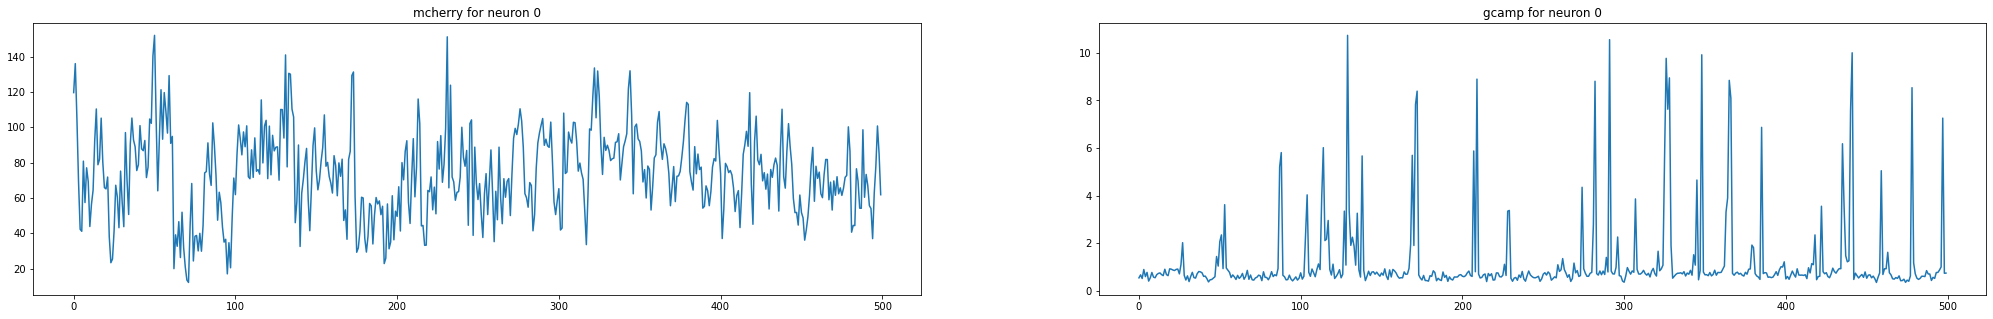

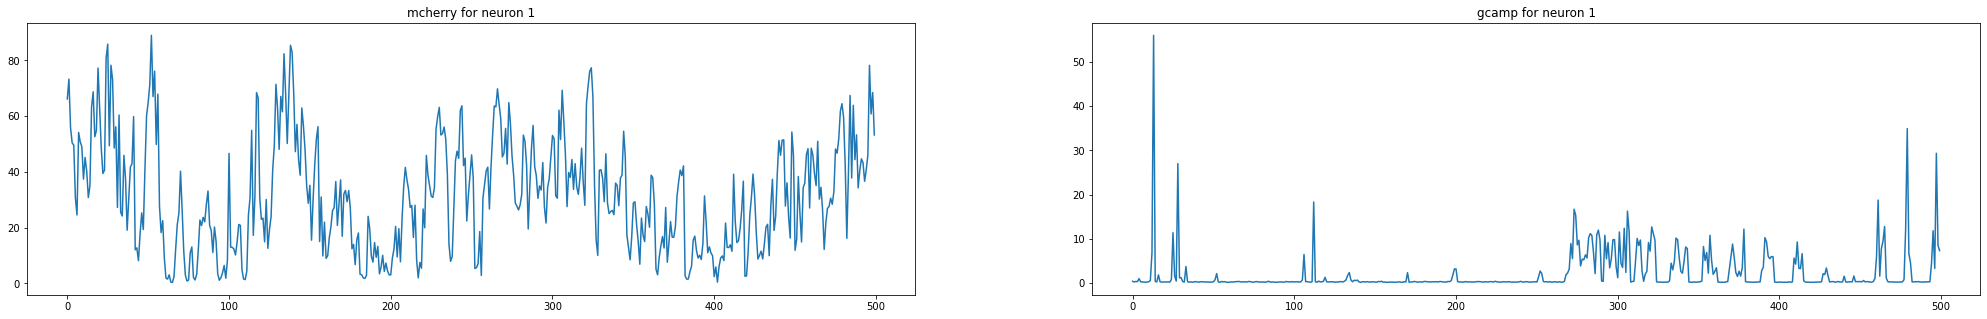

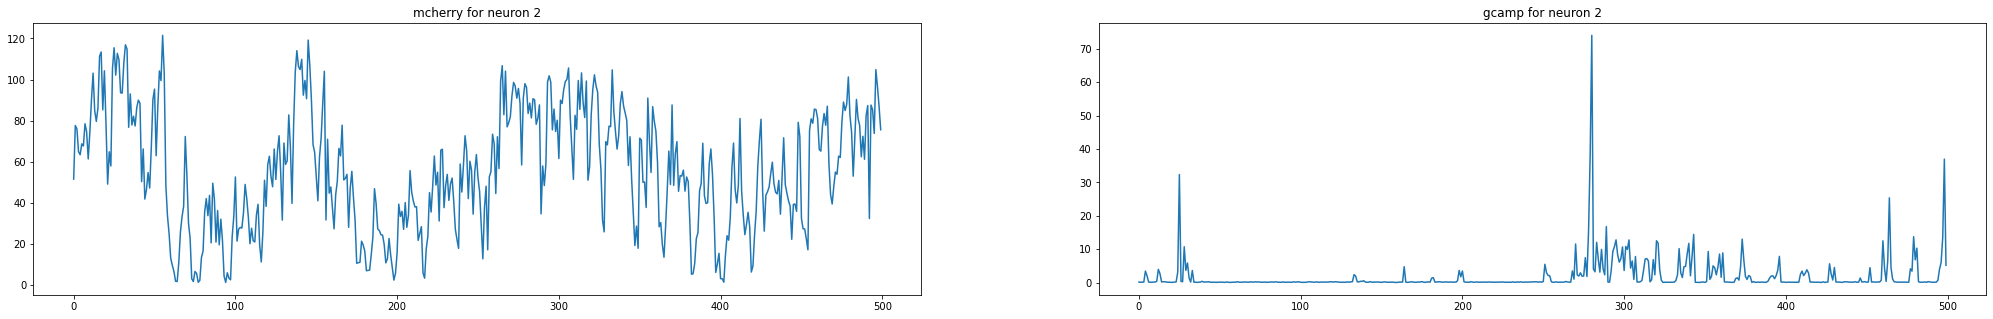

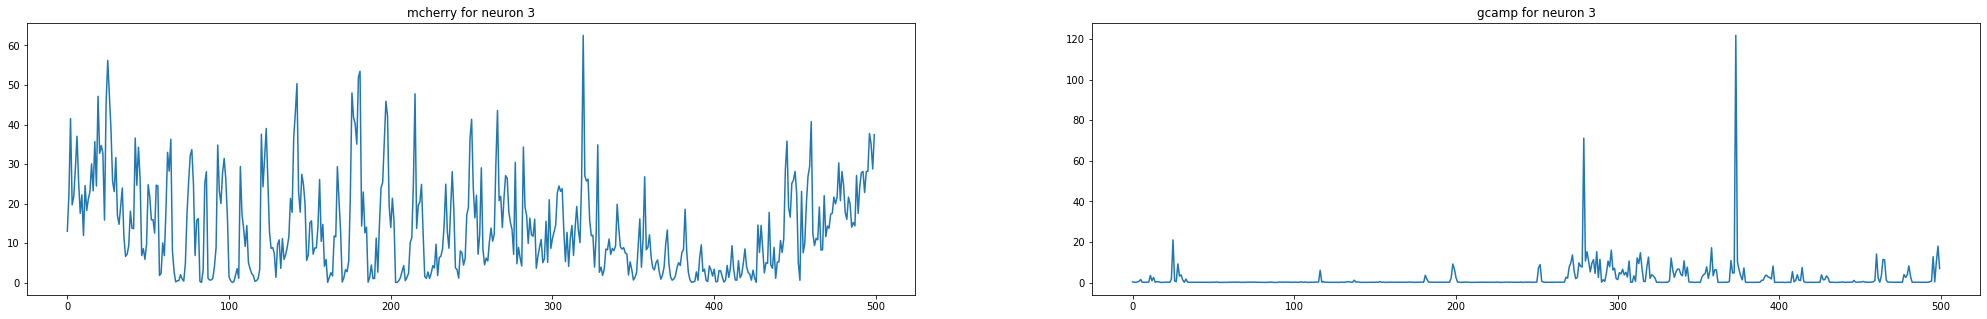

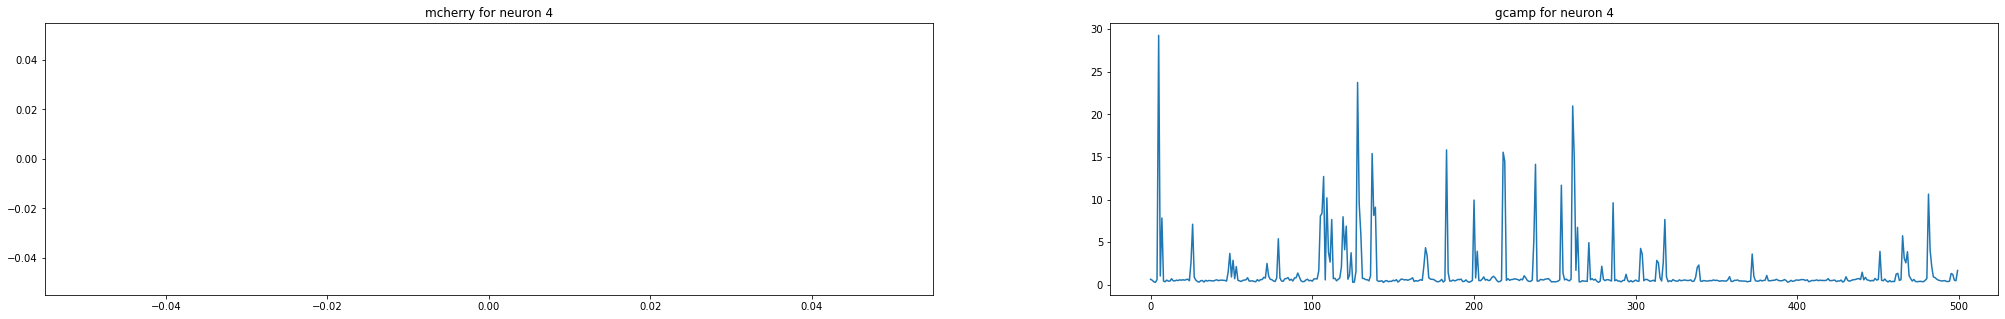

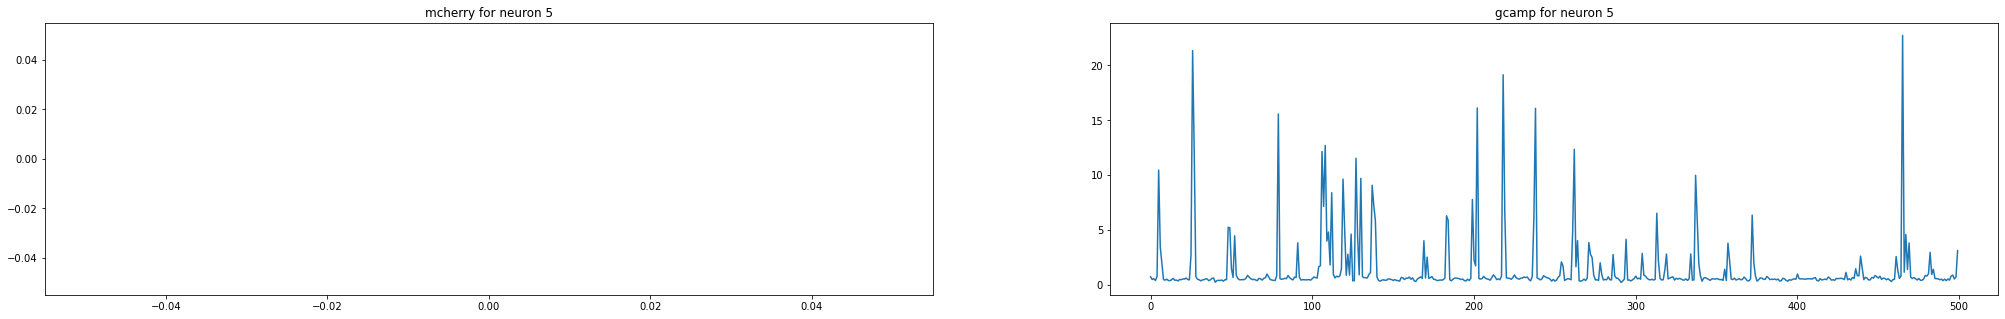

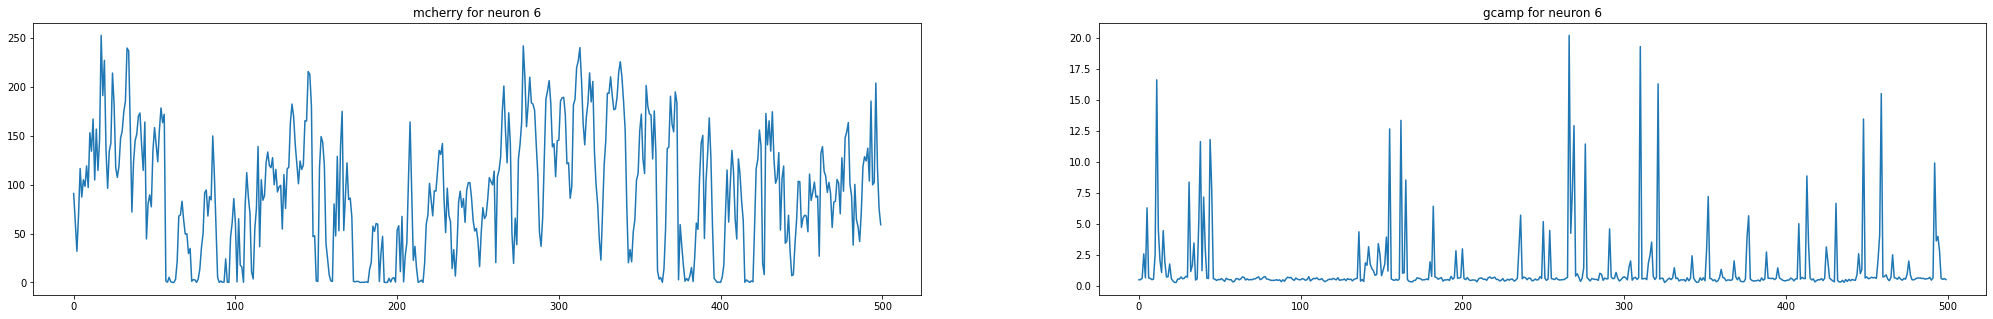

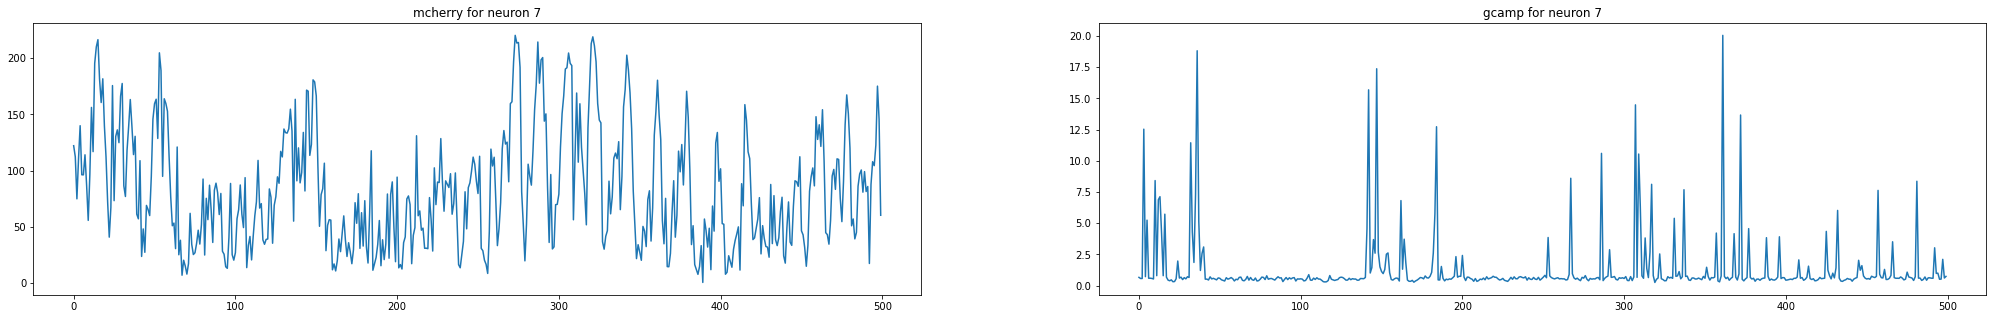

In [8]:
visualize_all_traces(all_traces)